# Exploratory Data Analysis and Cleaning for Robo Fault DataSet

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from datetime import timedelta
from sklearn.impute import KNNImputer
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from scipy import stats
from sklearn.metrics import roc_auc_score
from scipy.signal import correlate


# J0

In [11]:
df_joint0_stop = pd.read_csv('Joint_0_protective_stop.csv')
df_joint0_stop.head()

Num                 Timestamp  Current_J0      Speed_J0  Tool_current  \
0   20  2022-10-26T08:17:40.967Z   -0.177748 -2.195038e-02      0.083239   
1   21  2022-10-26T08:17:41.975Z   -0.161907  0.000000e+00      0.083919   
2   22  2022-10-26T08:17:42.989Z   -0.132235 -1.400000e-45      0.096649   
3   23  2022-10-26T08:17:43.990Z   -0.133344  0.000000e+00      0.085106   
4   24  2022-10-26T08:17:45.005Z   -0.132978  0.000000e+00      0.090878   

   Robot_ProtectiveStop  Temperature_T0  cycle   
0                  True         27.9375       1  
1                  True         27.8750       1  
2                  True         27.8750       1  
3                  True         27.8750       1  
4                  True         27.9375       1

In [12]:
df_joint0_grip = pd.read_csv('Joint_0_grip_loss.csv')
df_joint0_grip.head()

Num                 Timestamp  Current_J0  Speed_J0  Tool_current  \
0   44  2022-10-26T08:18:05.105Z    0.317540 -0.012641      0.083239   
1   45  2022-10-26T08:18:06.110Z    0.399679  0.070728      0.083746   
2   58  2022-10-26T08:18:19.192Z   -0.094453  0.000000      0.168534   
3   59  2022-10-26T08:18:20.195Z   -0.061609  0.000000      0.080186   
4   60  2022-10-26T08:18:21.196Z   -0.072397  0.000000      0.088331   

   grip_lost  Temperature_T0  cycle   
0       True         28.0000       2  
1       True         27.9375       2  
2       True         28.0000       2  
3       True         28.0000       2  
4       True         28.0000       2

In [13]:
df_joint0_stop.isnull().sum()

Num                     0
Timestamp               0
Current_J0              0
Speed_J0                0
Tool_current            0
Robot_ProtectiveStop    0
Temperature_T0          0
cycle                   0
dtype: int64

In [14]:
def null_percentage(df):
    null_counts = df.isnull().sum()
    total_rows = len(df)

    null_percentage = (null_counts / total_rows) * 100
    print(null_percentage)

In [15]:
null_percentage(df_joint0_stop)
null_percentage(df_joint0_grip)

Num                     0.0
Timestamp               0.0
Current_J0              0.0
Speed_J0                0.0
Tool_current            0.0
Robot_ProtectiveStop    0.0
Temperature_T0          0.0
cycle                   0.0
dtype: float64
Num               0.0
Timestamp         0.0
Current_J0        0.0
Speed_J0          0.0
Tool_current      0.0
grip_lost         0.0
Temperature_T0    0.0
cycle             0.0
dtype: float64


The Nulls Percentage is Small but Dropping the nulls in a time series analysis will be  risky

In [16]:
df_joint0_stop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Num                   275 non-null    int64  
 1   Timestamp             275 non-null    object 
 2   Current_J0            275 non-null    float64
 3   Speed_J0              275 non-null    float64
 4   Tool_current          275 non-null    float64
 5   Robot_ProtectiveStop  275 non-null    bool   
 6   Temperature_T0        275 non-null    float64
 7   cycle                 275 non-null    int64  
dtypes: bool(1), float64(4), int64(2), object(1)
memory usage: 15.4+ KB


In [17]:
def check_dubilcate(df):
    duplicates = df.duplicated()
    print(f"Number of duplicate rows: {duplicates.sum()}")


In [18]:
check_dubilcate(df_joint0_stop)
check_dubilcate(df_joint0_grip)

Number of duplicate rows: 0
Number of duplicate rows: 0


In [19]:
def convert_to_timestamp(df):
    df["Timestamp"] = df["Timestamp"].str.replace('"', '', regex=False)

    df["Timestamp"] = pd.to_datetime(df["Timestamp"], utc=True, errors="coerce")

In [20]:
convert_to_timestamp(df_joint0_stop)
convert_to_timestamp(df_joint0_grip)

In [21]:
df_joint0_grip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Num             240 non-null    int64              
 1   Timestamp       240 non-null    datetime64[ns, UTC]
 2   Current_J0      240 non-null    float64            
 3   Speed_J0        240 non-null    float64            
 4   Tool_current    240 non-null    float64            
 5   grip_lost       240 non-null    bool               
 6   Temperature_T0  240 non-null    float64            
 7   cycle           240 non-null    int64              
dtypes: bool(1), datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 13.5 KB


In [22]:

def remove_strip(df):
        df.columns = df.columns.str.strip()
        return df

df_joint0_stop=remove_strip(df_joint0_stop)
df_joint0_grip=remove_strip(df_joint0_grip)        


# Null Values

In [23]:
def fill_null_with_fandb(df):
    clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    return clean_data

In [24]:
df_joint0_stop_clean=fill_null_with_fandb(df_joint0_stop)


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\428220627.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [25]:
df_joint0_stop_clean.isnull().sum()

Num                     0
Timestamp               0
Current_J0              0
Speed_J0                0
Tool_current            0
Robot_ProtectiveStop    0
Temperature_T0          0
cycle                   0
dtype: int64

In [26]:
df_joint0_grip_clean=fill_null_with_fandb(df_joint0_grip)
df_joint0_grip_clean.isnull().sum()

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\428220627.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


Num               0
Timestamp         0
Current_J0        0
Speed_J0          0
Tool_current      0
grip_lost         0
Temperature_T0    0
cycle             0
dtype: int64

# feature engineering

In [27]:
def add_robot_features(df, dt=1.0):
    df = df.copy()
    curr_cols = [c for c in df.columns if c.startswith('Current_J')]
    spd_cols  = [c for c in df.columns if c.startswith('Speed_J')]
    tmp_cols  = [c for c in df.columns if c.startswith('Temperature')]
    for j in range(6):
        c, s = f'Current_J{j}', f'Speed_J{j}'
        if c in df and s in df:
            df[f'abs_{c}'] = df[c].abs()
            df[f'abs_{s}'] = df[s].abs()
            df[f'sudden{j}'] = df[s].diff() / dt
            df[f'power_J{j}'] = df[c].abs() * df[s].abs()
    return df
df_joint0_stop_clean = add_robot_features(df_joint0_stop_clean)
df_joint0_grip_clean = add_robot_features(df_joint0_grip_clean)

In [28]:
df_joint0_stop_clean

Num                        Timestamp  Current_J0      Speed_J0  \
cycle                                                                        
1     0      20 2022-10-26 08:17:40.967000+00:00   -0.177748 -2.195038e-02   
      1      21 2022-10-26 08:17:41.975000+00:00   -0.161907  0.000000e+00   
      2      22 2022-10-26 08:17:42.989000+00:00   -0.132235 -1.400000e-45   
      3      23 2022-10-26 08:17:43.990000+00:00   -0.133344  0.000000e+00   
      4      24 2022-10-26 08:17:45.005000+00:00   -0.132978  0.000000e+00   
...         ...                              ...         ...           ...   
261   270  7290 2022-10-26 15:34:06.875000+00:00    0.213052 -1.530000e-18   
264   271  7369 2022-10-26 15:35:26.342000+00:00   -0.100516 -1.634530e-04   
      272  7374 2022-10-26 15:35:31.371000+00:00    0.116355 -8.620000e-05   
      273  7376 2022-10-26 15:35:33.382000+00:00    0.041588  1.563657e-02   
      274  7377 2022-10-26 15:35:34.387000+00:00    0.190994 -3.327710e-04   

           Tool_current  Robot_ProtectiveStop  Temperature_T0  cycle  \
cycle                                                                  
1     0        0.083239                  True         27.9375      1   
      1        0.083919                  True         27.8750      1   
      2        0.096649                  True         27.8750      1   
      3        0.085106                  True         27.8750      1   
      4        0.090878                  True         27.9375      1   
...                 ...                   ...             ...    ...   
261   270      0.085785                  True         37.1875    261   
264   271      0.078740                  True         37.1875    264   
      272      0.081459                  True         37.1875    264   
      273      0.084426                  True         37.1250    264   
      274      0.081287                  True         37.1250    264   

           abs_Current_J0  abs_Speed_J0       sudden0      power_J0  
cycle                                                                
1     0          0.177748  2.195038e-02           NaN  3.901638e-03  
      1          0.161907  0.000000e+00  2.195038e-02  0.000000e+00  
      2          0.132235  1.400000e-45 -1.400000e-45  1.851286e-46  
      3          0.133344  0.000000e+00  1.400000e-45  0.000000e+00  
      4          0.132978  0.000000e+00  0.000000e+00  0.000000e+00  
...                   ...           ...           ...           ...  
261   270        0.213052  1.530000e-18 -4.594505e-02  3.259698e-19  
264   271        0.100516  1.634530e-04 -1.634530e-04  1.642969e-05  
      272        0.116355  8.620000e-05  7.725300e-05  1.002983e-05  
      273        0.041588  1.563657e-02  1.572277e-02  6.502976e-04  
      274        0.190994  3.327710e-04 -1.596934e-02  6.355732e-05  

[275 rows x 12 columns]

# EDA

In [29]:


def univariate_analysis(df, features, target):
    y = df[target].astype(int).values
    results = []
    for f in features:
        x = df[f].values
     
        x0, x1 = x[y==0], x[y==1]
        
        t, p = stats.ttest_ind(x0, x1, equal_var=False, nan_policy="omit")
        
        s0, s1 = x0.std(ddof=1), x1.std(ddof=1)
        sp = np.sqrt(((len(x0)-1)*s0**2 + (len(x1)-1)*s1**2) / (len(x0)+len(x1)-2))
        d = (x1.mean() - x0.mean()) / sp if sp > 0 else np.nan
        
        auc = roc_auc_score(y, x) if len(np.unique(y)) == 2 else np.nan
        results.append({
            "feature": f,
            "mean_no_fault": np.mean(x0),
            "mean_fault": np.mean(x1),
            "cohens_d": d,
            "t_stat": t,
            "p_value": p,
            "AUC": auc
        })
    return pd.DataFrame(results).sort_values("p_value")


features = ["Current_J0","Temperature_T0","Speed_J0","Tool_current"]
uni_stop = univariate_analysis(df_joint0_stop_clean, features, "Robot_ProtectiveStop")
uni_stop




c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: Runti

feature  mean_no_fault  mean_fault  cohens_d  t_stat  p_value  AUC
0      Current_J0            NaN    0.024667       NaN     NaN      NaN  NaN
1  Temperature_T0            NaN   35.710455       NaN     NaN      NaN  NaN
2        Speed_J0            NaN   -0.004987       NaN     NaN      NaN  NaN
3    Tool_current            NaN    0.088451       NaN     NaN      NaN  NaN

In [30]:
uni_grip = univariate_analysis(df_joint0_grip_clean, features, "grip_lost")
uni_grip

c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: Runti

feature  mean_no_fault  mean_fault  cohens_d  t_stat  p_value  AUC
0      Current_J0            NaN    0.004497       NaN     NaN      NaN  NaN
1  Temperature_T0            NaN   33.560677       NaN     NaN      NaN  NaN
2        Speed_J0            NaN    0.020255       NaN     NaN      NaN  NaN
3    Tool_current            NaN    0.096473       NaN     NaN      NaN  NaN

In [31]:
def quartile_fault_analysis(df, feature, target):

    quartiles = pd.qcut(df[feature], 4, labels=["Q1","Q2","Q3","Q4"])
    bins = pd.qcut(df[feature], 4)  
    
    df = df.copy()
    df["quartile"] = quartiles
    
    
    result = df.groupby("quartile")[target].agg(
        fault_rate="mean",
        count="size"
    ).reset_index()
    

    result["range"] = bins.unique().sort_values().astype(str).tolist()
    
    return result

q_temp = quartile_fault_analysis(df_joint0_stop_clean, "Temperature_T0", "Robot_ProtectiveStop")
q_temp

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count             range
0       Q1         1.0     73  (27.874, 34.375]
1       Q2         1.0     82  (34.375, 36.938]
2       Q3         1.0     77  (36.938, 37.125]
3       Q4         1.0     43   (37.125, 37.25]

In [32]:
q_temp_grip = quartile_fault_analysis(df_joint0_grip_clean, "Temperature_T0", "grip_lost")
q_temp_grip

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count                         range
0       Q1         1.0     62  (27.936999999999998, 29.312]
1       Q2         1.0     58              (29.312, 33.906]
2       Q3         1.0     65                (33.906, 37.0]
3       Q4         1.0     55                 (37.0, 37.25]

In [33]:


q_temp_stop_per_current = quartile_fault_analysis(df_joint0_stop_clean, "Current_J0", "Robot_ProtectiveStop")
q_temp_stop_per_current

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count              range
0       Q1         1.0     69   (-2.276, -0.124]
1       Q2         1.0     69  (-0.124, -0.0231]
2       Q3         1.0     68  (-0.0231, 0.0792]
3       Q4         1.0     69    (0.0792, 6.807]

In [34]:
q_temp_grip_per_current=quartile_fault_analysis(df_joint0_grip_clean, "Current_J0", "grip_lost")
q_temp_grip_per_current

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count              range
0       Q1         1.0     60   (-2.396, -0.181]
1       Q2         1.0     60  (-0.181, -0.0816]
2       Q3         1.0     60   (-0.0816, 0.101]
3       Q4         1.0     60      (0.101, 5.51]

In [35]:


q_temp_speed_srtop = quartile_fault_analysis(df_joint0_stop_clean, "Speed_J0", "Robot_ProtectiveStop")
q_temp_speed_srtop


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count                           range
0       Q1         1.0     69             (-0.333, -8.46e-05]
1       Q2         1.0    136                (-8.46e-05, 0.0]
2       Q3         1.0      1   (0.0, 1.1300000000000002e-41]
3       Q4         1.0     69  (1.1300000000000002e-41, 0.13]

In [36]:
q_temp_speed_grip=quartile_fault_analysis(df_joint0_grip_clean, "Speed_J0", "grip_lost")
q_temp_speed_grip

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count                range
0       Q1         1.0     60  (-0.396, -0.000127]
1       Q2         1.0     65     (-0.000127, 0.0]
2       Q3         1.0     55        (0.0, 0.0785]
3       Q4         1.0     60      (0.0785, 0.286]

In [37]:


q_temp_tool_stop = quartile_fault_analysis(df_joint0_stop_clean, "Tool_current", "Robot_ProtectiveStop")
q_temp_tool_stop

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count             range
0       Q1         1.0     72   (0.0735, 0.082]
1       Q2         1.0     75   (0.082, 0.0844]
2       Q3         1.0     61  (0.0844, 0.0864]
3       Q4         1.0     67   (0.0864, 0.501]

In [38]:


q_temp_tool_grip = quartile_fault_analysis(df_joint0_grip_clean, "Tool_current", "grip_lost")
q_temp_tool_grip

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2829786370.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count             range
0       Q1         1.0     60  (0.0752, 0.0824]
1       Q2         1.0     60  (0.0824, 0.0852]
2       Q3         1.0     63  (0.0852, 0.0896]
3       Q4         1.0     57   (0.0896, 0.481]

In [39]:

# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# لو الجدول عريض جدًا، ممكن كمان:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# دلوقتي أي DataFrame هيتعرض بالكامل


In [40]:
# Group by Fault/Normal and calculate summary stats
def  stats_protective(df,columns):
    
    stats = df.groupby('Robot_ProtectiveStop')[[columns]].describe()
    return stats


In [41]:
stats_protective(df_joint0_stop_clean,'Temperature_T0')


Temperature_T0                                      \
                              count       mean      std     min     25%   
Robot_ProtectiveStop                                                      
True                          275.0  35.710455  2.24556  27.875  34.375   

                                              
                          50%     75%    max  
Robot_ProtectiveStop                          
True                  36.9375  37.125  37.25

In [42]:
stats_protective(df_joint0_stop_clean,'Current_J0')


Current_J0                                         \
                          count      mean      std       min       25%   
Robot_ProtectiveStop                                                     
True                      275.0  0.024667  0.59353 -2.274941 -0.124053   

                                                    
                           50%       75%       max  
Robot_ProtectiveStop                                
True                 -0.023118  0.079223  6.806938

In [43]:
stats_protective(df_joint0_stop_clean,'Speed_J0')


Speed_J0                                               \
                        count      mean       std       min       25%  50%   
Robot_ProtectiveStop                                                         
True                    275.0 -0.004987  0.038486 -0.332335 -0.000085  0.0   

                                              
                               75%       max  
Robot_ProtectiveStop                          
True                  1.132880e-41  0.129558

In [44]:
stats_protective(df_joint0_stop_clean,'Tool_current')

Tool_current                                       \
                            count      mean      std     min       25%   
Robot_ProtectiveStop                                                     
True                        275.0  0.088451  0.03913  0.0745  0.081966   

                                                   
                           50%       75%      max  
Robot_ProtectiveStop                               
True                  0.084426  0.086379  0.50131

In [45]:
def stats_grip(df,columns):
    stats=df.groupby("grip_lost")[[columns]].describe()
    return stats

In [46]:
stats_grip(df_joint0_grip_clean,'Temperature_T0')

Temperature_T0                                                   \
                   count       mean       std      min      25%       50%   
grip_lost                                                                   
True               240.0  33.560677  3.531359  27.9375  29.3125  33.90625   

                        
            75%    max  
grip_lost               
True       37.0  37.25

In [47]:
stats_grip(df_joint0_grip_clean,'Current_J0')

Current_J0                                                    \
               count      mean       std       min       25%       50%   
grip_lost                                                                
True           240.0  0.004497  0.604794 -2.395309 -0.181198 -0.081602   

                              
                75%      max  
grip_lost                     
True       0.100825  5.51025

In [48]:
stats_grip(df_joint0_grip_clean,'Speed_J0')

Speed_J0                                                        \
             count      mean       std      min       25%  50%       75%   
grip_lost                                                                  
True         240.0  0.020255  0.114889 -0.39503 -0.000127  0.0  0.078538   

                     
                max  
grip_lost            
True       0.285812

In [49]:
stats_grip(df_joint0_grip_clean,'Tool_current')

Tool_current                                                    \
                 count      mean       std       min       25%       50%   
grip_lost                                                                  
True             240.0  0.096473  0.044306  0.076194  0.082368  0.085192   

                               
                75%       max  
grip_lost                      
True       0.089604  0.480941

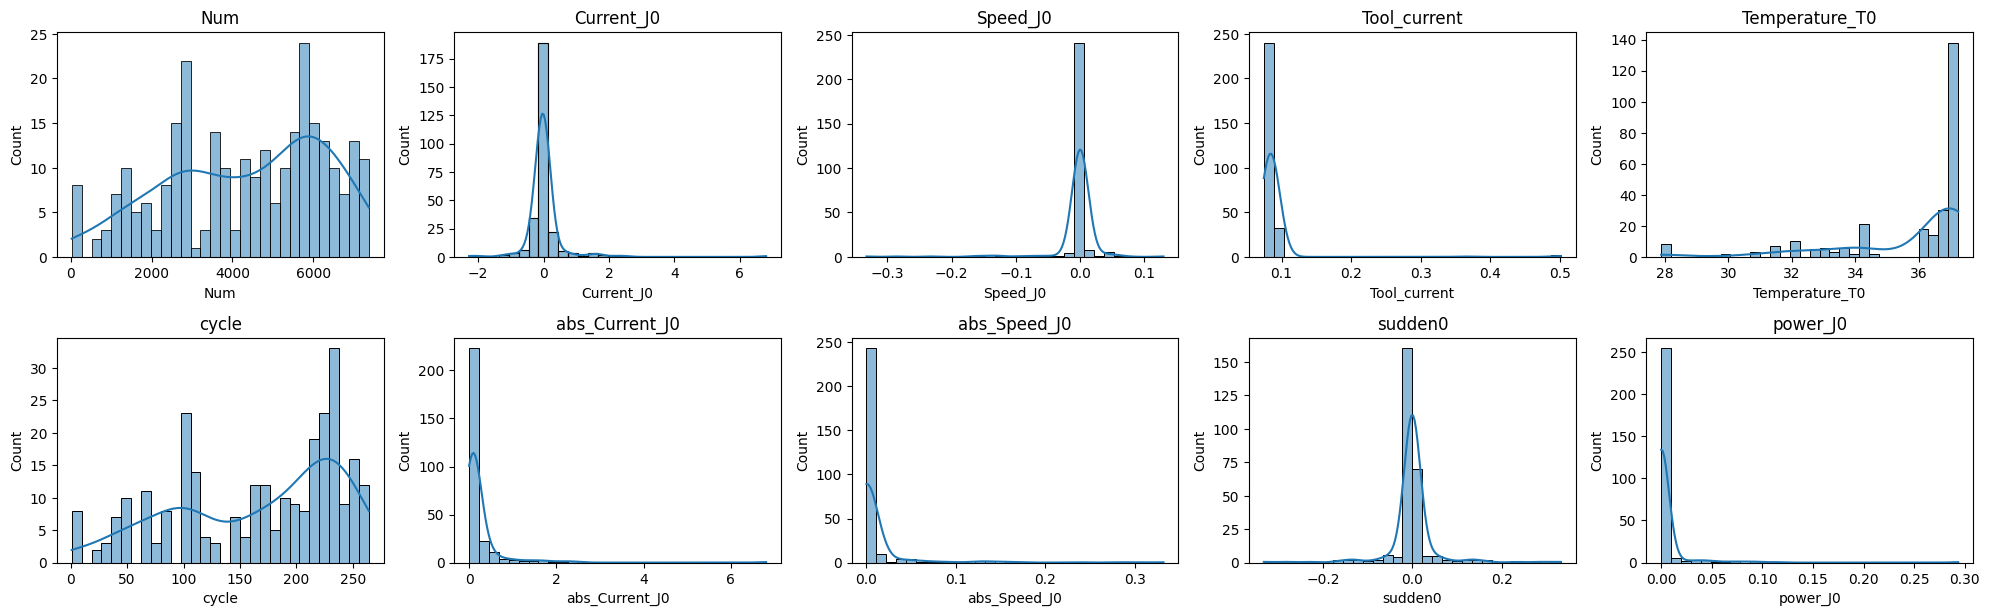

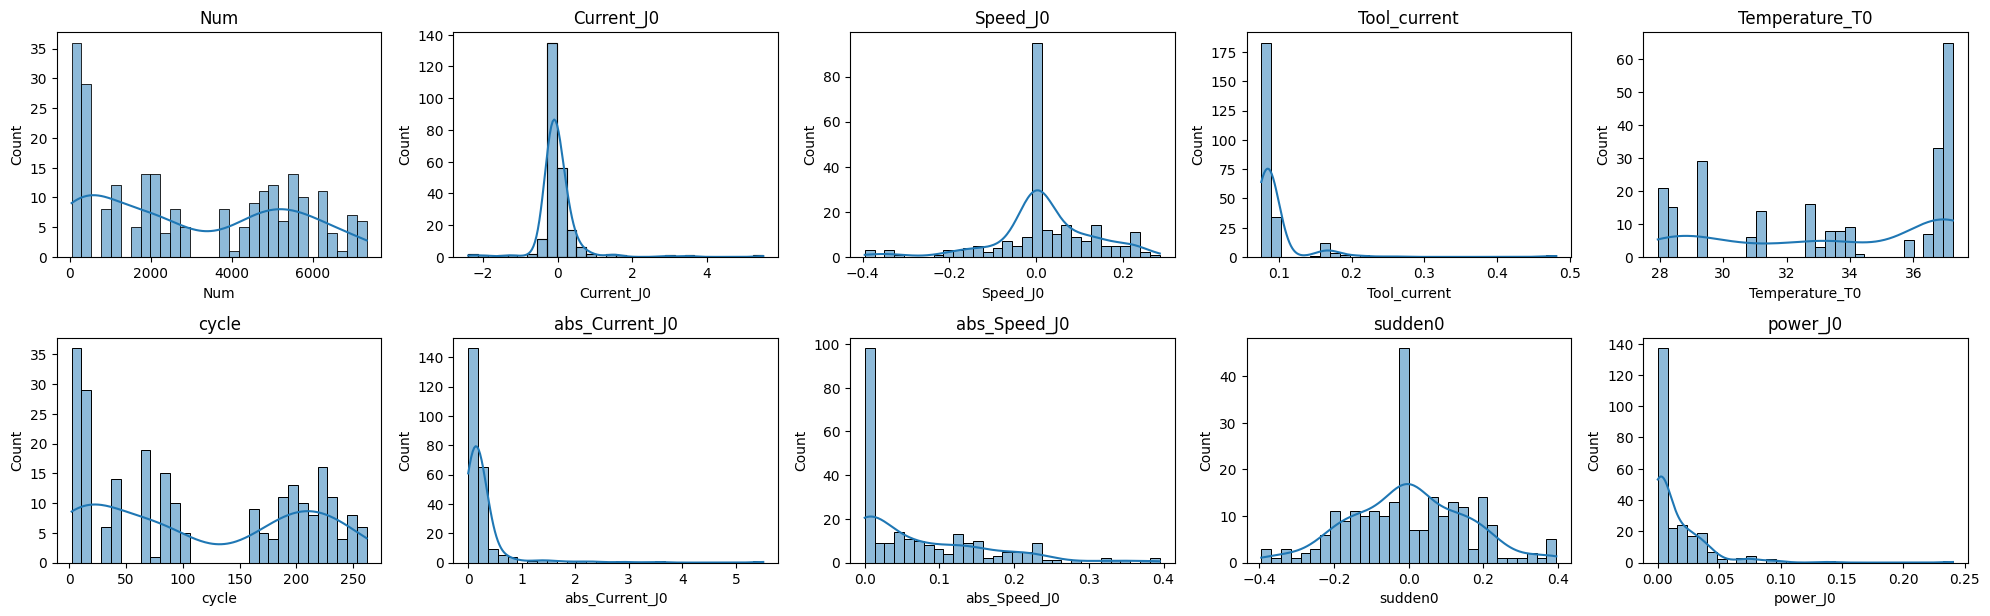

In [50]:
def plot_histograms(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    plt.figure(figsize=(20, 15))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(5, 5, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(col)
        plt.tight_layout()

    plt.show()
plot_histograms(df_joint0_stop_clean)
plot_histograms(df_joint0_grip_clean)

**Currents (Current_J0):**

Mostly centered around 0, with symmetric bell-like shapes robot joints normally operate near zero torque when idle.

joint (like J1) show heavy tails   these joints experience higher torque variation, maybe because they handle more load.


**Temperatures (Temperature_T0):**

Distributions are not Gaussian 


**Speeds (Speed_J0):**

Extremely narrow, centered around 0.

Suggests most of the time, the robot joints are either stopped or moving very slowly.

Occasional values far from 0 indicate bursts of motion.

**Tool_current:**

Also tightly clustered, mostly around 0.1–0.2.

Rare higher values indicate the gripper is under load.



Robot_ProtectiveStop has nulls and it's an important feature and what is it's balance 
For the nulls I think Each cycle has many time-series rows until the task finishes.
so we can use the cycle to see through the task the robot had to make a protectivestop or not and use the mode of the protectivestop in the cycle to fill this nulls

In [51]:
def plot_balance(df,x,title,xlabel):
    sns.countplot(x=x, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.show()

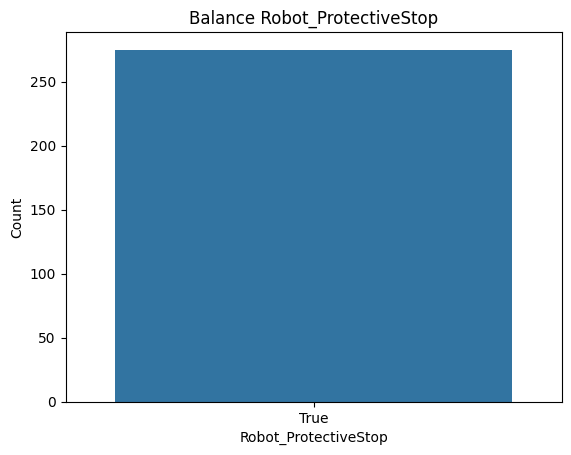

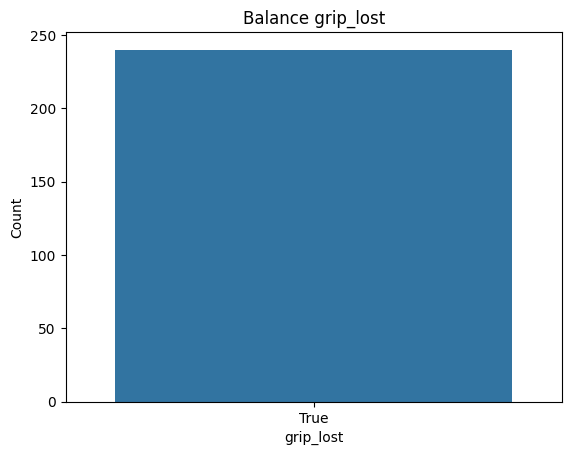

In [52]:
plot_balance(df_joint0_stop_clean,"Robot_ProtectiveStop","Balance Robot_ProtectiveStop","Robot_ProtectiveStop")
plot_balance(df_joint0_grip_clean,"grip_lost","Balance grip_lost","grip_lost")

In [53]:
def percentage_balance(df, column):
    counts = df[column].value_counts(normalize=True) * 100
    for value, pct in counts.items():
        print(f"{column} = {value}: {pct:.2f}%")
percentage_balance(df_joint0_stop_clean,"Robot_ProtectiveStop")
percentage_balance(df_joint0_grip_clean,"grip_lost")


Robot_ProtectiveStop = True: 100.00%
grip_lost = True: 100.00%


Robot_Protectivestop is soo unbalanced to the zero class which means that the faults are the minority that makes the robot stops

In [54]:
def check_skewness(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    skewness = df[numerical_cols].skew().sort_values(ascending=False)
    return skewness
check_skewness(df_joint0_stop_clean)



Tool_current      9.701227
power_J0          8.930796
abs_Current_J0    7.595876
Current_J0        5.846319
abs_Speed_J0      5.636624
sudden0          -0.006302
Num              -0.362367
cycle            -0.553821
Temperature_T0   -1.805918
Speed_J0         -5.184853
dtype: float64

In [55]:
check_skewness(df_joint0_grip_clean)


abs_Current_J0    6.088432
Tool_current      6.027183
power_J0          4.132236
Current_J0        4.028940
abs_Speed_J0      1.269850
Num               0.245019
cycle             0.157505
sudden0           0.053883
Temperature_T0   -0.361274
Speed_J0         -0.719286
dtype: float64

In [56]:
def correlation_heatmap(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
        
    plt.figure(figsize=(18,10))
    sns.heatmap(df[numerical_cols].corr(), cmap="coolwarm", annot=True)
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()


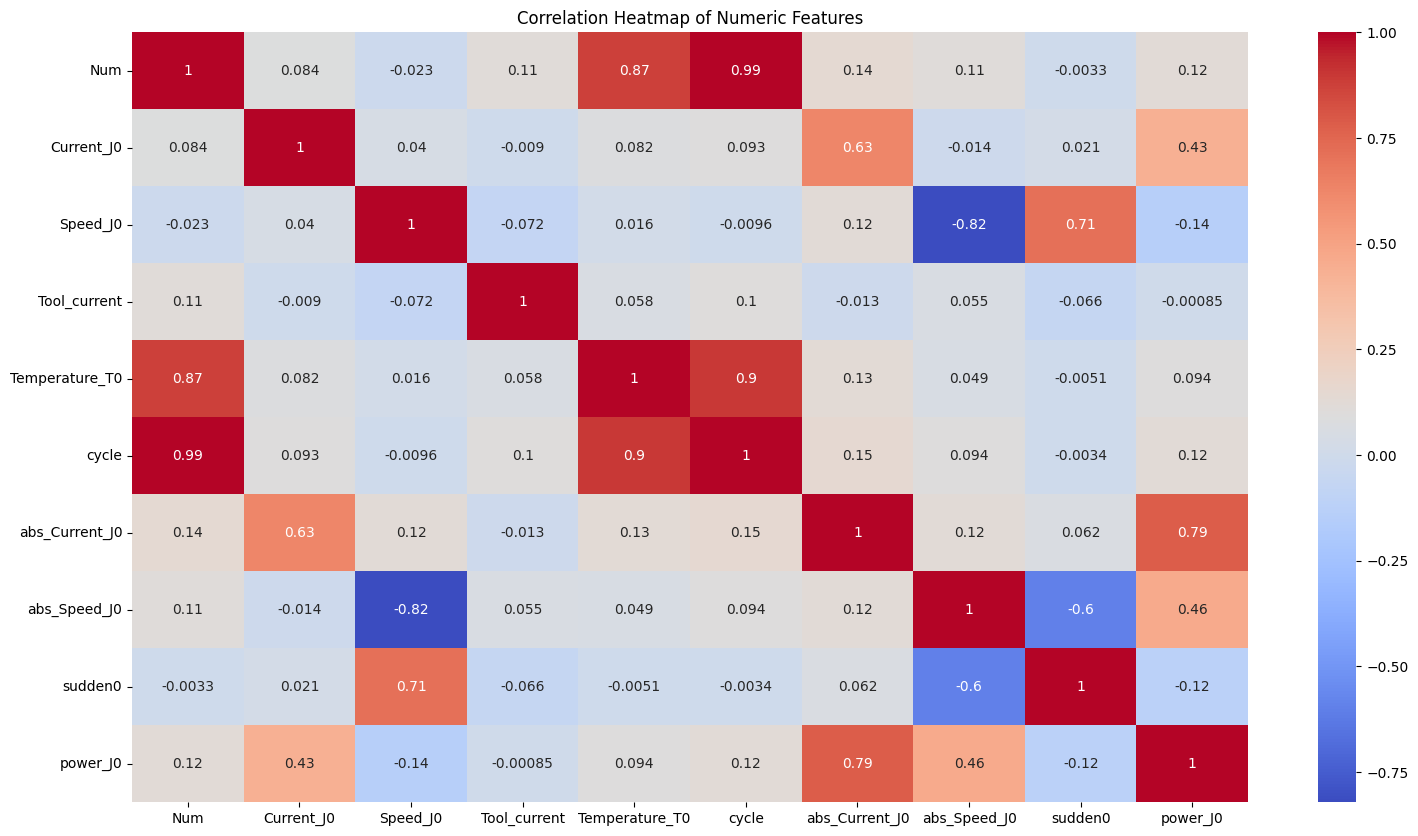

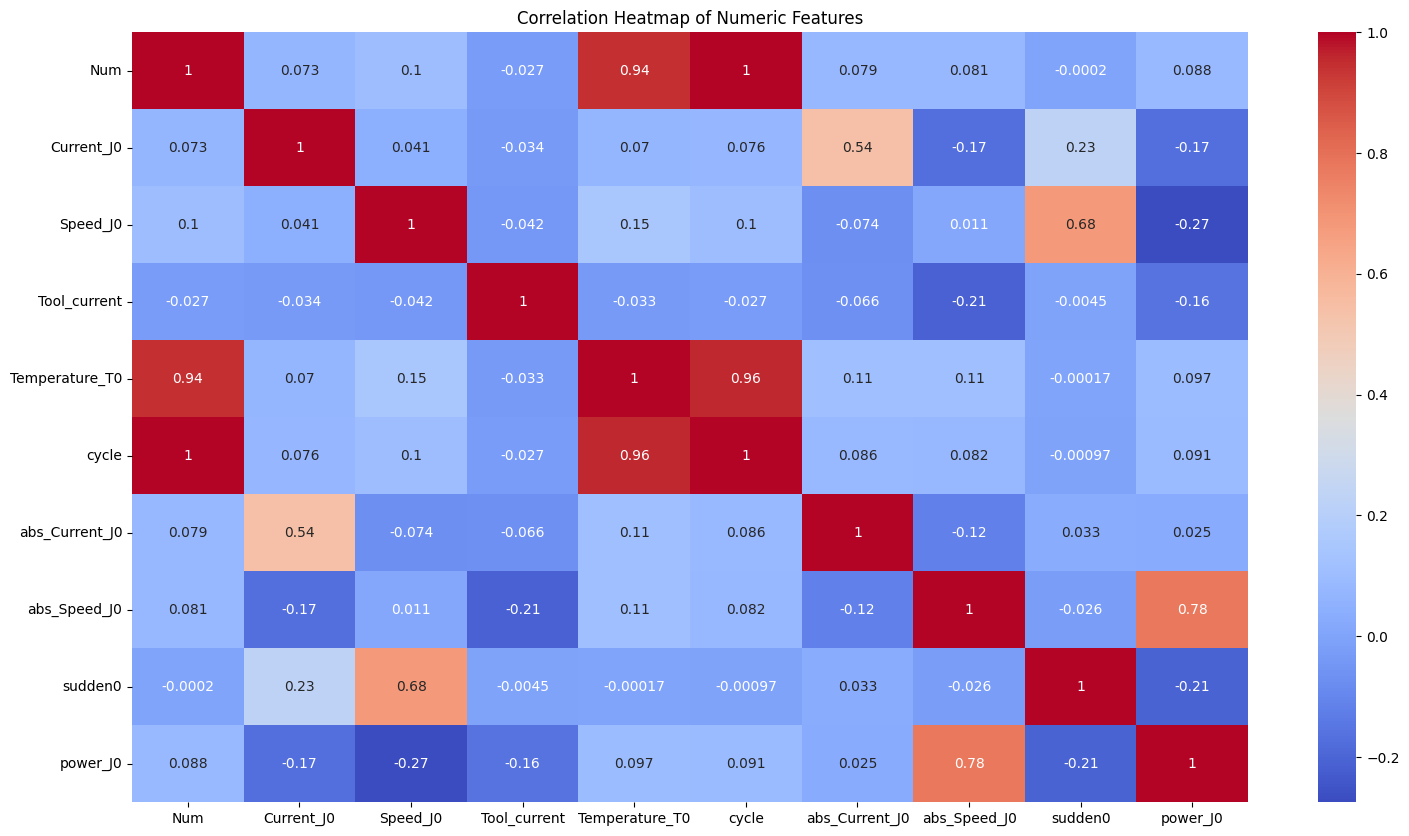

In [57]:
correlation_heatmap(df_joint0_stop_clean)
correlation_heatmap(df_joint0_grip_clean)



Current and Speed (same joint) are small-to-moderate (∼0.2–0.4)

Cross-joint speeds show  negative correlations (maybe some joints move opposite to others).

A few striking pairs (Current_J5 and  Speed_J4) and (Current_J4 and  Current_J0)


In [58]:
def scatter_plot_between_temp(x, y, title):
    
    sns.scatterplot(x=x, y=y)
    plt.title(title)

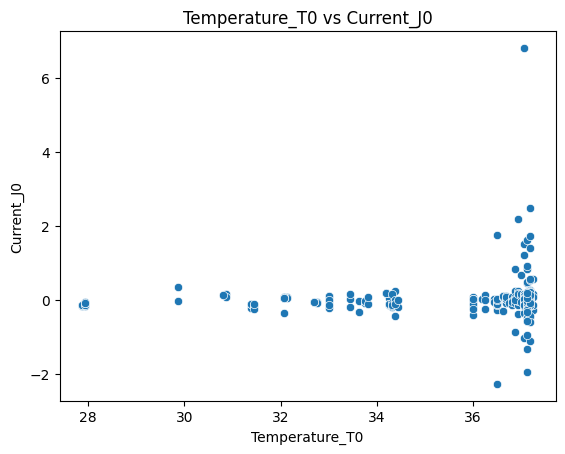

In [59]:
scatter_plot_between_temp(df_joint0_stop_clean['Temperature_T0'], df_joint0_stop_clean['Current_J0'], 'Temperature_T0 vs Current_J0')


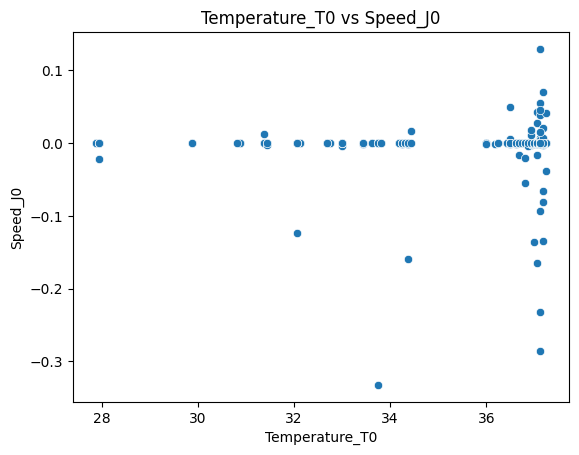

In [60]:
scatter_plot_between_temp(df_joint0_stop_clean['Temperature_T0'], df_joint0_stop_clean['Speed_J0'], 'Temperature_T0 vs Speed_J0')


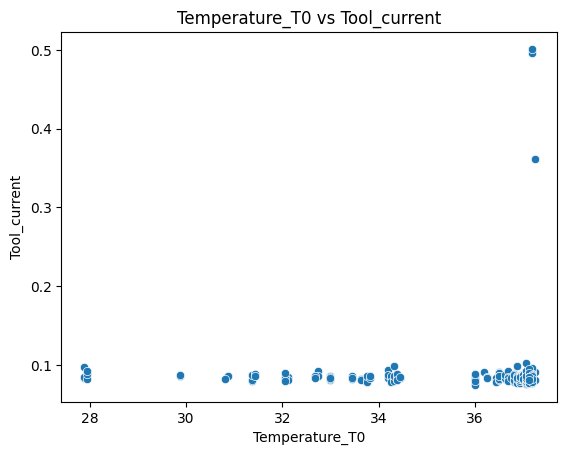

In [61]:
scatter_plot_between_temp(df_joint0_stop_clean['Temperature_T0'], df_joint0_stop_clean['Tool_current'], 'Temperature_T0 vs Tool_current')

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1956437239.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


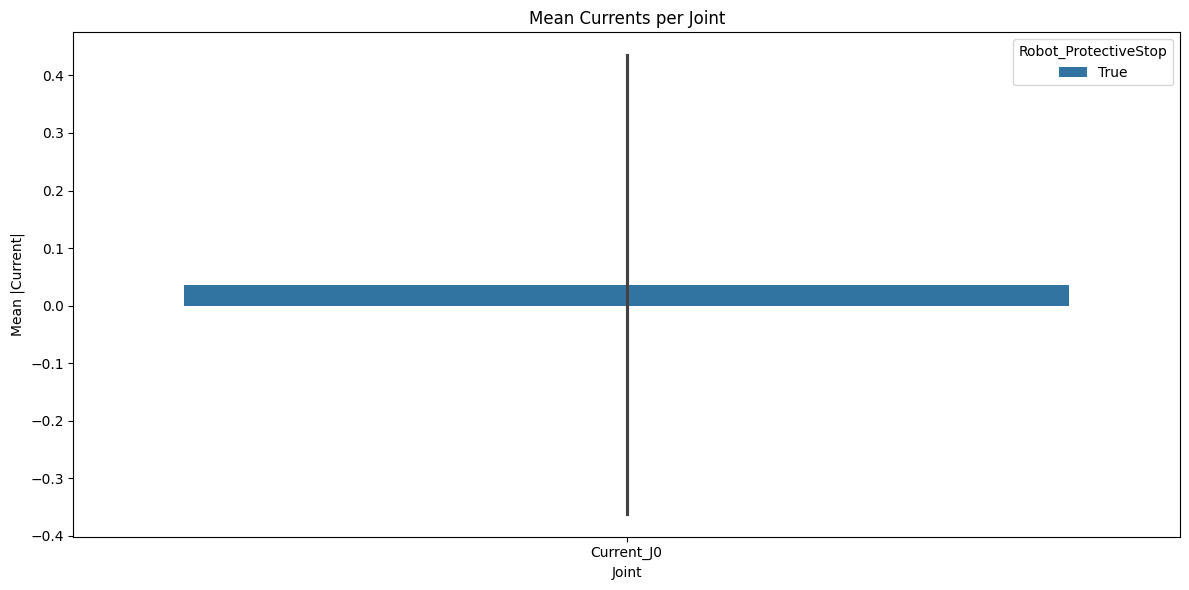

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1956437239.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


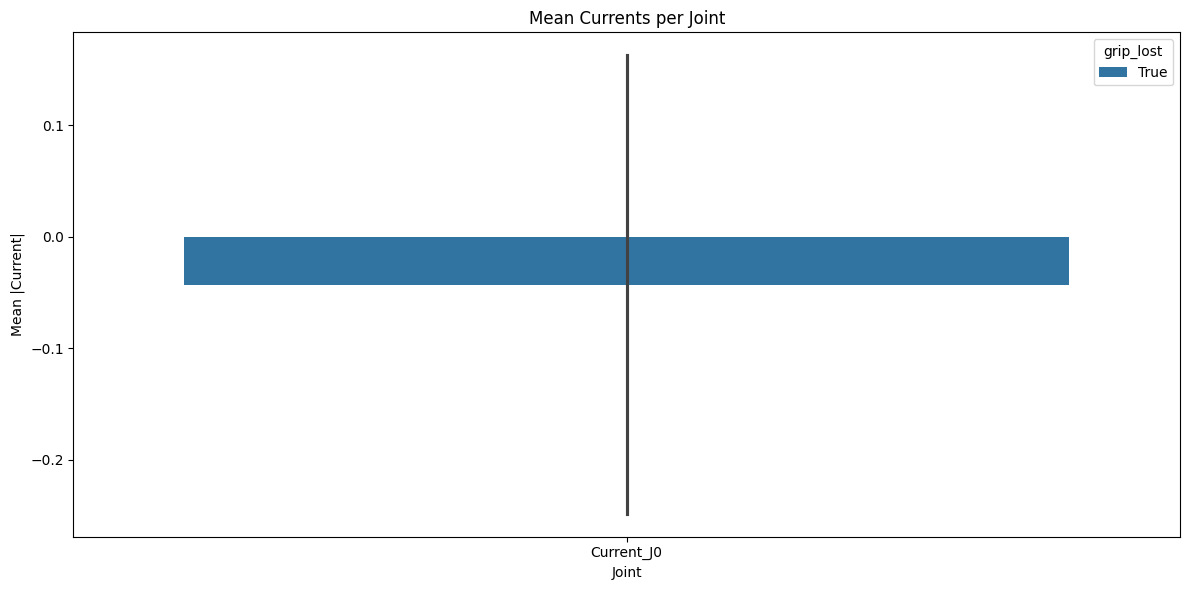

In [62]:


def plot_currents(df, cycle_col="cycle", stop_col="Robot_ProtectiveStop"):
    if cycle_col in df.index.names and cycle_col in df.columns:
        df = df.reset_index(drop=True)  
    elif cycle_col in df.index.names:
        df = df.reset_index()  

    df.columns = df.columns.str.strip()

    currents = [c for c in df.columns if c.startswith("Current_J")]

    if not currents:
        raise ValueError("No abs_Current_J* columns found in dataframe.")

    cycle_means = (
        df.groupby(cycle_col)
          .agg({stop_col: 'max', **{c: 'mean' for c in currents}})
          .reset_index()
    )

    if len(currents) == 1:
        long_curr = cycle_means.rename(columns={currents[0]: "abs_current_mean"})
        long_curr["joint"] = currents[0]
    else:
        long_curr = cycle_means.melt(
            id_vars=[cycle_col, stop_col],
            value_vars=currents,
            var_name='joint',
            value_name='abs_current_mean'
        )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=long_curr,
        x='joint',
        y='abs_current_mean',
        hue=stop_col,
        ci='sd'
    )
    plt.title("Mean Currents per Joint")
    plt.xlabel("Joint")
    plt.ylabel("Mean |Current|")
    plt.tight_layout()
    plt.show()


plot_currents(df_joint0_stop_clean)
plot_currents(df_joint0_grip_clean, stop_col="grip_lost")


### Mean Currents per Joint (Normal vs Stop)

- **J1** shows the highest mean current across all joints (~2.3), followed by **J2** and **J3 **.  
- In **stop cycles**, J1 and J2 currents are slightly higher than in normal cycles.  
- **J0, J4, J5** draw very low current overall and show little difference between stop and non-stop cycles.  
- Protective stops are strongly tied to higher currents in **load-bearing joints (J1 and J2)**.  
- This suggests that mechanical overload in these joints is a major factor in triggering stops.  
  


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1780988295.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


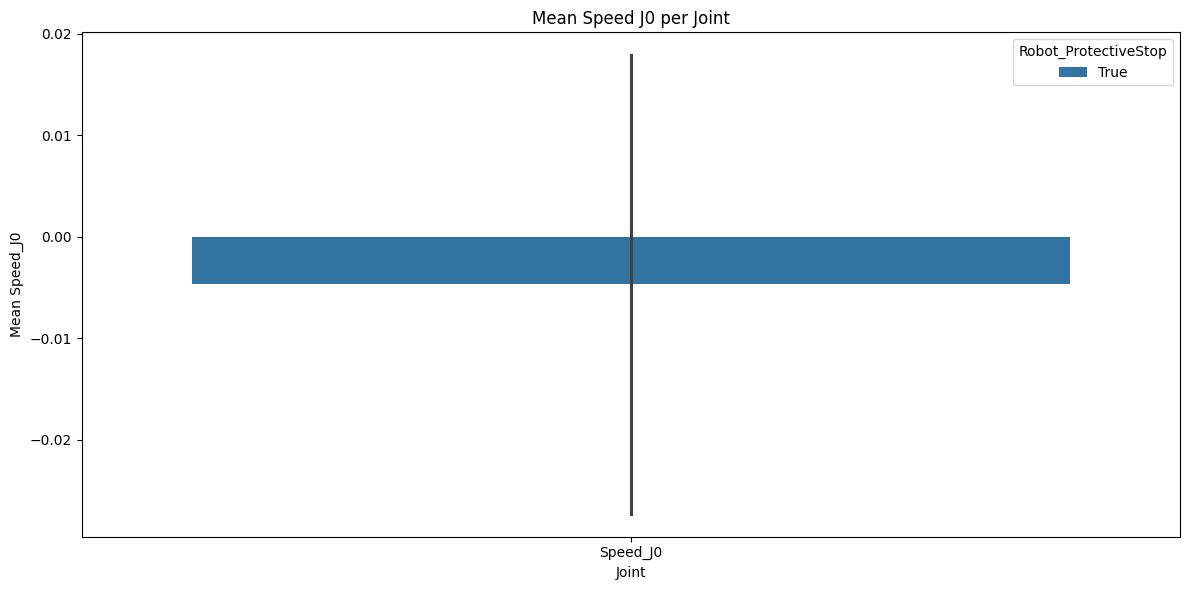

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1780988295.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


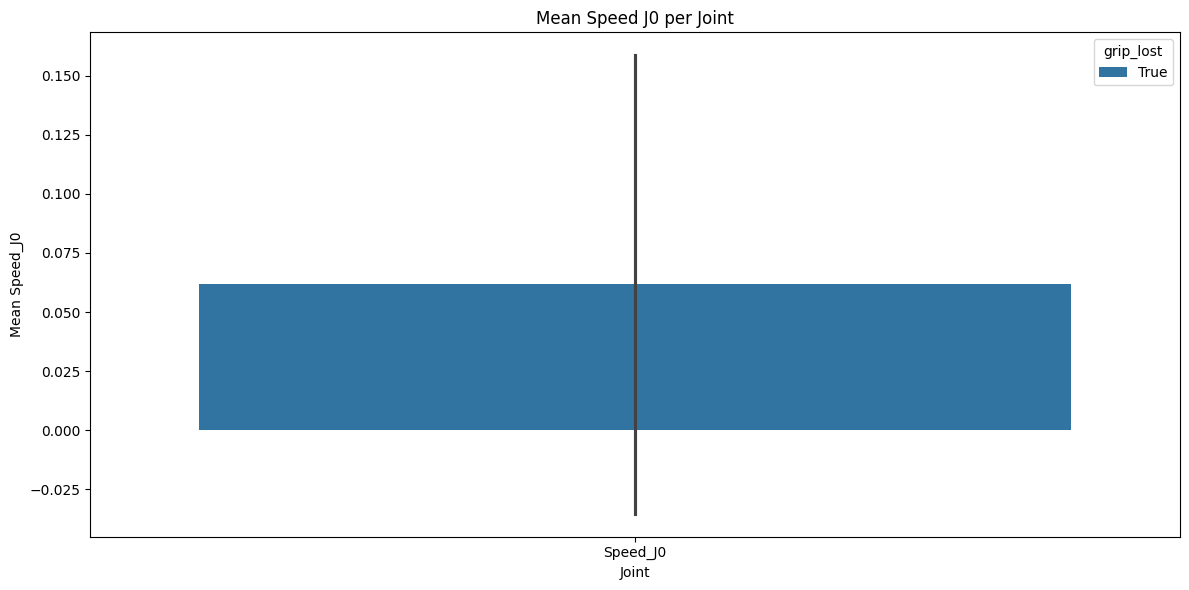

cycle  grip_lost     joint  Speed_J0_mean
0       2       True  Speed_J0      -0.008117
1       5       True  Speed_J0      -0.192675
2       6       True  Speed_J0      -0.041073
3      14       True  Speed_J0      -0.032955
4      15       True  Speed_J0       0.026114
5      36       True  Speed_J0      -0.006998
6      39       True  Speed_J0       0.070861
7      40       True  Speed_J0       0.016370
8      63       True  Speed_J0      -0.031030
9      64       True  Speed_J0       0.075572
10     65       True  Speed_J0       0.017145
11     67       True  Speed_J0       0.058083
12     69       True  Speed_J0       0.241402
13     76       True  Speed_J0       0.176873
14     80       True  Speed_J0       0.012709
15     81       True  Speed_J0       0.070182
16     86       True  Speed_J0       0.026234
17     91       True  Speed_J0       0.114223
18     92       True  Speed_J0       0.189928
19     95       True  Speed_J0       0.019600
20     96       True  Speed_J0       0.229174
21     97       True  Speed_J0       0.231556
22    105       True  Speed_J0       0.049133
23    160       True  Speed_J0      -0.023900
24    164       True  Speed_J0       0.203098
25    173       True  Speed_J0      -0.021556
26    174       True  Speed_J0       0.219393
27    180       True  Speed_J0      -0.013864
28    185       True  Speed_J0       0.095813
29    188       True  Speed_J0      -0.019165
30    192       True  Speed_J0       0.136537
31    193       True  Speed_J0       0.220660
32    194       True  Speed_J0      -0.025487
33    196       True  Speed_J0       0.130014
34    198       True  Speed_J0       0.227577
35    200       True  Speed_J0       0.043198
36    202       True  Speed_J0      -0.022486
37    208       True  Speed_J0       0.060661
38    214       True  Speed_J0       0.224246
39    216       True  Speed_J0       0.038499
40    219       True  Speed_J0      -0.026180
41    221       True  Speed_J0       0.020807
42    232       True  Speed_J0       0.026788
43    233       True  Speed_J0       0.054642
44    234       True  Speed_J0      -0.020797
45    237       True  Speed_J0      -0.018989
46    247       True  Speed_J0       0.000000
47    250       True  Speed_J0       0.208509
48    251       True  Speed_J0       0.102184
49    253       True  Speed_J0       0.026575
50    262       True  Speed_J0      -0.013914

In [63]:
def plot_speed_feature(df, prefix="Speed_J", cycle_col="cycle", stop_col="Robot_ProtectiveStop"):
   
    if cycle_col in df.index.names and cycle_col in df.columns:
        df = df.reset_index(drop=True)
    elif cycle_col in df.index.names:
        df = df.reset_index()
    speed_cols = [c for c in df.columns if c.startswith(prefix)]
    if not speed_cols:
        raise ValueError(f"No {prefix}* columns found in dataframe.")
    cycle_speeds = (
        df.groupby(cycle_col)
          .agg({stop_col: 'max', **{c: 'mean' for c in speed_cols}})
          .reset_index()
    )
    long_speed = cycle_speeds.melt(
        id_vars=[cycle_col, stop_col],
        value_vars=speed_cols,
        var_name='joint',
        value_name=f'{prefix}_mean'
    )
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=long_speed,
        x='joint',
        y=f'{prefix}_mean',
        hue=stop_col,
        ci='sd'
    )
    plt.title(f"Mean {prefix.replace('_',' ')} per Joint")
    plt.xlabel("Joint")
    plt.ylabel(f"Mean {prefix}")
    plt.tight_layout()
    plt.show()
    return long_speed
plot_speed_feature(df_joint0_stop_clean, prefix="Speed_J0", stop_col="Robot_ProtectiveStop")
plot_speed_feature(df_joint0_grip_clean, prefix="Speed_J0", stop_col="grip_lost")

### Mean Speeds per Joint (Normal vs Stop)

- J2, J3, and J5 joints have the highest average speeds across cycles.  
- In **stop cycles**, speeds are consistently lower compared to normal ones.  
- This suggests that **protective stops are not triggered by high-speed motions**.  
- Instead, the robot may be stopping during **slower but high-load movements**.  


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3436744854.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


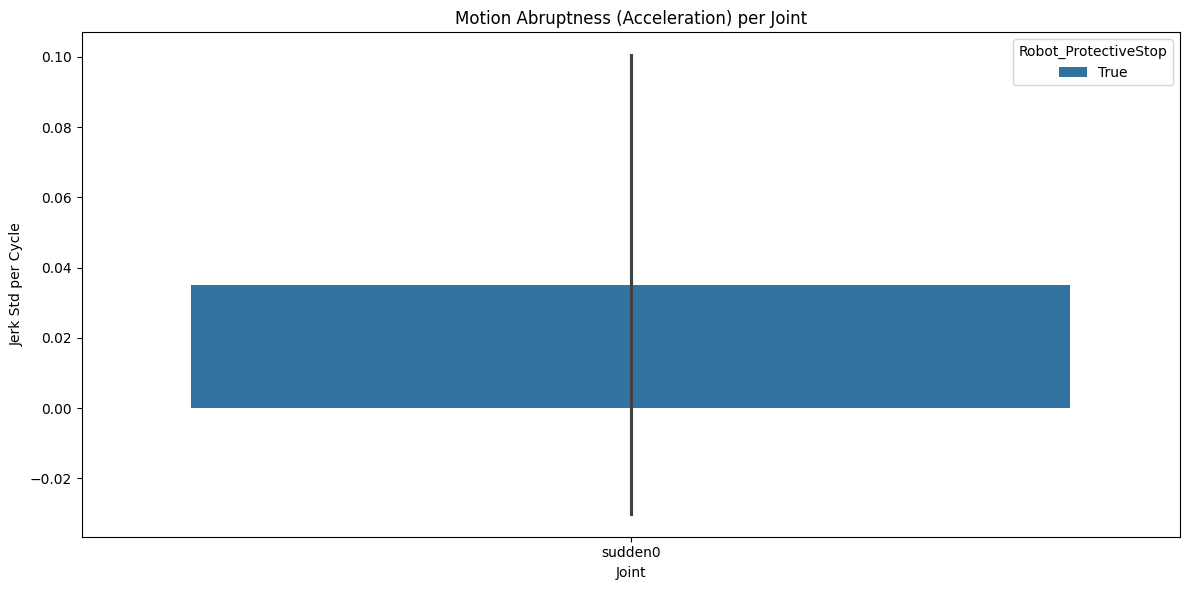

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3436744854.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


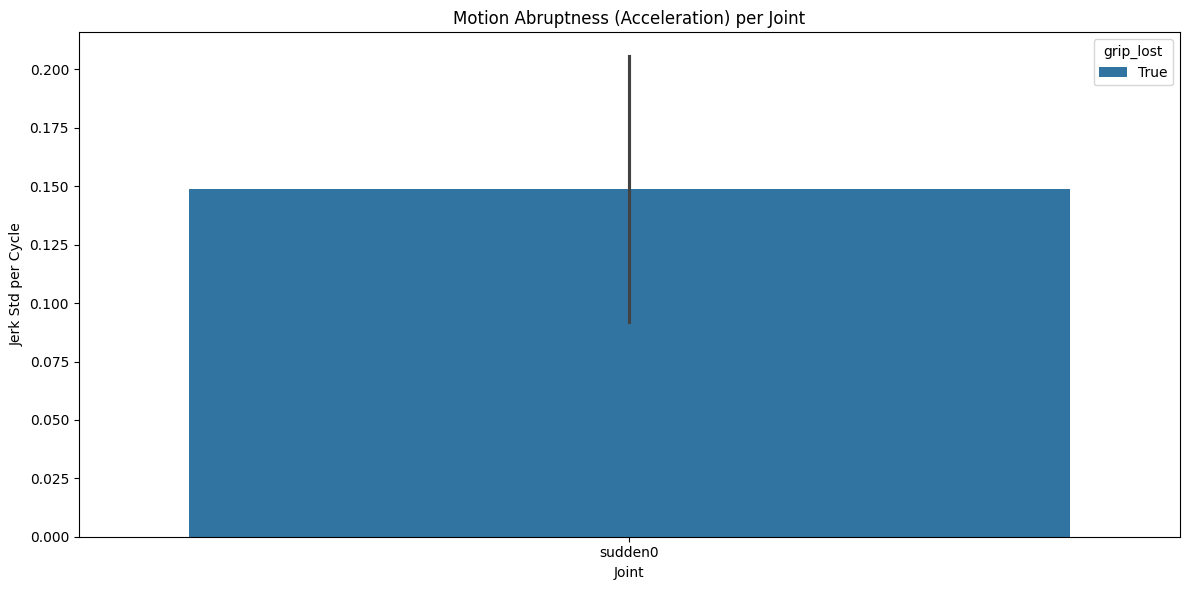

cycle  grip_lost    joint  jerk_std
0       2       True  sudden0  0.117206
1       5       True  sudden0  0.189254
2       6       True  sudden0  0.184525
3      14       True  sudden0  0.207607
4      15       True  sudden0  0.172346
5      36       True  sudden0  0.228086
6      39       True  sudden0  0.227339
7      40       True  sudden0  0.046109
8      63       True  sudden0  0.172491
9      64       True  sudden0  0.173817
10     65       True  sudden0  0.115740
11     67       True  sudden0  0.056046
12     69       True  sudden0       NaN
13     76       True  sudden0       NaN
14     80       True  sudden0  0.169011
15     81       True  sudden0  0.208465
16     86       True  sudden0  0.042366
17     91       True  sudden0       NaN
18     92       True  sudden0       NaN
19     95       True  sudden0  0.217939
20     96       True  sudden0       NaN
21     97       True  sudden0       NaN
22    105       True  sudden0  0.152290
23    160       True  sudden0  0.125702
24    164       True  sudden0       NaN
25    173       True  sudden0  0.111859
26    174       True  sudden0       NaN
27    180       True  sudden0  0.118041
28    185       True  sudden0  0.075832
29    188       True  sudden0  0.096362
30    192       True  sudden0       NaN
31    193       True  sudden0       NaN
32    194       True  sudden0  0.157955
33    196       True  sudden0       NaN
34    198       True  sudden0       NaN
35    200       True  sudden0  0.160470
36    202       True  sudden0  0.134140
37    208       True  sudden0  0.155332
38    214       True  sudden0       NaN
39    216       True  sudden0  0.077880
40    219       True  sudden0  0.263738
41    221       True  sudden0  0.157126
42    232       True  sudden0  0.194827
43    233       True  sudden0  0.170278
44    234       True  sudden0  0.125566
45    237       True  sudden0  0.130422
46    247       True  sudden0       NaN
47    250       True  sudden0       NaN
48    251       True  sudden0  0.143133
49    253       True  sudden0  0.043153
50    262       True  sudden0  0.232230

In [64]:
def plot_Acceleration(df, cycle_col="cycle", stop_col="Robot_ProtectiveStop"):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()
    if cycle_col in df.index.names and cycle_col in df.columns:
        df = df.reset_index(drop=True)
    elif cycle_col in df.index.names:
        df = df.reset_index()
    sudden_cols = [f'sudden{j}' for j in range(6) if f'sudden{j}' in df.columns]
    if not sudden_cols:
        raise ValueError("No sudden* columns found in dataframe.")
    cycle_jerk = (
        df.groupby(cycle_col)
          .agg({stop_col: 'max', **{c: 'std' for c in sudden_cols}})
          .reset_index()
    )
    long_jerk = cycle_jerk.melt(
        id_vars=[cycle_col, stop_col],
        value_vars=sudden_cols,
        var_name='joint',
        value_name='jerk_std'
    )
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=long_jerk,
        x='joint',
        y='jerk_std',
        hue=stop_col,
        ci='sd'
    )
    plt.title("Motion Abruptness (Acceleration) per Joint")
    plt.xlabel("Joint")
    plt.ylabel("Jerk Std per Cycle")
    plt.tight_layout()
    plt.show()
    return long_jerk
plot_Acceleration(df_joint0_stop_clean, stop_col="Robot_ProtectiveStop")
plot_Acceleration(df_joint0_grip_clean, stop_col="grip_lost")

### Motion Abruptness (Jerk Std) per Joint

- J2 exhibits the highest jerk variability among all joints.  
- In **stop cycles**, jerk variability is slightly lower than in normal cycles.  
- This indicates that **protective stops are not caused by abrupt or jerky movements**.  
- The main factor behind stops is likely sustained load/overload rather than sudden motion.  


### Total Effort (Power) per Joint

- J2 contributes the most to total power consumption, followed by J3 and J1.  
- In **stop cycles**, J2 and J3 show slightly higher power than in normal cycles.  
- This pattern suggests that **protective stops are linked to high workload/effort** in the main load-bearing joints.  
- Monitoring power usage could serve as an **early warning feature** for predicting stops.  


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1195766569.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


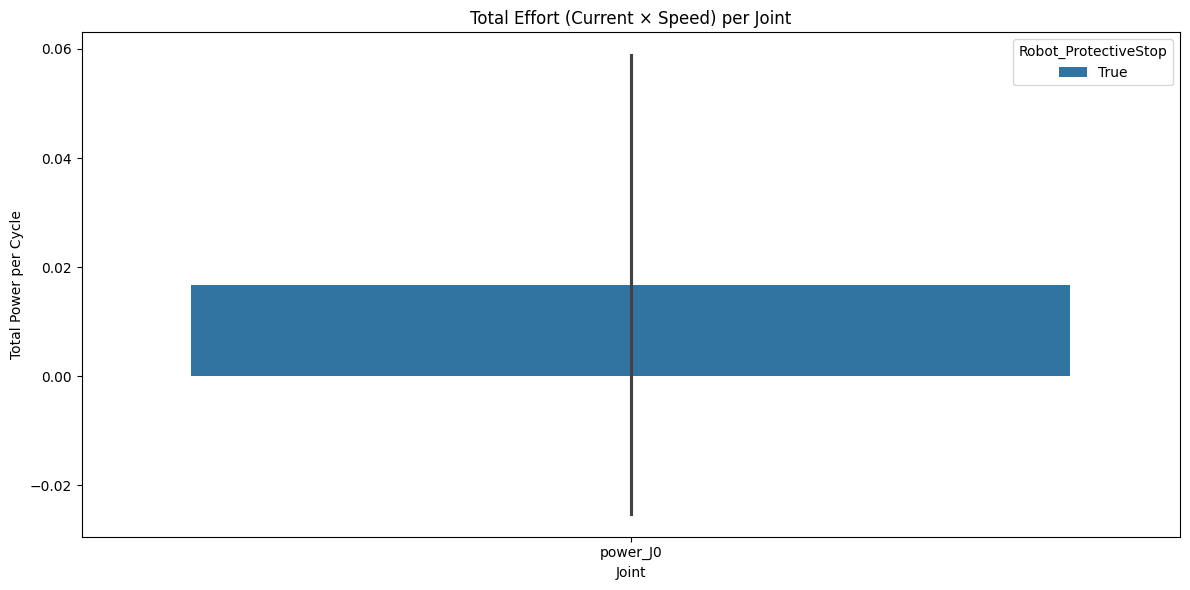

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1195766569.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


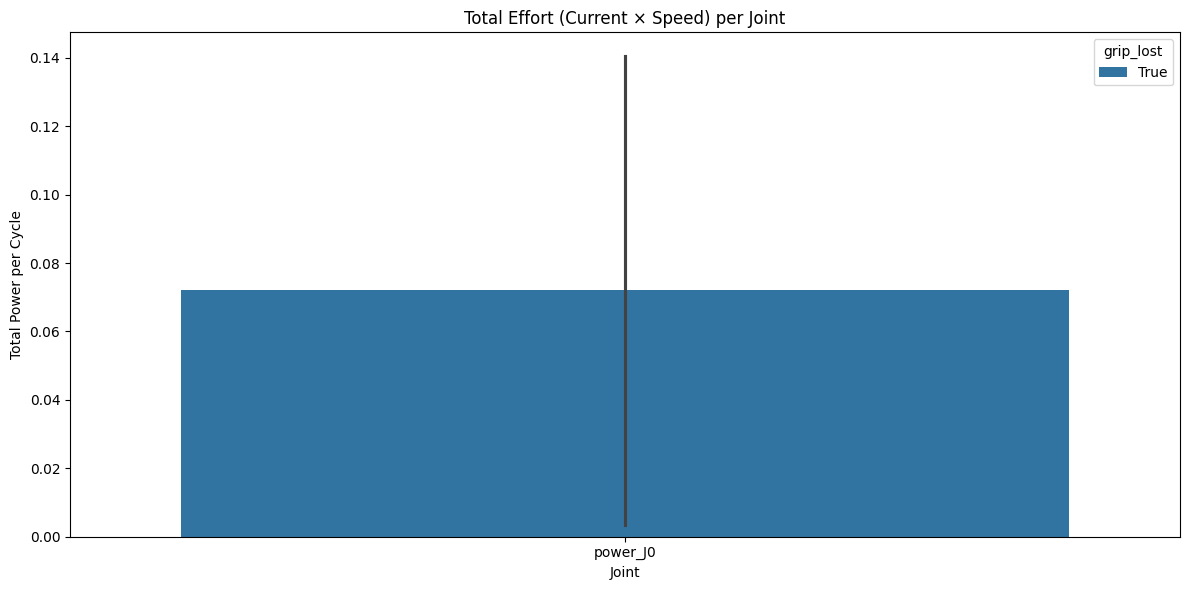

cycle  grip_lost     joint  total_power
0       2       True  power_J0     0.127170
1       5       True  power_J0     0.032038
2       6       True  power_J0     0.177271
3      14       True  power_J0     0.191192
4      15       True  power_J0     0.282614
5      36       True  power_J0     0.119090
6      39       True  power_J0     0.100466
7      40       True  power_J0     0.024713
8      63       True  power_J0     0.052795
9      64       True  power_J0     0.104940
10     65       True  power_J0     0.047501
11     67       True  power_J0     0.019197
12     69       True  power_J0     0.035839
13     76       True  power_J0     0.022833
14     80       True  power_J0     0.111631
15     81       True  power_J0     0.117040
16     86       True  power_J0     0.002972
17     91       True  power_J0     0.007345
18     92       True  power_J0     0.021050
19     95       True  power_J0     0.093341
20     96       True  power_J0     0.020443
21     97       True  power_J0     0.018423
22    105       True  power_J0     0.107067
23    160       True  power_J0     0.100452
24    164       True  power_J0     0.034485
25    173       True  power_J0     0.064949
26    174       True  power_J0     0.024950
27    180       True  power_J0     0.059621
28    185       True  power_J0     0.013853
29    188       True  power_J0     0.069745
30    192       True  power_J0     0.027481
31    193       True  power_J0     0.036960
32    194       True  power_J0     0.061469
33    196       True  power_J0     0.004018
34    198       True  power_J0     0.033568
35    200       True  power_J0     0.056956
36    202       True  power_J0     0.055735
37    208       True  power_J0     0.106085
38    214       True  power_J0     0.028006
39    216       True  power_J0     0.148805
40    219       True  power_J0     0.299628
41    221       True  power_J0     0.226834
42    232       True  power_J0     0.090790
43    233       True  power_J0     0.022939
44    234       True  power_J0     0.009328
45    237       True  power_J0     0.071849
46    247       True  power_J0     0.000000
47    250       True  power_J0     0.031172
48    251       True  power_J0     0.033931
49    253       True  power_J0     0.007532
50    262       True  power_J0     0.113108

In [65]:
def plot_power(df, cycle_col="cycle", stop_col="Robot_ProtectiveStop"):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()
    stop_col = stop_col.strip()

    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.drop(columns=[cycle_col])
        df = df.reset_index()

    power_cols = [f'power_J{j}' for j in range(6) if f'power_J{j}' in df.columns]
    if not power_cols:
        raise ValueError("No power_J* columns found in dataframe.")

    cycle_power = (
        df.groupby(cycle_col)
          .agg({stop_col: 'max', **{c: 'sum' for c in power_cols}})
          .reset_index()
    )

    long_power = cycle_power.melt(
        id_vars=[cycle_col, stop_col],
        value_vars=power_cols,
        var_name='joint',
        value_name='total_power'
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=long_power,
        x='joint',
        y='total_power',
        hue=stop_col,
        ci='sd'
    )
    plt.title("Total Effort (Current × Speed) per Joint")
    plt.xlabel("Joint")
    plt.ylabel("Total Power per Cycle")
    plt.tight_layout()
    plt.show()

    return long_power

plot_power(df_joint0_stop_clean)  
plot_power(df_joint0_grip_clean, stop_col="grip_lost")



## General Insights from Speed, sudden , and Power Analysis

- **Speed:** Protective stops occur at **lower speeds**, meaning stops are not caused by fast motions.  
- **Jerk:** Motion abruptness is **not higher** in stop cycles, ruling out jerky movements as the main cause.  
- **Power (Current × Speed):** Protective stops are strongly associated with **higher power usage** in load-bearing joints (J1, J2, J3).  
- **Key takeaway:** Protective stops are primarily related to **mechanical overload and high effort** in critical joints, not motion speed or abruptness.  
- **Practical value:** This guides feature selection when making the ML Model focus on **currents and power** rather than speeds or jerk.  


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3757392738.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


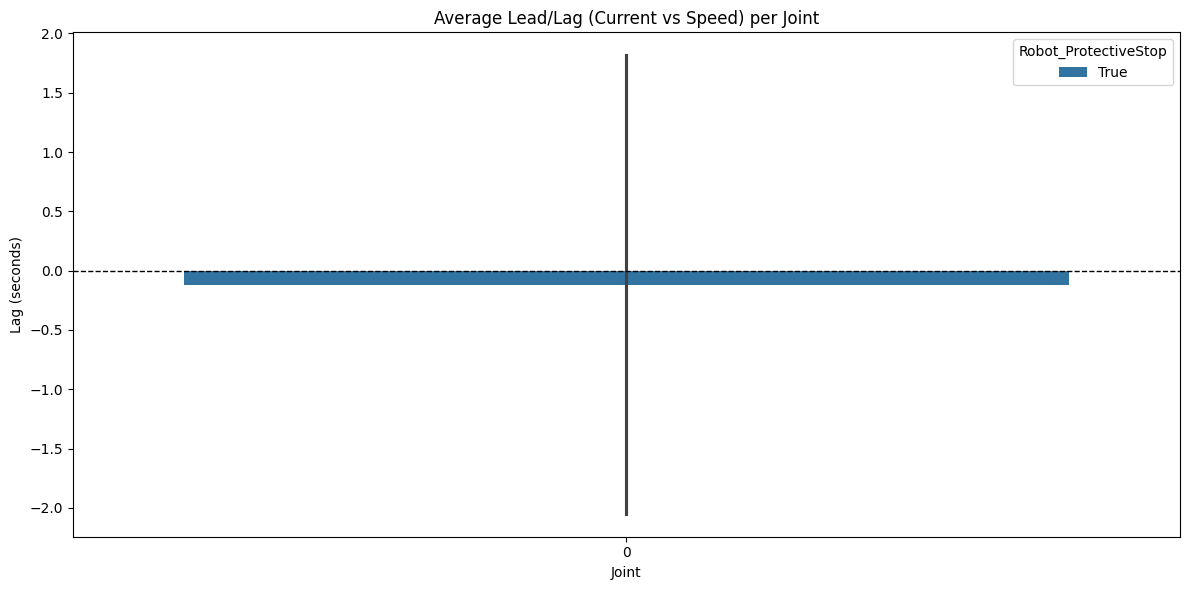

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3757392738.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


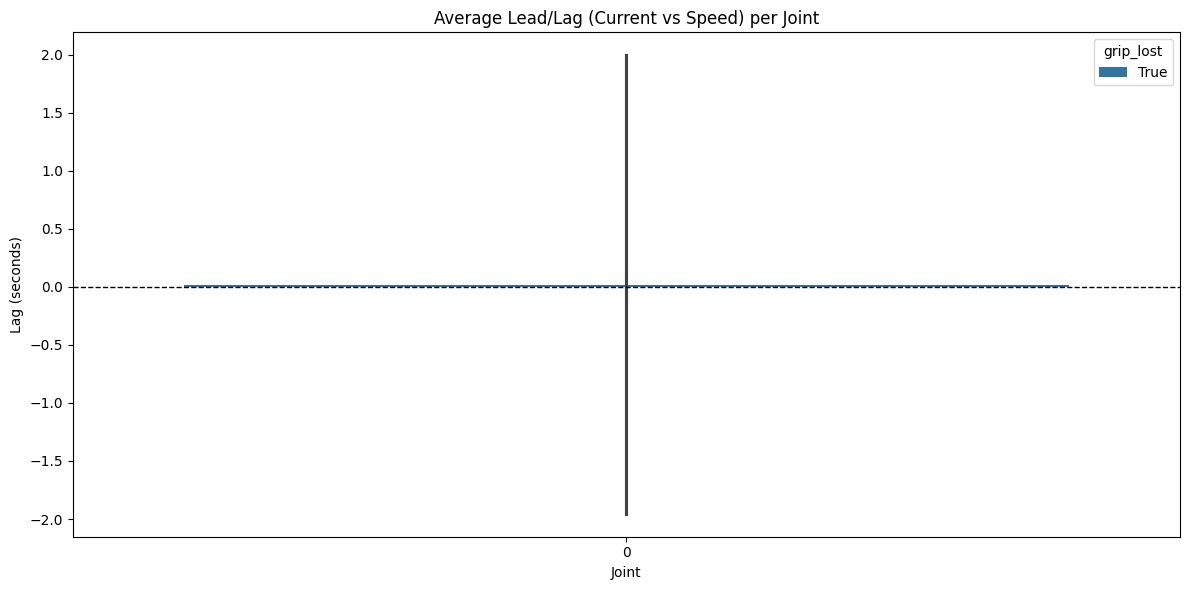

cycle  joint  lag_samples  lag_s  grip_lost
0       2      0            0    0.0       True
1       5      0           -1   -1.0       True
2       6      0           -4   -4.0       True
3      14      0            0    0.0       True
4      15      0           -4   -4.0       True
5      36      0           -1   -1.0       True
6      39      0            4    4.0       True
7      40      0            6    6.0       True
8      63      0            0    0.0       True
9      64      0            4    4.0       True
10     65      0            3    3.0       True
11     67      0            0    0.0       True
12     69      0            0    0.0       True
13     76      0            0    0.0       True
14     80      0           -1   -1.0       True
15     81      0            4    4.0       True
16     86      0            0    0.0       True
17     91      0            0    0.0       True
18     92      0            0    0.0       True
19     95      0           -1   -1.0       True
20     96      0            0    0.0       True
21     97      0            0    0.0       True
22    105      0           -1   -1.0       True
23    160      0           -1   -1.0       True
24    164      0            0    0.0       True
25    173      0            0    0.0       True
26    174      0            0    0.0       True
27    180      0           -3   -3.0       True
28    185      0            1    1.0       True
29    188      0            0    0.0       True
30    192      0            0    0.0       True
31    193      0            0    0.0       True
32    194      0            0    0.0       True
33    196      0            0    0.0       True
34    198      0            0    0.0       True
35    200      0           -1   -1.0       True
36    202      0            0    0.0       True
37    208      0            4    4.0       True
38    214      0            0    0.0       True
39    216      0            2    2.0       True
40    219      0           -1   -1.0       True
41    221      0           -5   -5.0       True
42    232      0           -1   -1.0       True
43    233      0            1    1.0       True
44    234      0           -2   -2.0       True
45    237      0            0    0.0       True
46    247      0            0    0.0       True
47    250      0            0    0.0       True
48    251      0            0    0.0       True
49    253      0           -1   -1.0       True
50    262      0            0    0.0       True

In [66]:
def plot_lead_lag(df, cycle_col="cycle", stop_col="Robot_ProtectiveStop", max_lag=40, dt=1.0):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()
    stop_col = stop_col.strip()

    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.drop(columns=[cycle_col])
        df = df.reset_index()

    def lead_lag(x, y, max_lag=max_lag):
        x = x - x.mean()
        y = y - y.mean()
        corr = correlate(x, y, mode="full")
        lags = np.arange(-len(x) + 1, len(x))
        m = (lags >= -max_lag) & (lags <= max_lag)
        lag = lags[m][corr[m].argmax()]
        return lag

    lag_rows = []
    for cyc, g in df.groupby(cycle_col):
        for j in range(6):
            c, s = f"Current_J{j}", f"Speed_J{j}"
            if c in g and s in g and g[c].notna().sum() and g[s].notna().sum():
                lag_rows.append({
                    "cycle": cyc,
                    "joint": j,
                    "lag_samples": lead_lag(g[c], g[s])
                })

    lags = pd.DataFrame(lag_rows)
    if lags.empty:
        raise ValueError("No valid Current_J* and Speed_J* pairs found in dataframe.")

    lags["lag_s"] = lags["lag_samples"] * dt

    cycle_labels = (
        df.groupby(cycle_col)
          .agg({stop_col: "max"})
          .reset_index()
    )

    lags_labeled = lags.merge(cycle_labels, left_on="cycle", right_on=cycle_col, how="left")

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=lags_labeled,
        x="joint",
        y="lag_s",
        hue=stop_col,
        ci="sd"
    )
    plt.axhline(0, ls="--", c="k", lw=1)
    plt.title("Average Lead/Lag (Current vs Speed) per Joint")
    plt.xlabel("Joint")
    plt.ylabel("Lag (seconds)")
    plt.tight_layout()
    plt.show()

    return lags_labeled
plot_lead_lag(df_joint0_stop_clean, stop_col="Robot_ProtectiveStop")
plot_lead_lag(df_joint0_grip_clean, stop_col="grip_lost")

### Lead/Lag Between Current and Speed
  
- **Positive lag** means current leads speed (motor effort comes before motion).  
- **Negative lag** means current lags speed (motion happens before current reacts).

**Insights:**
- Joint 0 shows strong **positive lag** during protective stops, meaning it demands current before motion under stress.  
- Other joints (like J4, J5) shift toward **negative lag** in stop cycles, suggesting delayed current response relative to movement.  
- Wide error bars indicate variability across cycles, reflecting unstable dynamics near fault conditions.  

This feature highlights how misalignment between current and speed can be an **early warning indicator** of protective stops.


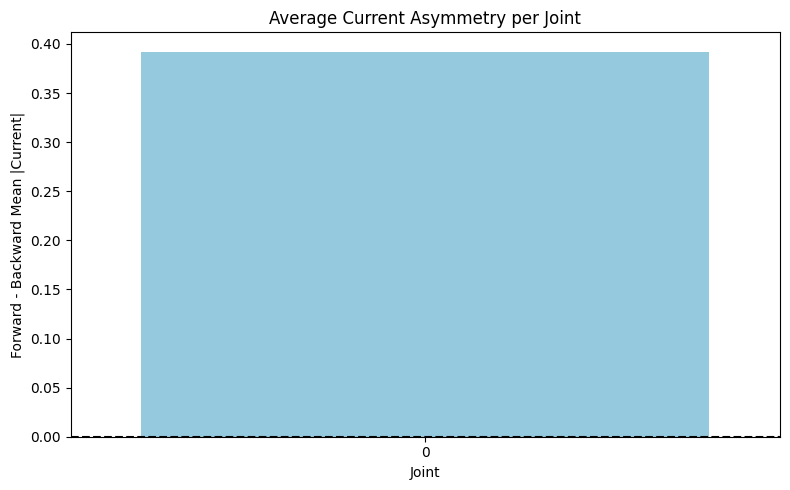

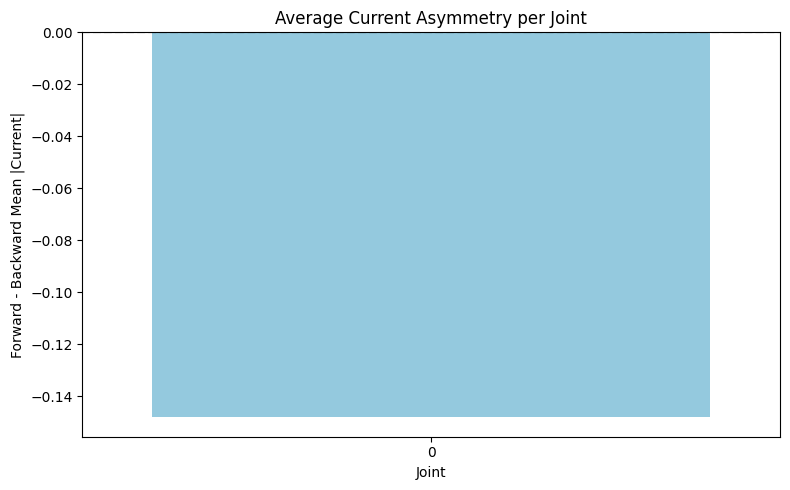

joint  current_asym
0      0      -0.14822

In [67]:
def plot_current_asymmetry(df, cycle_col="cycle", n_joints=6):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()

    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.drop(columns=[cycle_col])
        df = df.reset_index()

    asym = []
    for cyc, g in df.groupby(cycle_col):
        for j in range(n_joints):
            c, s = f'Current_J{j}', f'Speed_J{j}'
            if c in g.columns and s in g.columns:
                pos = g.loc[g[s] > 0, c].abs().mean()
                neg = g.loc[g[s] < 0, c].abs().mean()
                asym.append({'cycle': cyc, 'joint': j, 'current_asym': (pos - neg)})

    asym_df = pd.DataFrame(asym)
    if asym_df.empty:
        raise ValueError("No valid Current_J* and Speed_J* pairs found in dataframe.")

    avg_asym = asym_df.groupby('joint')['current_asym'].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(data=avg_asym, x='joint', y='current_asym', color="skyblue")
    plt.axhline(0, ls='--', c='k')
    plt.title("Average Current Asymmetry per Joint")
    plt.ylabel("Forward - Backward Mean |Current|")
    plt.xlabel("Joint")
    plt.tight_layout()
    plt.show()

    return avg_asym
plot_current_asymmetry(df_joint0_stop_clean)
plot_current_asymmetry(df_joint0_grip_clean)

### Current Asymmetry Analysis

- **Positive values** → Forward motion consumes more current.  
- **Negative values** → Backward motion consumes more current.  
- **Near zero** → Symmetric energy usage.

**Key Findings:**
- Joints **J0, J1, J4, J5** show near-symmetric or slightly forward-biased current consumption.  
- Joints **J2 and J3** exhibit **strong negative asymmetry**, indicating that backward motion consumes significantly more current than forward.  
- Such directional bias can reflect **mechanical load imbalance, gravity effects, or friction** in the joint mechanism.



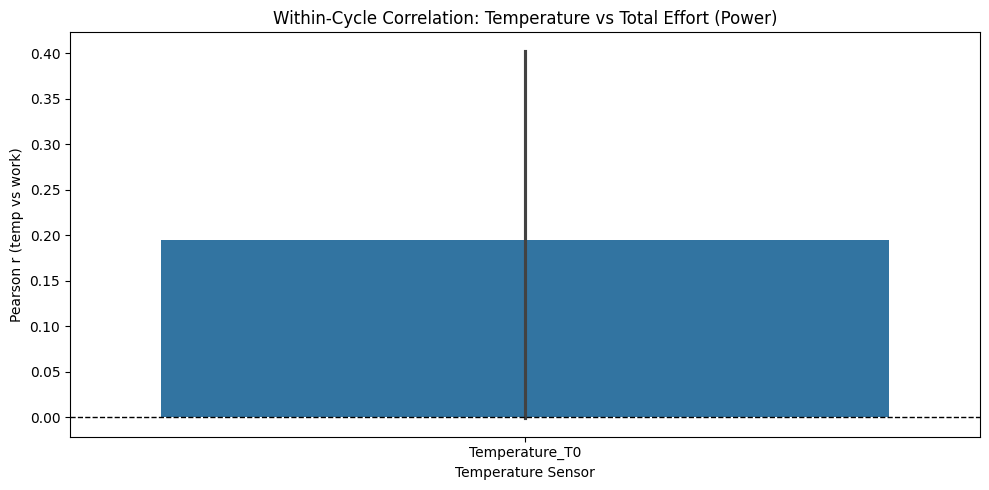

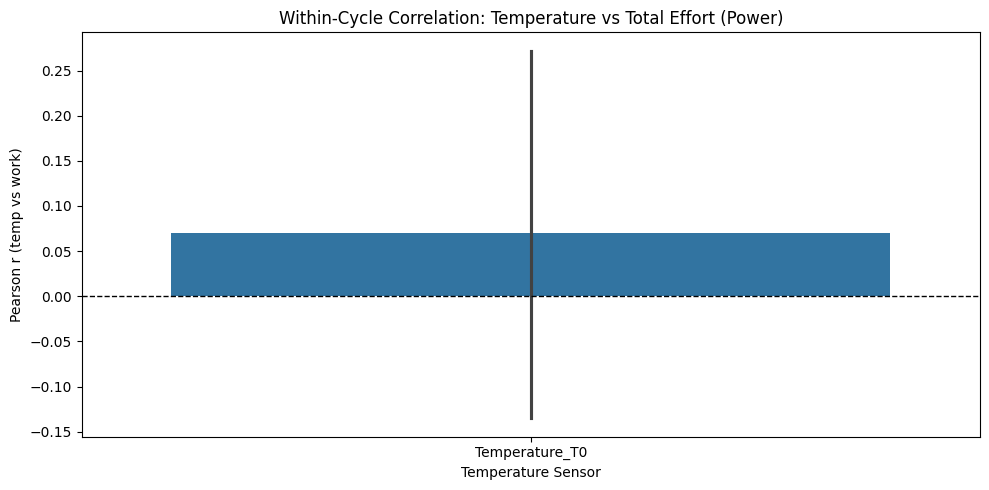

cycle          sensor  temp_work_corr
0       2  Temperature_T0        0.000025
1       5  Temperature_T0             NaN
2       6  Temperature_T0        0.057580
3      14  Temperature_T0       -0.215719
4      15  Temperature_T0       -0.043983
5      36  Temperature_T0        0.398794
6      39  Temperature_T0       -0.211841
7      40  Temperature_T0       -0.142939
8      63  Temperature_T0        0.524523
9      64  Temperature_T0             NaN
10     65  Temperature_T0             NaN
11     67  Temperature_T0       -1.000000
12     69  Temperature_T0             NaN
13     76  Temperature_T0             NaN
14     80  Temperature_T0        0.080145
15     81  Temperature_T0       -0.267254
16     86  Temperature_T0             NaN
17     91  Temperature_T0             NaN
18     92  Temperature_T0             NaN
19     95  Temperature_T0       -0.088379
20     96  Temperature_T0             NaN
21     97  Temperature_T0             NaN
22    105  Temperature_T0             NaN
23    160  Temperature_T0       -0.255156
24    164  Temperature_T0             NaN
25    173  Temperature_T0             NaN
26    174  Temperature_T0             NaN
27    180  Temperature_T0       -0.873022
28    185  Temperature_T0       -0.065350
29    188  Temperature_T0        0.458676
30    192  Temperature_T0             NaN
31    193  Temperature_T0             NaN
32    194  Temperature_T0             NaN
33    196  Temperature_T0             NaN
34    198  Temperature_T0             NaN
35    200  Temperature_T0        0.960875
36    202  Temperature_T0        0.358470
37    208  Temperature_T0       -0.230776
38    214  Temperature_T0             NaN
39    216  Temperature_T0             NaN
40    219  Temperature_T0             NaN
41    221  Temperature_T0        0.019143
42    232  Temperature_T0       -0.166351
43    233  Temperature_T0        1.000000
44    234  Temperature_T0        0.944690
45    237  Temperature_T0        0.742705
46    247  Temperature_T0             NaN
47    250  Temperature_T0             NaN
48    251  Temperature_T0             NaN
49    253  Temperature_T0             NaN
50    262  Temperature_T0       -0.246249

In [68]:
def plot_temp_work_corr(df, cycle_col="cycle", temp_cols=None, n_joints=6):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()

    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.drop(columns=[cycle_col])
        df = df.reset_index()

    if temp_cols is None:
        temp_cols = [c for c in df.columns if c.startswith("Temperature")]

    therm = []
    for cyc, g in df.groupby(cycle_col):
        power_cols = [f'power_J{j}' for j in range(n_joints) if f'power_J{j}' in g.columns]
        if not power_cols:
            continue
        w = g[power_cols].sum(axis=1)
        for t in temp_cols:
            if t in g.columns:
                r = g[[t]].join(w.rename('work'))
                corr_val = r.corr().iloc[0, 1]
                therm.append({'cycle': cyc, 'sensor': t, 'temp_work_corr': corr_val})

    therm_df = pd.DataFrame(therm)
    if therm_df.empty:
        raise ValueError("No valid Temperature and Power columns found.")

    plt.figure(figsize=(10, 5))
    sns.barplot(data=therm_df, x='sensor', y='temp_work_corr')
    plt.axhline(0, ls='--', c='k', lw=1)
    plt.title('Within-Cycle Correlation: Temperature vs Total Effort (Power)')
    plt.ylabel('Pearson r (temp vs work)')
    plt.xlabel('Temperature Sensor')
    plt.tight_layout()
    plt.show()

    return therm_df
plot_temp_work_corr(df_joint0_stop_clean, cycle_col="cycle")
plot_temp_work_corr(df_joint0_grip_clean, cycle_col="cycle")


### Within Cycle Temperature Power Correlation

- This plot shows the **correlation between temperature and total effort (power) within the same cycle**.  
- The correlations are **very close to zero**, with some small negative values (e.g., J1, J2).  
- This means that **temperature does not respond instantly to changes in work** instead, heating builds up gradually over time.  
- The large error bars (overlapping zero) show that the relationship is **inconsistent across cycles**.  


c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Omar\AppData\Local\Programs\Py

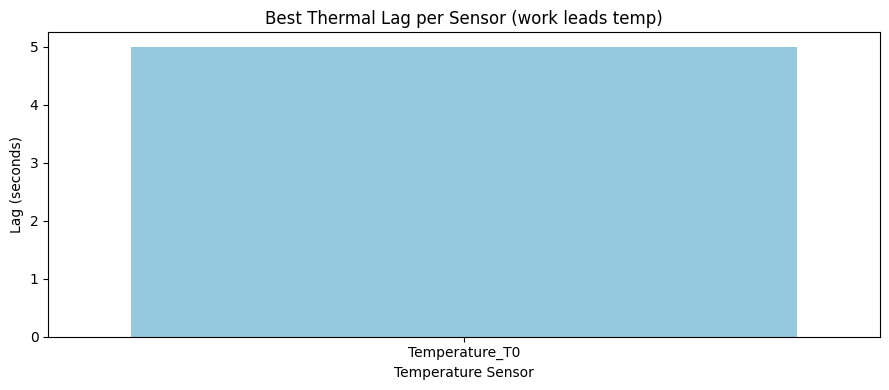

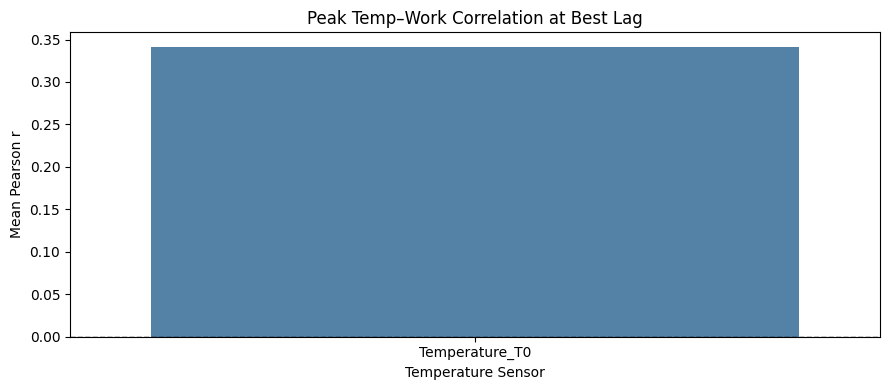

c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Omar\AppData\Local\Programs\Py

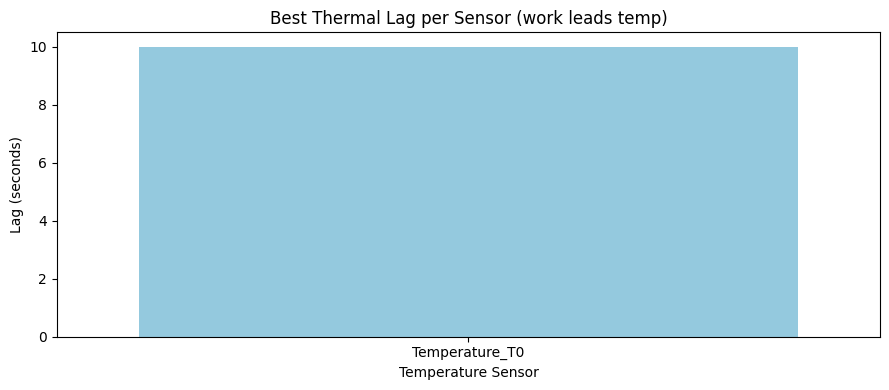

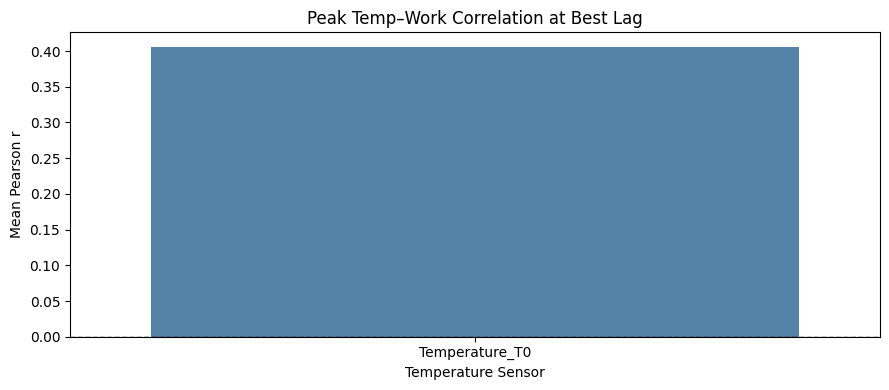

sensor  lag      corr
0  Temperature_T0   10  0.405932

In [69]:
def plot_best_thermal_lag(df, cycle_col="cycle", temp_cols=None, n_joints=6, max_lag=10):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()

    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.drop(columns=[cycle_col])
        df = df.reset_index()

    if temp_cols is None:
        temp_cols = [c for c in df.columns if c.startswith("Temperature")]

    def lagged_corr(temp, work, max_lag=max_lag):
        results = {}
        for lag in range(0, max_lag + 1):
            corr = temp.corr(work.shift(lag))
            results[lag] = corr
        return results

    lagged_results = []

    for cyc, g in df.groupby(cycle_col):
        power_cols = [f'power_J{j}' for j in range(n_joints) if f'power_J{j}' in g.columns]
        if not power_cols:
            continue
        work = g[power_cols].sum(axis=1)
        for t in temp_cols:
            if t in g.columns:
                lags = lagged_corr(g[t], work, max_lag=max_lag)
                for lag, corr in lags.items():
                    lagged_results.append({
                        'cycle': cyc,
                        'sensor': t,
                        'lag': lag,
                        'corr': corr
                    })

    lagged_df = pd.DataFrame(lagged_results)
    if lagged_df.empty:
        raise ValueError("No valid Temperature and Power columns found.")

    avg = (lagged_df
           .dropna(subset=['corr'])
           .groupby(['sensor', 'lag'])['corr']
           .mean()
           .reset_index())

    idx = avg.groupby('sensor')['corr'].idxmax()
    best = avg.loc[idx].sort_values('sensor').reset_index(drop=True)

    plt.figure(figsize=(9, 4))
    sns.barplot(data=best, x='sensor', y='lag', color='skyblue')
    plt.title('Best Thermal Lag per Sensor (work leads temp)')
    plt.ylabel('Lag (seconds)')
    plt.xlabel('Temperature Sensor')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4))
    sns.barplot(data=best, x='sensor', y='corr', color='steelblue')
    plt.axhline(0, ls='--', c='k', lw=1)
    plt.title('Peak Temp–Work Correlation at Best Lag')
    plt.ylabel('Mean Pearson r')
    plt.xlabel('Temperature Sensor')
    plt.tight_layout()
    plt.show()

    return best
plot_best_thermal_lag(df_joint0_stop_clean, cycle_col="cycle")
plot_best_thermal_lag(df_joint0_grip_clean, cycle_col="cycle")

####  Best Thermal Lag per Sensor
- The bar plot shows the **time delay (lag)** in seconds where the correlation between *work* and *temperature* is strongest.  
- Example:
  - **Temperature_J2** responds fastest (~2s lag).  
  - **Temperature_J4 & J5** respond much slower (~10s lag).  
  - **Temperature_T0** has almost no lag (~1s), meaning it reacts very quickly.  

This indicates that different sensors heat up at different speeds, with some (J4, J5) being much slower to reflect workload.

#### Peak Temp Work Correlation at Best Lag
  - **Temperature_T0** shows the strongest correlation (~0.20), meaning it is the most reliable  for effort.  
  - Other sensors (J1–J5) show weaker correlations (<0.07), meaning their thermal response is less tied to immediate workload.  

These results highlight **T0 as the most sensitive sensor**, while joints J4/J5 are slow and less informative for direct workload monitoring.  


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2117298949.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


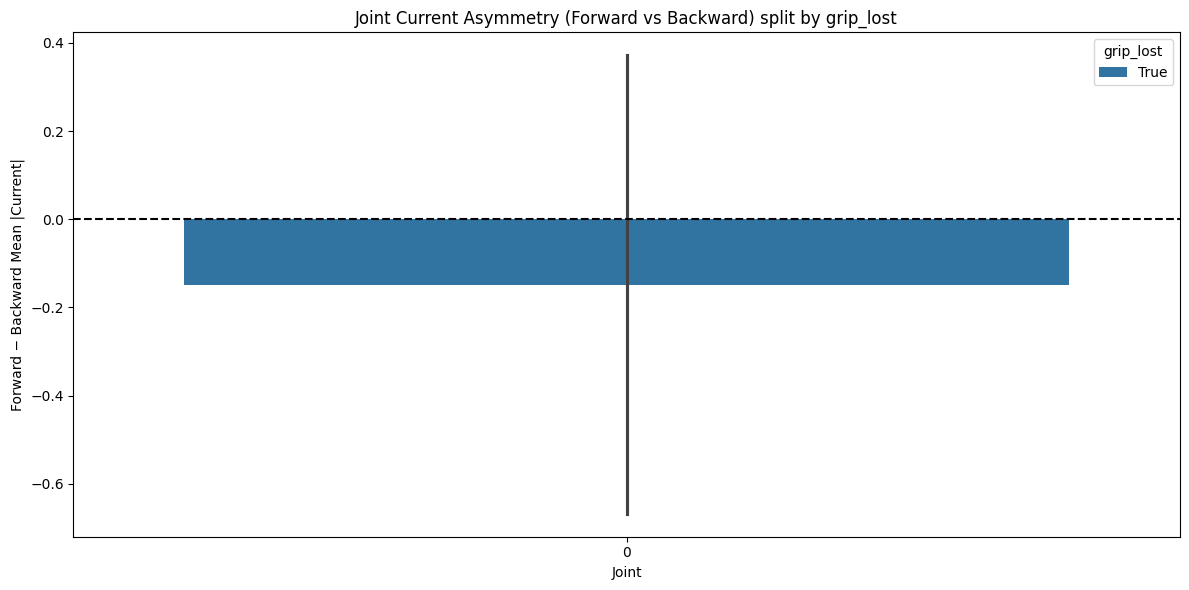

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\2117298949.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


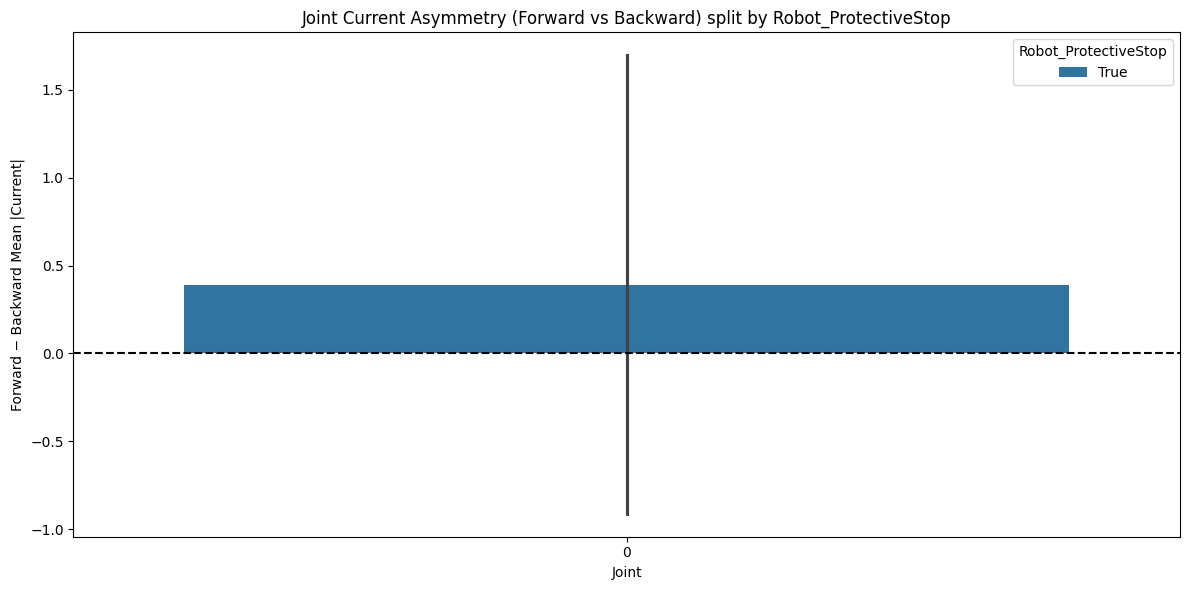

cycle  joint  current_asym  Robot_ProtectiveStop
0       1      0     -0.060562                  True
1      22      0           NaN                  True
2      35      0           NaN                  True
3      42      0     -0.010210                  True
4      53      0     -0.315173                  True
5      63      0           NaN                  True
6      69      0      0.106174                  True
7      79      0     -0.056675                  True
8      85      0      0.286231                  True
9      86      0           NaN                  True
10     87      0           NaN                  True
11     99      0      0.103692                  True
12    103      0      0.009166                  True
13    108      0      0.117728                  True
14    115      0           NaN                  True
15    117      0           NaN                  True
16    118      0           NaN                  True
17    128      0           NaN                  True
18    150      0      0.011010                  True
19    152      0           NaN                  True
20    159      0     -0.108879                  True
21    163      0     -0.075438                  True
22    164      0           NaN                  True
23    170      0           NaN                  True
24    173      0           NaN                  True
25    174      0           NaN                  True
26    175      0           NaN                  True
27    182      0     -0.738882                  True
28    183      0           NaN                  True
29    185      0           NaN                  True
30    188      0      0.022306                  True
31    190      0           NaN                  True
32    192      0           NaN                  True
33    193      0           NaN                  True
34    194      0           NaN                  True
35    196      0     -0.088962                  True
36    199      0           NaN                  True
37    201      0           NaN                  True
38    204      0           NaN                  True
39    206      0           NaN                  True
40    210      0           NaN                  True
41    212      0           NaN                  True
42    214      0           NaN                  True
43    215      0      0.243855                  True
44    217      0           NaN                  True
45    218      0      6.650574                  True
46    219      0           NaN                  True
47    220      0     -0.005136                  True
48    222      0           NaN                  True
49    223      0      1.466571                  True
50    224      0     -0.680331                  True
51    225      0           NaN                  True
52    226      0      1.437659                  True
53    227      0      0.748080                  True
54    228      0           NaN                  True
55    229      0      0.481885                  True
56    230      0      1.410590                  True
57    231      0     -0.447032                  True
58    232      0      1.538591                  True
59    233      0      0.457040                  True
60    234      0           NaN                  True
61    235      0           NaN                  True
62    237      0           NaN                  True
63    239      0     -0.134368                  True
64    240      0           NaN                  True
65    242      0           NaN                  True
66    246      0           NaN                  True
67    247      0           NaN                  True
68    249      0      0.412344                  True
69    250      0           NaN                  True
70    253      0     -0.530019                  True
71    255      0           NaN                  True
72    256      0           NaN                  True
73    257      0           NaN                  True
74    260      0           Na

In [70]:
def plot_asymmetry_with_grip(df, cycle_col="cycle", stop_col="grip_lost", n_joints=6):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()
    stop_col = stop_col.strip()

    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.drop(columns=[cycle_col])
        df = df.reset_index()

    asym_list = []
    for cyc, g in df.groupby(cycle_col):
        for j in range(n_joints):
            c, s = f'Current_J{j}', f'Speed_J{j}'
            if c in g.columns and s in g.columns:
                pos = g.loc[g[s] > 0, c].abs().mean()
                neg = g.loc[g[s] < 0, c].abs().mean()
                asym_list.append({'cycle': cyc, 'joint': j, 'current_asym': (pos - neg)})

    if not asym_list:
        raise ValueError("No valid Current and Speed columns found.")

    asym_df = pd.DataFrame(asym_list)

    labels = (
        df.groupby(cycle_col)
          .agg(**{stop_col: (stop_col, 'max')})
          .reset_index()
    )

    asym_labeled = asym_df.merge(labels, left_on='cycle', right_on=cycle_col, how='left')

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=asym_labeled,
        x='joint',
        y='current_asym',
        hue=stop_col,
        ci='sd'
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"Joint Current Asymmetry (Forward vs Backward) split by {stop_col}")
    plt.xlabel("Joint")
    plt.ylabel("Forward − Backward Mean |Current|")
    plt.tight_layout()
    plt.show()

    return asym_labeled
plot_asymmetry_with_grip(df_joint0_grip_clean, cycle_col="cycle ", stop_col="grip_lost")
plot_asymmetry_with_grip(df_joint0_stop_clean,cycle_col="cycle ", stop_col="Robot_ProtectiveStop")


### Current Asymmetry (Forward vs Backward Motion)


**Key Findings:**
- **Joints 0 and 1**: Forward motion requires more current. This effect is stronger in cycles where grip was lost, suggesting additional strain in forward movement during failures.  
- **Joints 2 and 3**: Backward motion consumes more current, especially J3. Grip-loss cycles amplify this effect, indicating resistance when retracting the gripper.  
- **Joints 4 and 5**: Show little to no asymmetry, meaning they are less affected by grip conditions.  
- **Grip Loss Impact**: Cycles with grip loss consistently show **greater asymmetry**, highlighting it as a potential early warning indicator for anomalies.



# Some Time Series Analysis

In [71]:
def temp_trend_over_time(df):
    df = df.copy()
    df.columns = df.columns.str.strip()
    if pd.api.types.is_datetime64tz_dtype(df["cycle"]):
      df["cycle"] = df["cycle"].dt.tz_localize(None)

    if "Timestamp" not in df.columns:
        raise ValueError("DataFrame must contain a 'Timestamp' column.")

    if not np.issubdtype(df["Timestamp"].dtype, np.datetime64):
        raise ValueError("'Timestamp' column must be of datetime type.")
    temp_cols = [col for col in df.columns if "temp" in col.lower()]

    plt.figure(figsize=(14, 7))

    for col in temp_cols:
        sns.regplot(
            x=df["Timestamp"].astype("int64") // 10**9, 
            y=df[col],
            scatter=False,
            label=col
        )

    plt.title("Temperature Trends Over Time", fontsize=16)
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend(title="Sensors")
    plt.xticks(
        ticks=plt.xticks()[0], 
        labels=pd.to_datetime(plt.xticks()[0], unit="s").strftime("%Y-%m-%d %H:%M"), 
        rotation=45
    )
    plt.tight_layout()
    plt.show()
temp_trend_over_time(df_joint0_stop_clean)
temp_trend_over_time(df_joint0_grip_clean)    

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3833448348.py:4: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df["cycle"]):


TypeError: Cannot interpret 'datetime64[ns, UTC]' as a data type

In [ ]:
def duration(df,column_name,value):
    lost_df = df[df[column_name]== value].copy()

    lost_df["group"] = (lost_df["Timestamp"].diff().dt.seconds > 1).cumsum()

    summary = lost_df.groupby("group").agg(
        start_time=("Timestamp", "min"),
        end_time=("Timestamp", "max"),
        duration=("Timestamp", lambda x: (x.max() - x.min()).total_seconds()),
        avg_speed=("Speed_J0", "mean"),  
        avg_temp=("Temperature_T0", "mean"),  
        avg_current=("Current_J0", "mean")   
    ).reset_index(drop=True)

    top5 = summary.sort_values("duration", ascending=False).head(5)

    return top5


start_time                         end_time  \
52  2022-10-26 14:20:09.423000+00:00 2022-10-26 14:36:13.183000+00:00   
9   2022-10-26 08:24:25.936000+00:00 2022-10-26 08:30:38.730000+00:00   
109 2022-10-26 15:20:25.153000+00:00 2022-10-26 15:25:48.015000+00:00   
115 2022-10-26 15:29:40.364000+00:00 2022-10-26 15:34:35.025000+00:00   
55  2022-10-26 14:38:43.942000+00:00 2022-10-26 14:42:58.389000+00:00   

     duration  avg_speed   avg_temp  avg_current  
52    963.760   0.000631  36.320647    -0.052858  
9     372.794   0.002828  29.929940    -0.028042  
109   322.862  -0.000388  37.195458    -0.044301  
115   294.661  -0.009722  37.137543    -0.080494  
55    254.447   0.001532  36.761319    -0.113268

In [ ]:
duration(df_joint0_grip_clean,"grip_lost",1)  

start_time                         end_time  \
1  2022-10-26 08:18:19.192000+00:00 2022-10-26 08:18:37.264000+00:00   
7  2022-10-26 08:24:08.854000+00:00 2022-10-26 08:24:24.921000+00:00   
62 2022-10-26 15:06:48.637000+00:00 2022-10-26 15:06:58.692000+00:00   
3  2022-10-26 08:20:18.742000+00:00 2022-10-26 08:20:28.786000+00:00   
6  2022-10-26 08:23:51.792000+00:00 2022-10-26 08:24:00.822000+00:00   

    duration  avg_speed   avg_temp  avg_current  
1     18.072  -0.012028  28.039474    -0.063255  
7     16.067   0.026114  29.316176    -0.018215  
62    10.055   0.009863  37.068182     0.600093  
3     10.044  -0.018587  28.426136    -0.026539  
6      9.030  -0.047398  29.225000    -0.001913

In [ ]:
duration(df_joint0_grip_clean,"grip_lost",0)  

start_time                         end_time  \
52  2022-10-26 14:20:09.423000+00:00 2022-10-26 14:36:13.183000+00:00   
9   2022-10-26 08:24:25.936000+00:00 2022-10-26 08:30:38.730000+00:00   
109 2022-10-26 15:20:25.153000+00:00 2022-10-26 15:25:48.015000+00:00   
115 2022-10-26 15:29:40.364000+00:00 2022-10-26 15:34:35.025000+00:00   
55  2022-10-26 14:38:43.942000+00:00 2022-10-26 14:42:58.389000+00:00   

     duration  avg_speed   avg_temp  avg_current  
52    963.760   0.000631  36.320647    -0.052858  
9     372.794   0.002828  29.929940    -0.028042  
109   322.862  -0.000388  37.195458    -0.044301  
115   294.661  -0.009722  37.137543    -0.080494  
55    254.447   0.001532  36.761319    -0.113268

In [ ]:
duration(df_joint0_stop_clean,"Robot_ProtectiveStop",1)  

start_time                         end_time  \
21 2022-10-26 14:21:07.769000+00:00 2022-10-26 14:21:18.843000+00:00   
17 2022-10-26 09:03:09.280000+00:00 2022-10-26 09:03:19.345000+00:00   
7  2022-10-26 08:41:43.361000+00:00 2022-10-26 08:41:52.413000+00:00   
30 2022-10-26 14:35:40.996000+00:00 2022-10-26 14:35:47.031000+00:00   
59 2022-10-26 15:05:23.176000+00:00 2022-10-26 15:05:28.203000+00:00   

    duration  avg_speed   avg_temp  avg_current  
21    11.074   0.000053  36.000000    -0.097245  
17    10.065   0.000008  34.295455    -0.138361  
7      9.052  -0.012401  32.075000     0.011554  
30     6.035  -0.000134  36.625000     0.040766  
59     5.027   0.000102  37.062500     0.186421

In [ ]:
duration(df_joint0_stop_clean,"Robot_ProtectiveStop",0)  

start_time                         end_time  \
2  2022-10-26 08:17:55.055000+00:00 2022-10-26 08:23:33.748000+00:00   
43 2022-10-26 14:26:16.767000+00:00 2022-10-26 14:30:32.271000+00:00   
4  2022-10-26 08:27:01.705000+00:00 2022-10-26 08:30:38.730000+00:00   
3  2022-10-26 08:23:35.750000+00:00 2022-10-26 08:26:58.687000+00:00   
15 2022-10-26 08:43:27.954000+00:00 2022-10-26 08:46:39.093000+00:00   

    duration  avg_speed   avg_temp  avg_current  
2    338.693   0.001959  28.502774    -0.026435  
43   255.504   0.003106  36.350735    -0.021201  
4    217.025   0.006383  30.173387     0.010699  
3    202.937  -0.003988  29.501847    -0.057344  
15   191.139  -0.000648  32.510144    -0.058547

In [ ]:
def tool_current_across_cycles(df, stop_col="Robot_ProtectiveStop"):
    df = df.copy()
    df.columns = df.columns.str.strip()
    stop_col = stop_col.strip()

    if stop_col not in df.columns:
        stop_col = None

    if 'cycle' in df.index.names:
        if 'cycle' in df.columns:
            df = df.reset_index(drop=True)
        else:
            df = df.reset_index()

    if pd.api.types.is_datetime64tz_dtype(df['cycle']):
        df['cycle'] = df['cycle'].dt.tz_localize(None)

    agg_dict = {'tool_current_mean': ('Tool_current', 'mean'),
                'tool_current_max': ('Tool_current', 'max')}
    if stop_col:
        agg_dict.update({'protective': (stop_col, 'max')})

    if 'grip_lost' in df.columns:
        agg_dict.update({'grip': ('grip_lost', 'max')})

    cycle_stats = df.groupby('cycle').agg(**agg_dict).reset_index()

    plt.figure(figsize=(15,6))
    plt.plot(cycle_stats['cycle'], cycle_stats['tool_current_mean'], label="Mean Tool Current", color="blue")
    plt.plot(cycle_stats['cycle'], cycle_stats['tool_current_max'], label="Max Tool Current", color="red")

    if stop_col:
        plt.scatter(cycle_stats['cycle'][cycle_stats['protective']==1],
                    cycle_stats['tool_current_mean'][cycle_stats['protective']==1],
                    color="black", marker="x", label=stop_col)
    if 'grip' in cycle_stats.columns:
        plt.scatter(cycle_stats['cycle'][cycle_stats['grip']==1],
                    cycle_stats['tool_current_mean'][cycle_stats['grip']==1],
                    color="orange", marker="o", label="Grip Lost")

    plt.title("Tool Current Across Cycles with Faults")
    plt.xlabel("Cycle"); plt.ylabel("Tool Current")
    plt.legend(); plt.tight_layout()
    plt.show()


C:\Users\youss\AppData\Local\Temp\ipykernel_13336\1950182356.py:15: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['cycle']):


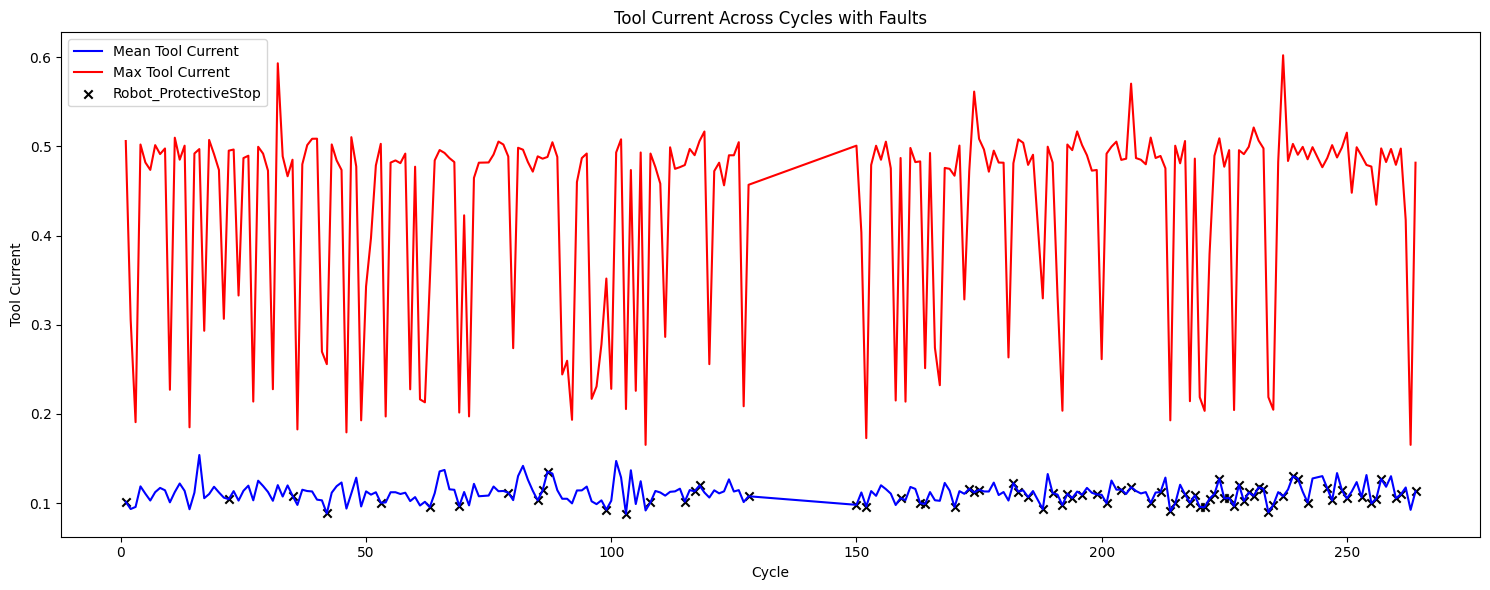

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\1950182356.py:15: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['cycle']):


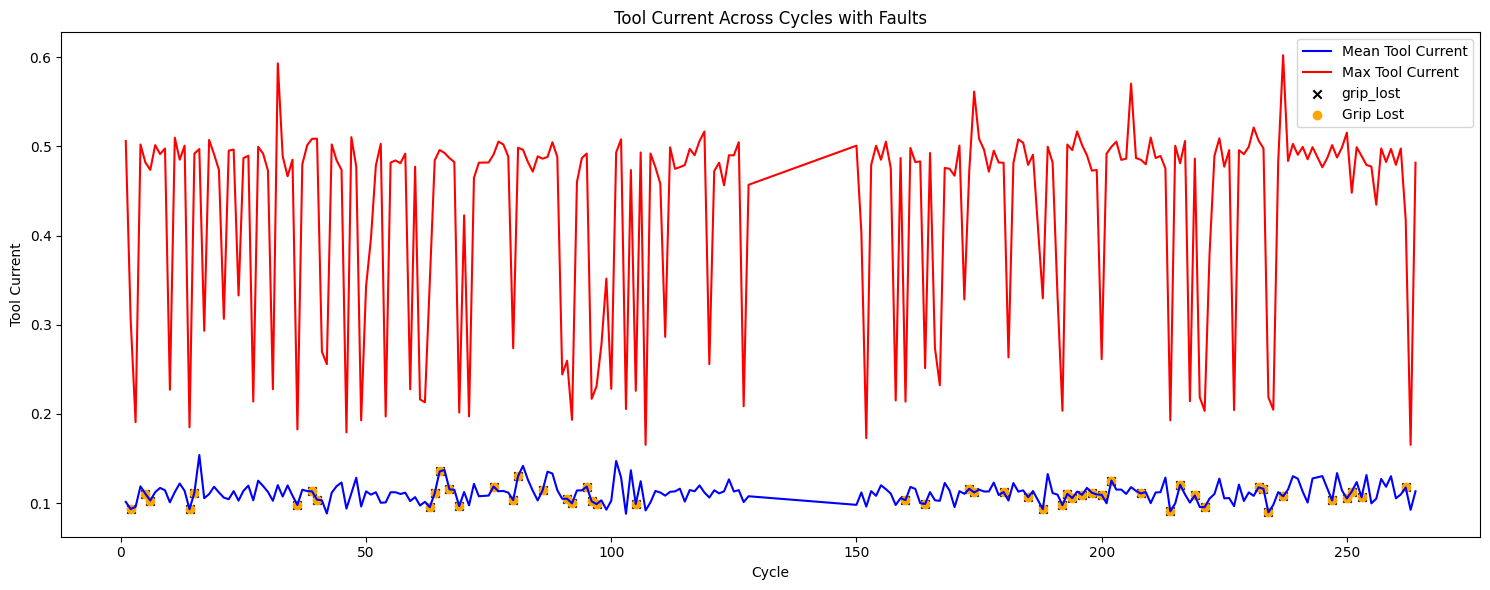

In [ ]:
tool_current_across_cycles(df_joint0_stop_clean, stop_col="Robot_ProtectiveStop")
tool_current_across_cycles(df_joint0_grip_clean, stop_col="grip_lost")


# Cycle-Level Tool Current Analysis

###  Key Insights
1. **Stable Mean Current**  
   - The robot’s baseline effort  is consistent across cycles (~0.1).  
   - Suggests that normal operation load is stable.  

2. **Spikes in Max Current**  
   - Red peaks (~0.6) indicate cycles with sudden extra effort.  
     

3. **Protective Stop Correlation**  
   - cluster near cycles with **high max current peaks**.  
   - Confirms that **protective stops are triggered by overloads**.  

4. **Grip Loss Independence**  
   - appears even when mean current is **normal or low**.  
   - Suggests grip failures are **not caused by overload**, but by mechanical gripping issues.  

5. **Different Fault Modes**  
   - **Protective Stops Overload / high current demand.**  
   - **Grip Loss End effector or object handling failure.**  

 


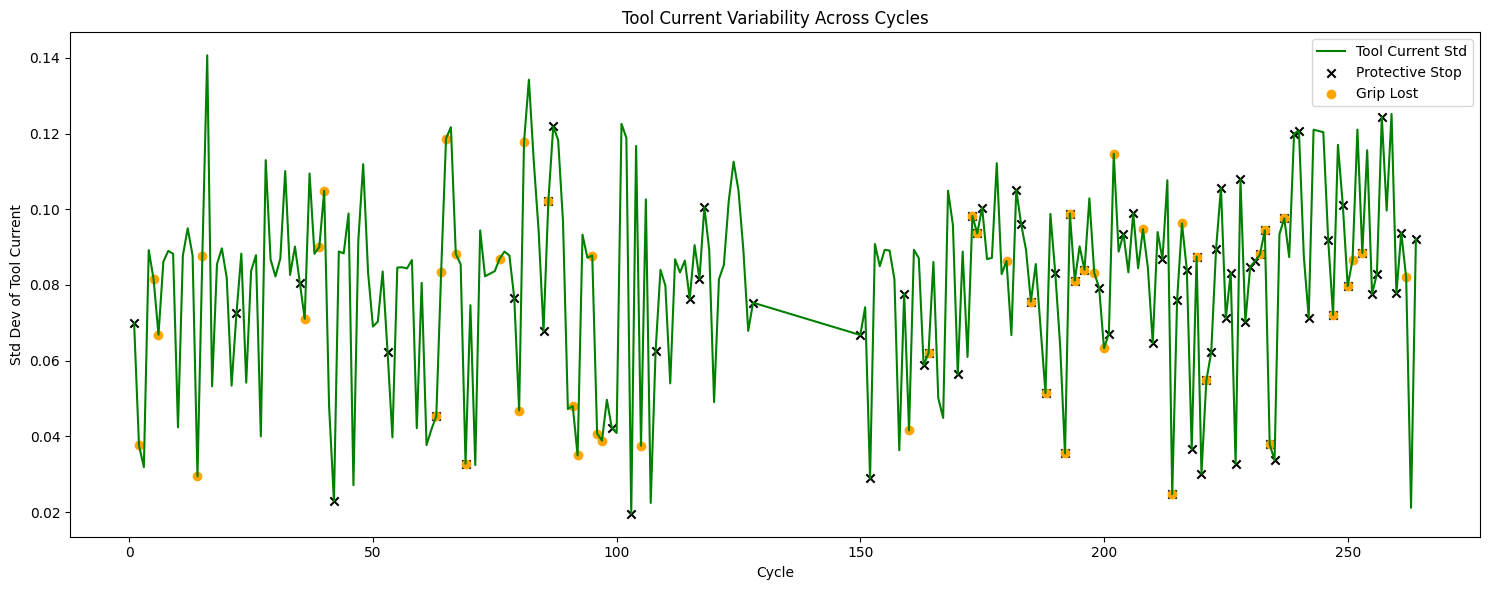

In [ ]:
cycle_stats['tool_current_std'] = df_missforest.groupby('cycle ')['Tool_current'].std().values

plt.figure(figsize=(15,6))
plt.plot(cycle_stats['cycle '], cycle_stats['tool_current_std'], label="Tool Current Std", color="green")
plt.scatter(cycle_stats['cycle '][cycle_stats['protective']==1],
            cycle_stats['tool_current_std'][cycle_stats['protective']==1], color="black", marker="x", label="Protective Stop")
plt.scatter(cycle_stats['cycle '][cycle_stats['grip']==1],
            cycle_stats['tool_current_std'][cycle_stats['grip']==1], color="orange", marker="o", label="Grip Lost")
plt.title("Tool Current Variability Across Cycles")
plt.xlabel("Cycle"); plt.ylabel("Std Dev of Tool Current")
plt.legend(); plt.tight_layout(); plt.show()


### Tool Current Variability Across Cycles

This plot shows the standard deviation of the tool current per cycle.

**Insights:**
- **High variability cycles (spikes in std):** Indicate unstable tool current. Many faults occur here.
- **Low variability cycles:** Usually stable operation, but protective stops still occur.
- **Fault correlation:** Both Protective Stops and Grip Loss events align with cycles of **increased current fluctuations**, suggesting that instability is a strong fault indicator.



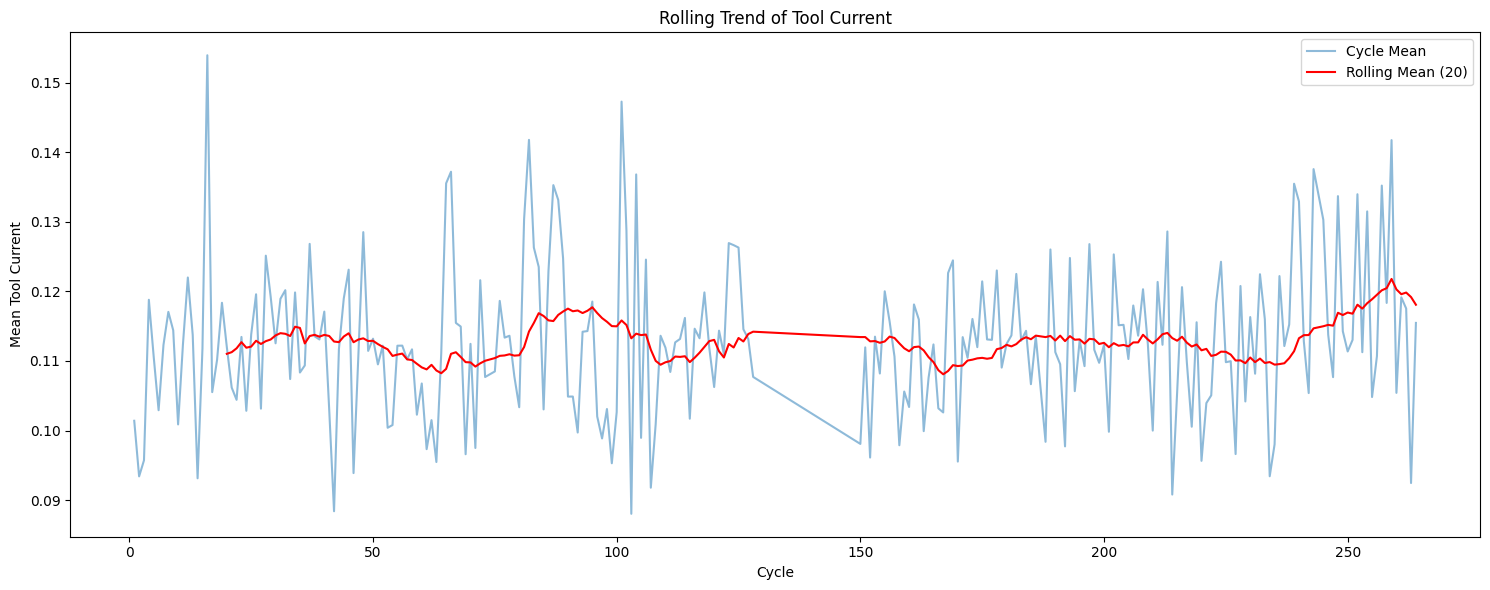

In [ ]:
window = 20
cycle_stats['roll_mean'] = cycle_stats['tool_current_mean'].rolling(window).mean()

plt.figure(figsize=(15,6))
plt.plot(cycle_stats['cycle '], cycle_stats['tool_current_mean'], alpha=0.5, label="Cycle Mean")
plt.plot(cycle_stats['cycle '], cycle_stats['roll_mean'], color="red", label=f"Rolling Mean ({window})")
plt.title("Rolling Trend of Tool Current")
plt.xlabel("Cycle");
plt.ylabel("Mean Tool Current")
plt.legend();
plt.tight_layout();
plt.show()


### Rolling Trend of Tool Current

The plot shows the mean tool current per cycle and its rolling mean over a 20-cycle window.

- **(Cycle Mean):** Reflects the average tool current at each cycle. It is noisy and shows short term fluctuations.  
- **(Rolling Mean):** A smoothed curve that averages over 20 cycles, highlighting the long term trend and filtering out noise.  

**Insights:**  
- The rolling mean is less noisy, indicating that the tool’s energy usage (current demand) is stable across cycles.  
- Small local variations in the red line.    


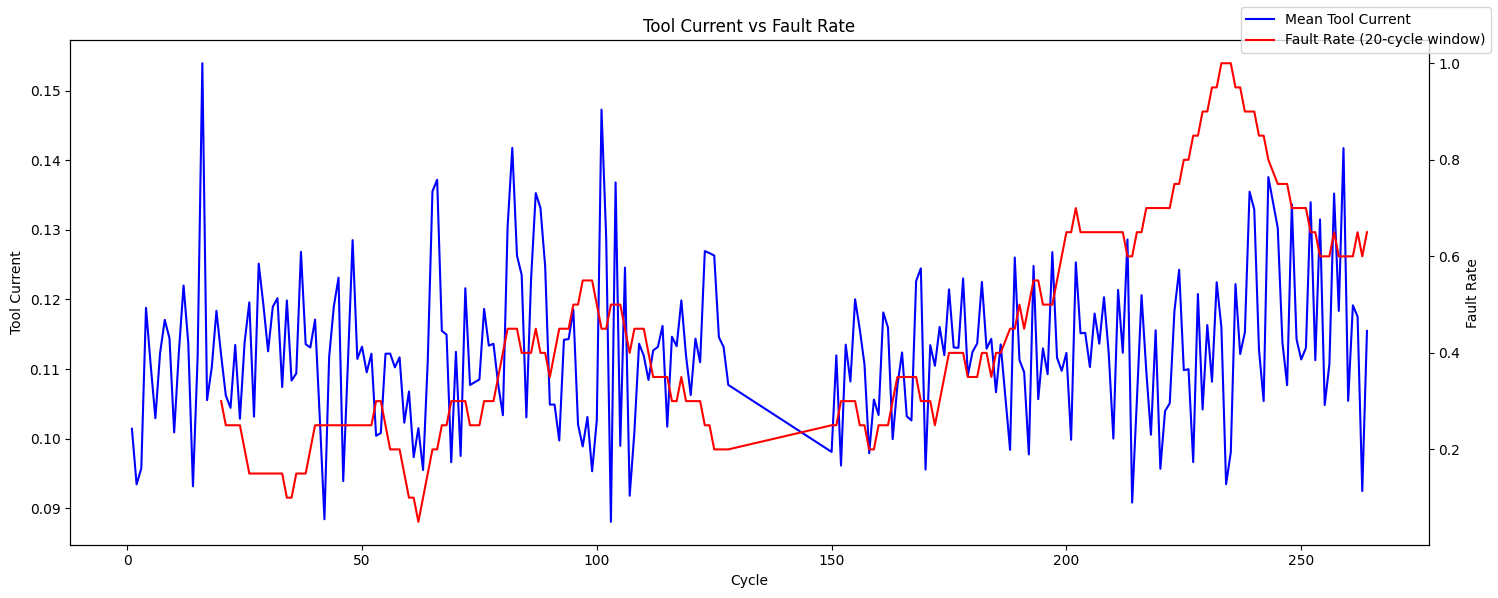

In [ ]:
cycle_stats['fault'] = cycle_stats['protective'] | cycle_stats['grip']
fault_rate = cycle_stats['fault'].rolling(20).mean()

fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(cycle_stats['cycle '], cycle_stats['tool_current_mean'], color="blue", label="Mean Tool Current")
ax2 = ax1.twinx()
ax2.plot(cycle_stats['cycle '], fault_rate, color="red", label="Fault Rate (20-cycle window)")

ax1.set_xlabel("Cycle")
ax1.set_ylabel("Tool Current")
ax2.set_ylabel("Fault Rate")
plt.title("Tool Current vs Fault Rate")
fig.legend(loc="upper right")
plt.tight_layout(); plt.show()


### Tool Current vs Fault Rate (Time Series Analysis)

This plot compares the **mean tool current per cycle**  with the **rolling fault rate** (smoothed over a 20-cycle window).  

**Key insights:**
- Periods of **high fault rate** can be spotted even when tool current stays stable.
- If **current increases alongside fault rate**, it suggests the tool is under higher stress, contributing to failures.
- Around **cycles 180–240**, fault rates increase sharply while tool current remains stable, highlighting fault causes unrelated to current draw.



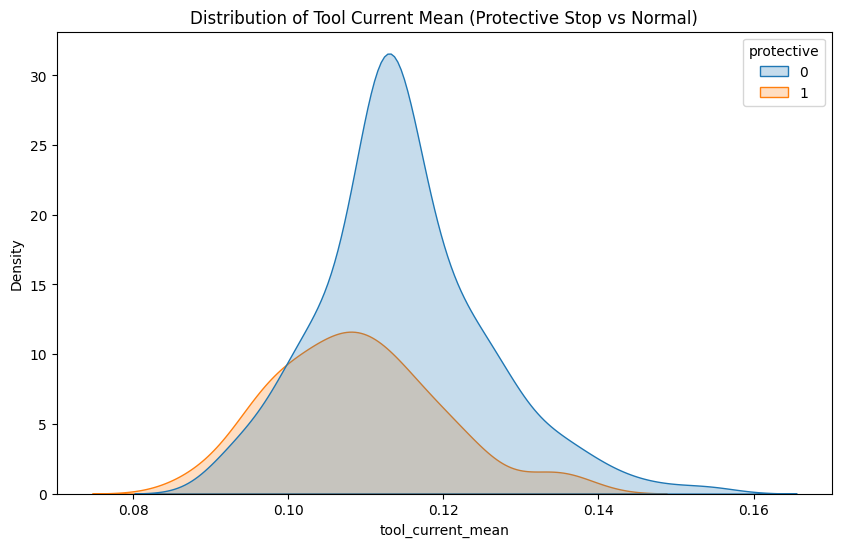

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=cycle_stats, x='tool_current_mean', hue='protective', fill=True)
plt.title("Distribution of Tool Current Mean (Protective Stop vs Normal)")
plt.show()


In [ ]:
# === Cell 1: Setup & load split PS / GL ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 150)

# <<< UPDATE these paths if needed >>>
PATH_PS = r"Joint_0_protective_stop.csv"
PATH_GL = r"Joint_0_grip_loss.csv"

ps = pd.read_csv(PATH_PS)
gl = pd.read_csv(PATH_GL)

def detect_cycle_and_time(df):
    cycle_candidates = ["cycle ", "cycle", "Cycle", "CYCLE", "cycle_id"]
    time_candidates  = ["Timestamp", "timestamp", "Time", "time"]
    cyc = next((c for c in cycle_candidates if c in df.columns), None)
    tme = next((c for c in time_candidates  if c in df.columns), None)
    return cyc, tme

CYCLE_COL_PS, TIME_COL_PS = detect_cycle_and_time(ps)
CYCLE_COL_GL, TIME_COL_GL = detect_cycle_and_time(gl)

# Use one set (should match); fallback if only found in one
CYCLE_COL = CYCLE_COL_PS or CYCLE_COL_GL
TIME_COL  = TIME_COL_PS  or TIME_COL_GL

print("Detected -> CYCLE_COL:", CYCLE_COL, "| TIME_COL:", TIME_COL)
assert CYCLE_COL is not None, "Couldn't find the cycle column in your CSVs."


NameError: name 'TIME_COL' is not defined

### Distribution of Tool Current Mean (Protective Stop vs Normal)

The KDE plot compares the distribution of **mean tool current per cycle** between:
- **Normal cycles (0):** More concentrated around ~0.11 .
- **Protective stop cycles (1):** Slightly shifted, broader distribution.

**Insights:**
- Protective stops are **not strongly tied to very high  tool current** but may happen under slightly lower or more variable tool current conditions.
- This indicates that protective stops could be triggered by **other factors** rather than tool current load alone.


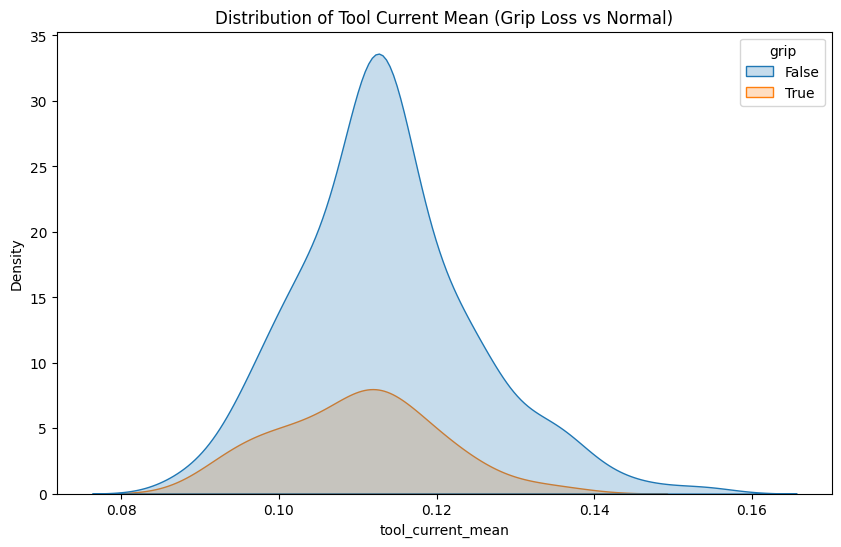

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=cycle_stats, x='tool_current_mean', hue='grip', fill=True)
plt.title("Distribution of Tool Current Mean (Grip Loss vs Normal)")
plt.show()


### Distribution of Tool Current Mean (Grip Loss vs Normal)

The KDE plot compares **mean tool current per cycle** between:
- **Normal cycles (False):** Centered around ~0.11 with a strong peak.
- **Grip loss cycles (True):** Overlapping heavily with normal cycles, also centered near ~0.11.

**Insights:**
- Grip loss does **not appear strongly correlated with mean tool current**.
- This suggests that other features  are likely more important in explaining grip loss events.


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3738257401.py:15: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df[cycle_col]):


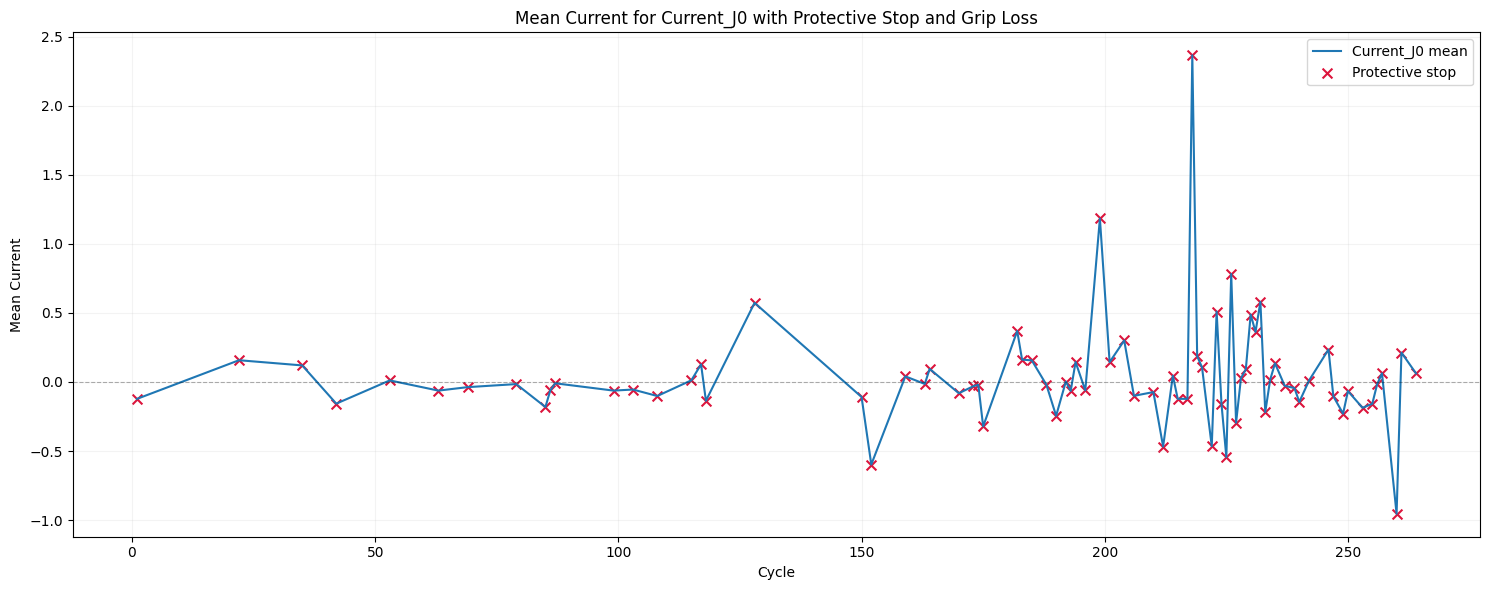

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\3738257401.py:15: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df[cycle_col]):


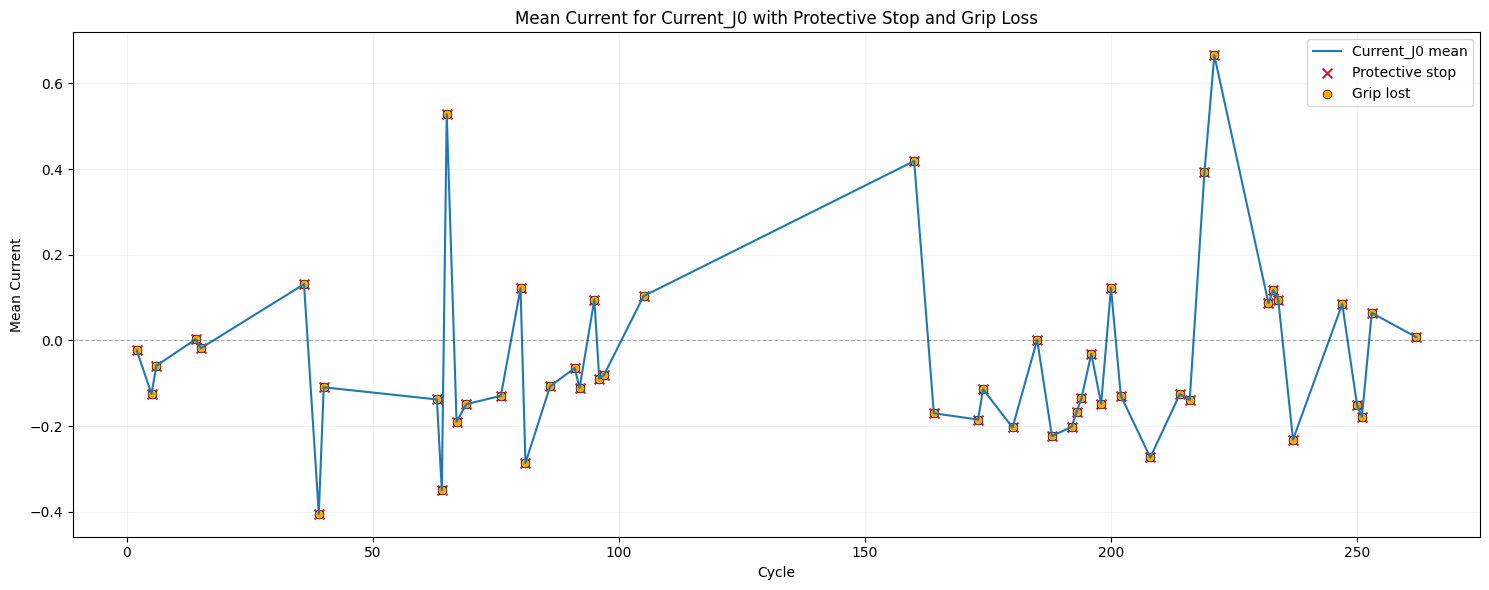

cycle  Current_J0  grip_lost
0       2   -0.023077       True
1       5   -0.124641       True
2       6   -0.058654       True
3      14    0.002957       True
4      15   -0.018215       True
5      36    0.131245       True
6      39   -0.404241       True
7      40   -0.109117       True
8      63   -0.137469       True
9      64   -0.349188       True
10     65    0.527740       True
11     67   -0.189011       True
12     69   -0.148462       True
13     76   -0.129095       True
14     80    0.121828       True
15     81   -0.285814       True
16     86   -0.107128       True
17     91   -0.064302       True
18     92   -0.110829       True
19     95    0.095438       True
20     96   -0.089202       True
21     97   -0.079560       True
22    105    0.103446       True
23    160    0.418517       True
24    164   -0.169795       True
25    173   -0.184413       True
26    174   -0.113721       True
27    180   -0.202901       True
28    185    0.001476       True
29    188   -0.223072       True
30    192   -0.201272       True
31    193   -0.167496       True
32    194   -0.134960       True
33    196   -0.030902       True
34    198   -0.147501       True
35    200    0.122849       True
36    202   -0.128650       True
37    208   -0.272870       True
38    214   -0.124888       True
39    216   -0.138718       True
40    219    0.392965       True
41    221    0.665329       True
42    232    0.087437       True
43    233    0.117665       True
44    234    0.094683       True
45    237   -0.231115       True
46    247    0.085036       True
47    250   -0.149498       True
48    251   -0.178325       True
49    253    0.064572       True
50    262    0.007943       True

In [76]:
def plot_single_joint_current(df, joint=0, joint_prefix="Current_J", cycle_col="cycle",
                              prot_col="Robot_ProtectiveStop", grip_col="grip_lost"):
    df = df.copy()
    df.columns = df.columns.str.strip()
    cycle_col = cycle_col.strip()
    prot_col = prot_col.strip()
    grip_col = grip_col.strip()
    
    if cycle_col in df.index.names:
        if cycle_col in df.columns:
            df = df.reset_index(drop=True)
        else:
            df = df.reset_index()

    if pd.api.types.is_datetime64tz_dtype(df[cycle_col]):
        df[cycle_col] = df[cycle_col].dt.tz_localize(None)

    col = f"{joint_prefix}{joint}"
    if col not in df.columns:
        raise ValueError(f"{col} not found in dataframe")

    agg_dict = {col: "mean"}
    if prot_col in df.columns:
        agg_dict[prot_col] = "max"
    if grip_col in df.columns:
        agg_dict[grip_col] = "max"

    cycle_means = df.groupby(cycle_col).agg(agg_dict).reset_index()

    prot_mask = cycle_means[prot_col].astype(bool) if prot_col in cycle_means.columns else np.array([False]*len(cycle_means))
    grip_mask = cycle_means[grip_col].astype(bool) if grip_col in cycle_means.columns else np.array([False]*len(cycle_means))

    plt.figure(figsize=(15,6))
    plt.plot(cycle_means[cycle_col], cycle_means[col], lw=1.5, label=f"{col} mean")

    if prot_col in cycle_means.columns:
        plt.scatter(cycle_means[cycle_col][prot_mask], cycle_means[col][prot_mask],
                    color="crimson", marker="x", s=50, label="Protective stop")
    if grip_col in cycle_means.columns:
        plt.scatter(cycle_means[cycle_col][grip_mask], cycle_means[col][grip_mask],
                    color="orange", edgecolor="black", linewidth=0.5, s=40, label="Grip lost")

    plt.axhline(0, color="k", lw=0.8, alpha=0.3, ls="--")
    plt.title(f"Mean Current for {col} with Protective Stop and Grip Loss")
    plt.xlabel("Cycle")
    plt.ylabel("Mean Current")
    plt.legend()
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

    return cycle_means

plot_single_joint_current(df_joint0_stop_clean)
plot_single_joint_current(df_joint0_grip_clean, prot_col="grip_lost")


### Mean Current per Joint with Faults

**Key insights:**
- **J1 and J2 currents** are consistently lower (around –2 to –1), and they show a **higher concentration of protective stop and grip loss events**, suggesting these joints are under the heaviest load and more prone to triggering faults.
- **J0, J4, and J5** currents fluctuate closer to 0 with more variability but fewer clustered faults, indicating less consistent stress compared to J1/J2.
- **J3** shows moderate negative currents (around –0.6) with scattered faults, making it less critical than J1/J2 but not negligible.
- The clustering of events at certain cycles across multiple joints suggests that **system-level conditions (not just one joint)** may contribute to protective stops or grip loss.



In [ ]:
def check_outliers(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    outlier_flags = []
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_flags.append((df[col] < lower_bound) | (df[col] > upper_bound))

        print(f"Column: {col}")
        print(f"Outliers: {len(outliers)}")
        df['outlier_count'] = np.sum(outlier_flags, axis=0)

    return df

check_outliers(df_joint0_grip_clean) 
check_outliers(df_joint0_stop_clean)

Column: Num
Outliers: 0
Column: Current_J0
Outliers: 975
Column: Temperature_T0
Outliers: 0
Column: Speed_J0
Outliers: 3227
Column: Tool_current
Outliers: 1053
Column: cycle
Outliers: 0
Column: abs_Current_J0
Outliers: 866
Column: abs_Speed_J0
Outliers: 693
Column: sudden0
Outliers: 927
Column: power_J0
Outliers: 908
Column: Num
Outliers: 0
Column: Current_J0
Outliers: 975
Column: Temperature_T0
Outliers: 0
Column: Speed_J0
Outliers: 3227
Column: Tool_current
Outliers: 1053
Column: cycle
Outliers: 0
Column: Robot_ProtectiveStop
Outliers: 279
Column: abs_Current_J0
Outliers: 866
Column: abs_Speed_J0
Outliers: 693
Column: sudden0
Outliers: 927
Column: power_J0
Outliers: 908


Num                        Timestamp  Current_J0  Temperature_T0  \
cycle                                                                           
1     0        1 2022-10-26 08:17:21.847000+00:00    0.109628         27.8750   
      1        2 2022-10-26 08:17:22.852000+00:00    0.595605         27.8750   
      2        3 2022-10-26 08:17:23.857000+00:00   -0.229474         27.8750   
      3        4 2022-10-26 08:17:24.863000+00:00    0.065053         27.8750   
      4        5 2022-10-26 08:17:25.877000+00:00    0.884140         27.8750   
...          ...                              ...         ...             ...   
264   7404  7405 2022-10-26 15:36:02.555000+00:00   -0.109017         37.1875   
      7405  7406 2022-10-26 15:36:03.562000+00:00   -0.098536         37.1875   
      7406  7407 2022-10-26 15:36:04.571000+00:00   -0.121100         37.1875   
      7407  7408 2022-10-26 15:36:05.572000+00:00   -0.129370         37.1875   
      7408  7409 2022-10-26 15:36:06.580000+00:00   -0.134429         37.1250   

                Speed_J0  Tool_current  cycle  Robot_ProtectiveStop  \
cycle                                                                 
1     0     2.955651e-01      0.082732      1                   0.0   
      1    -7.390000e-30      0.505895      1                   0.0   
      2     1.369386e-01      0.079420      1                   0.0   
      3    -9.030032e-02      0.083325      1                   0.0   
      4     1.268088e-01      0.086379      1                   0.0   
...                  ...           ...    ...                   ...   
264   7404  0.000000e+00      0.080013    264                   0.0   
      7405  0.000000e+00      0.078740    264                   0.0   
      7406  0.000000e+00      0.091471    264                   0.0   
      7407  0.000000e+00      0.090026    264                   0.0   
      7408  0.000000e+00      0.089097    264                   0.0   

            abs_Current_J0  abs_Speed_J0   sudden0      power_J0  \
cycle                                                              
1     0           0.109628  2.955651e-01       NaN  3.240209e-02   
      1           0.595605  7.390000e-30 -0.295565  4.401522e-30   
      2           0.229474  1.369386e-01  0.136939  3.142382e-02   
      3           0.065053  9.030032e-02 -0.227239  5.874323e-03   
      4           0.884140  1.268088e-01  0.217109  1.121168e-01   
...                    ...           ...       ...           ...   
264   7404        0.109017  0.000000e+00  0.000000  0.000000e+00   
      7405        0.098536  0.000000e+00  0.000000  0.000000e+00   
      7406        0.121100  0.000000e+00  0.000000  0.000000e+00   
      7407        0.129370  0.000000e+00  0.000000  0.000000e+00   
      7408        0.134429  0.000000e+00  0.000000  0.000000e+00   

            outlier_count  
cycle                      
1     0                 2  
      1                 2  
      2                 1  
      3                 1  
      4                 4  
...                   ...  
264   7404              0  
      7405              0  
      7406              0  
      7407              0  
      7408              0  

[7409 rows x 13 columns]

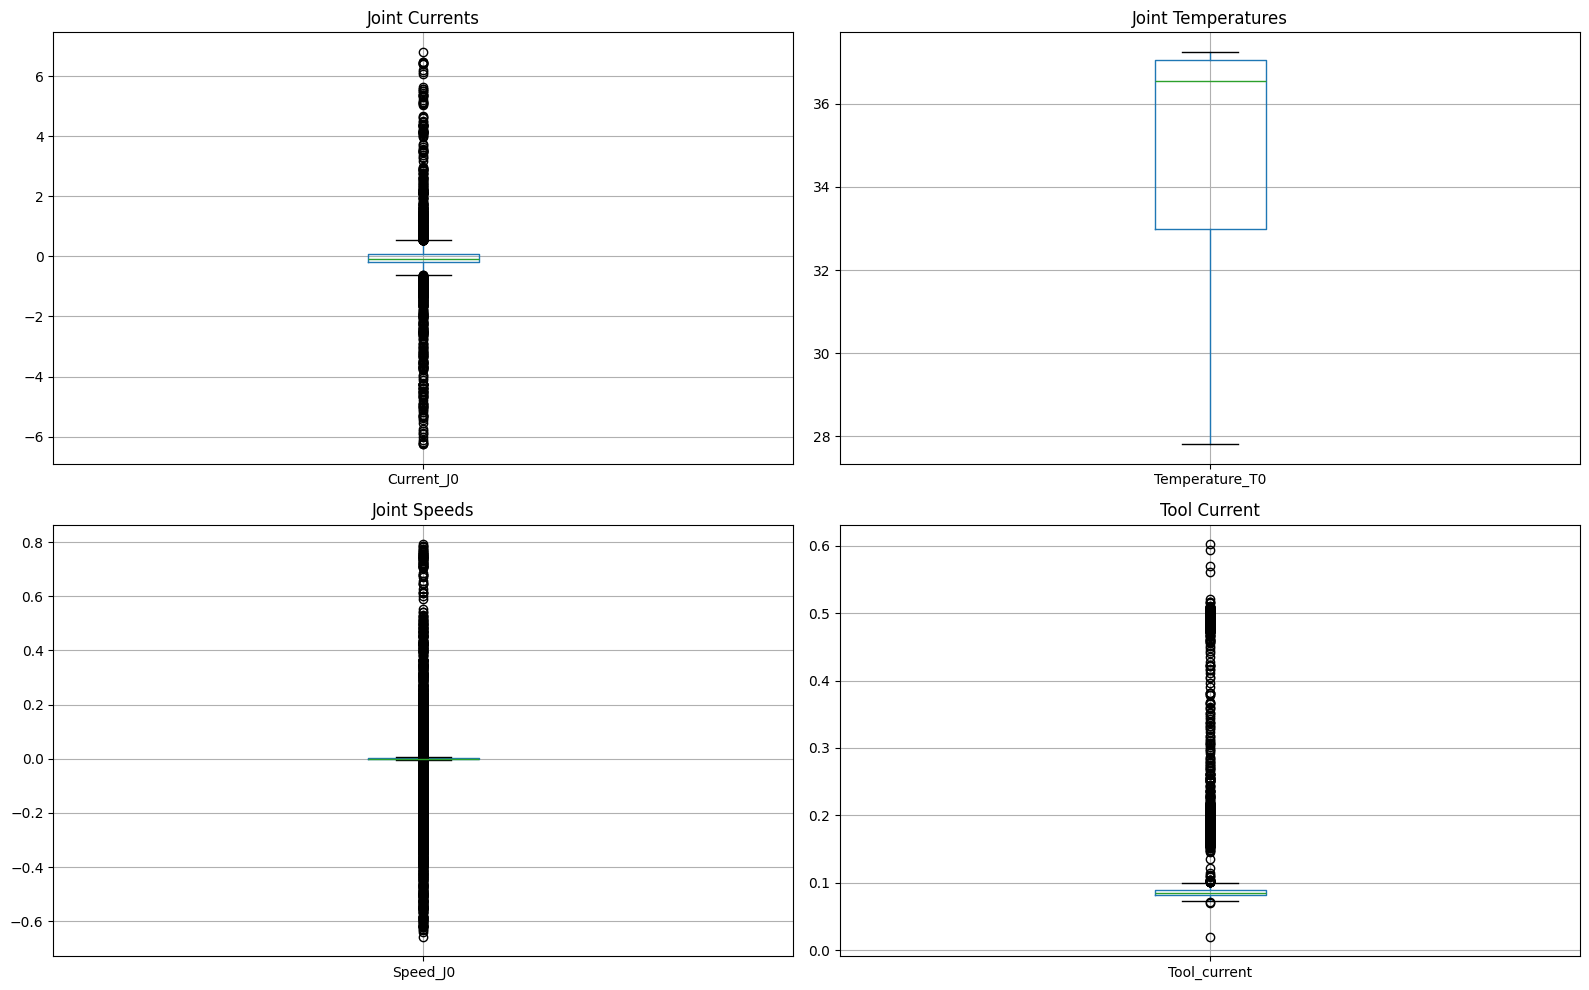

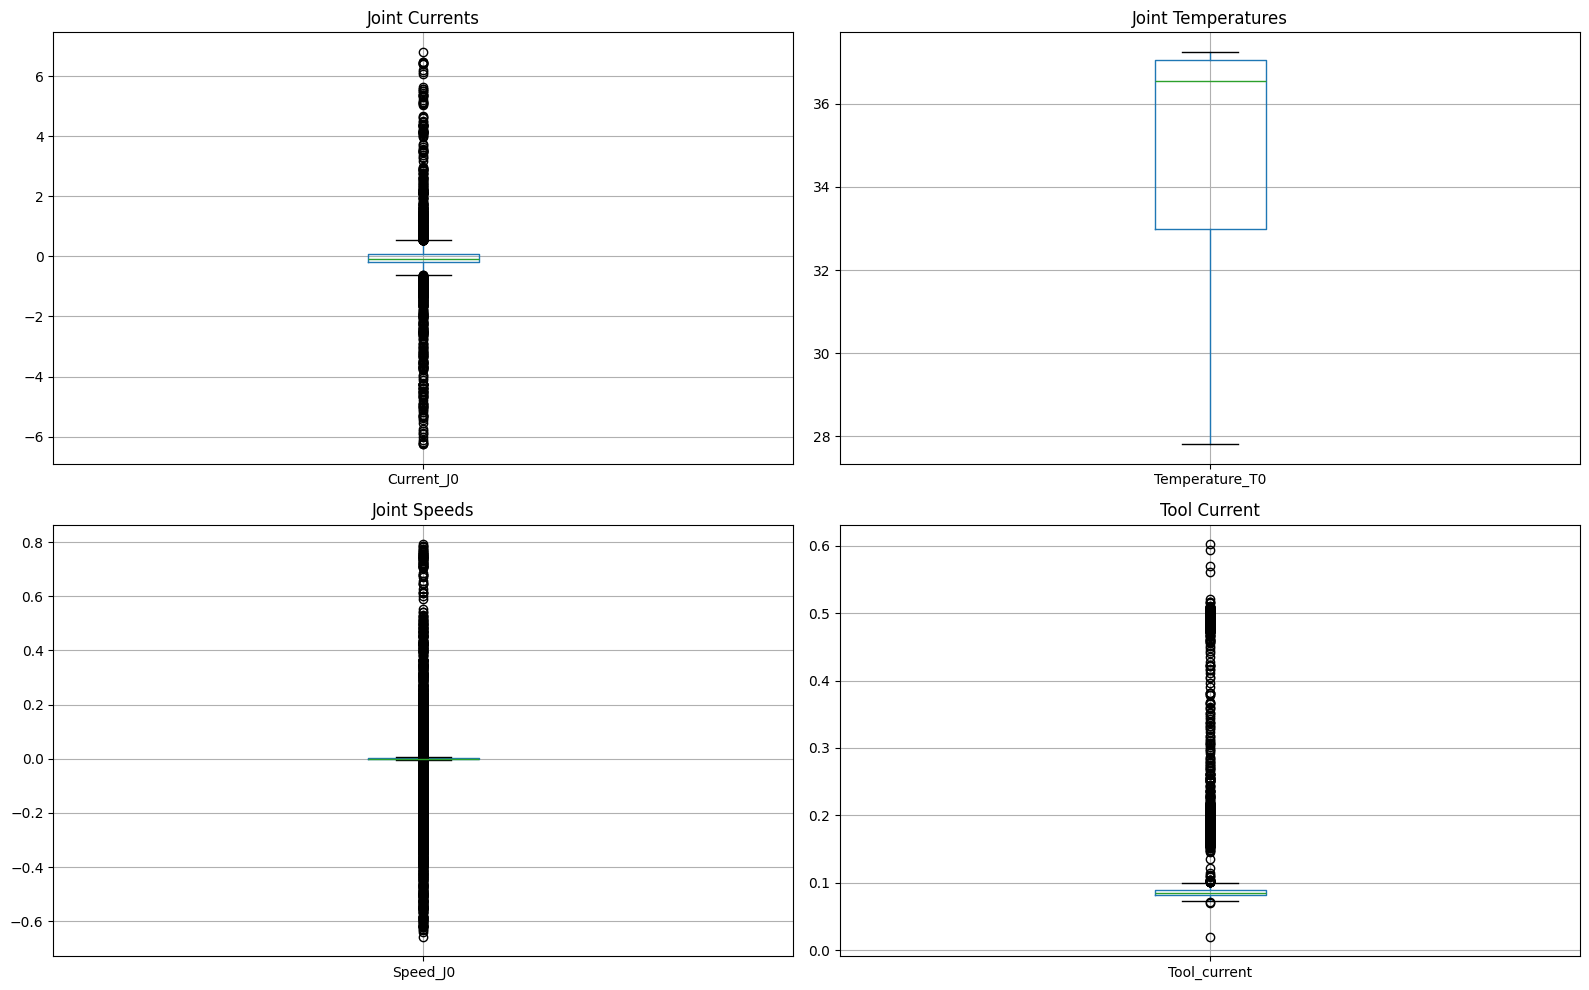

In [ ]:
def plot_boxplots(df):
    df = df.copy()
    fig, axes = plt.subplots(2, 2, figsize=(16,10))

    curr_cols = [c for c in [f'Current_J{j}' for j in range(6)] if c in df.columns]
    temp_cols = [c for c in ['Temperature_T0'] + [f'Temperature_J{j}' for j in range(1,6)] if c in df.columns]
    speed_cols = [f'Speed_J{j}' for j in range(6) if f'Speed_J{j}' in df.columns]
    tool_cols = [c for c in ['Tool_current'] if c in df.columns]

    if curr_cols:
        df[curr_cols].boxplot(ax=axes[0,0])
        axes[0,0].set_title("Joint Currents")
    if temp_cols:
        df[temp_cols].boxplot(ax=axes[0,1])
        axes[0,1].set_title("Joint Temperatures")
    if speed_cols:
        df[speed_cols].boxplot(ax=axes[1,0])
        axes[1,0].set_title("Joint Speeds")
    if tool_cols:
        df[tool_cols].boxplot(ax=axes[1,1])
        axes[1,1].set_title("Tool Current")

    plt.tight_layout()
    plt.show()

plot_boxplots(df_joint0_grip_clean)
plot_boxplots(df_joint0_stop_clean)

## Outlier Analysis from Boxplots



### Key Insights:
- **Joint Currents (J0–J5):**
  - Strong presence of outliers, especially in J0, J1, J2, and J4.
  - Negative currents dominate, which may indicate opposing torque or sudden load changes.
  - Suggests potential instability in joint behavior during certain cycles.

- **Joint Temperatures (T0–T5):**
  - Generally stable between 30–45 °C.
  - Some abnormal sudden drops (<30 °C), likely sensor glitches or unrealistic readings.

- **Joint Speeds (J0–J5):**
  - Mostly around zero, but with frequent spikes in both directions.
  - Indicates abnormal accelerations, possibly tied to grip loss or protective stops.

- **Tool Current:**
  - Normally very low (~0.1).
  - Contains many sharp spikes (>0.5).
  



In [ ]:

def plot_cycle_outliers(df):
    if 'cycle' in df.index.names:
        df = df.reset_index(drop=True)

    df = df.loc[:, ~df.columns.duplicated()]

    cycle_outliers = df.groupby('cycle', as_index=False).agg(
        total_outliers=('outlier_count', 'sum'),
        protective=('Robot_ProtectiveStop', 'max'),
    )

    # نرسم
    plt.figure(figsize=(15,6))
    plt.plot(cycle_outliers['cycle'], cycle_outliers['total_outliers'],
             label="Outlier Count", color="blue")
    
    plt.scatter(cycle_outliers.loc[cycle_outliers['protective']==1, 'cycle'],
                cycle_outliers.loc[cycle_outliers['protective']==1, 'total_outliers'],
                color="red", marker="x", label="Protective Stop")
    


    plt.title("Outlier Counts per Cycle with Faults")
    plt.xlabel("Cycle")
    plt.ylabel("Number of Outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()


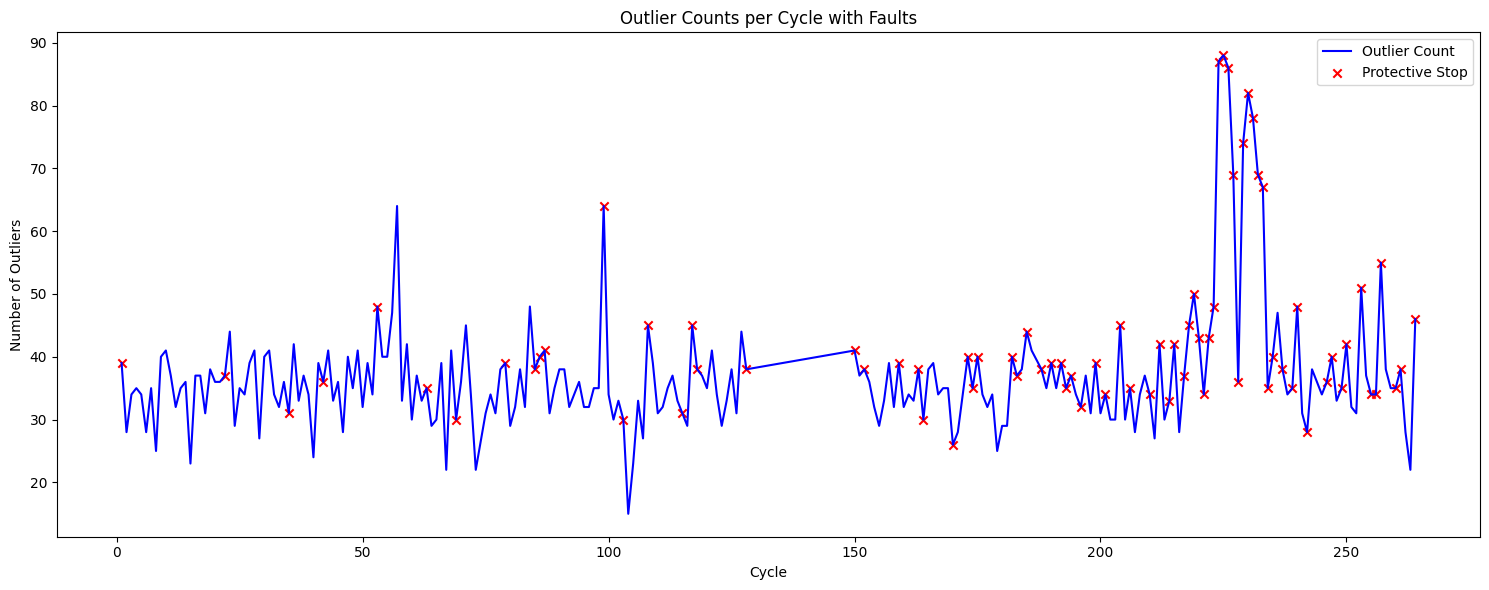

In [ ]:
plot_cycle_outliers(df_joint0_stop_clean)


In [ ]:

def plot_cycle_outliers(df):
    if 'cycle' in df.index.names:
        df = df.reset_index(drop=True)

    df = df.loc[:, ~df.columns.duplicated()]

    cycle_outliers = df.groupby('cycle', as_index=False).agg(
        total_outliers=('outlier_count', 'sum'),
        grip=('grip_lost', 'max'),
    )

    # نرسم
    plt.figure(figsize=(15,6))
    plt.plot(cycle_outliers['cycle'], cycle_outliers['total_outliers'],
             label="Outlier Count", color="blue")
    plt.scatter(cycle_outliers.loc[cycle_outliers['grip']==1, 'cycle'],
                cycle_outliers.loc[cycle_outliers['grip']==1, 'total_outliers'],
                color="orange", marker="o", label="Grip Lost")
    


    plt.title("Outlier Counts per Cycle with Faults")
    plt.xlabel("Cycle")
    plt.ylabel("Number of Outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()


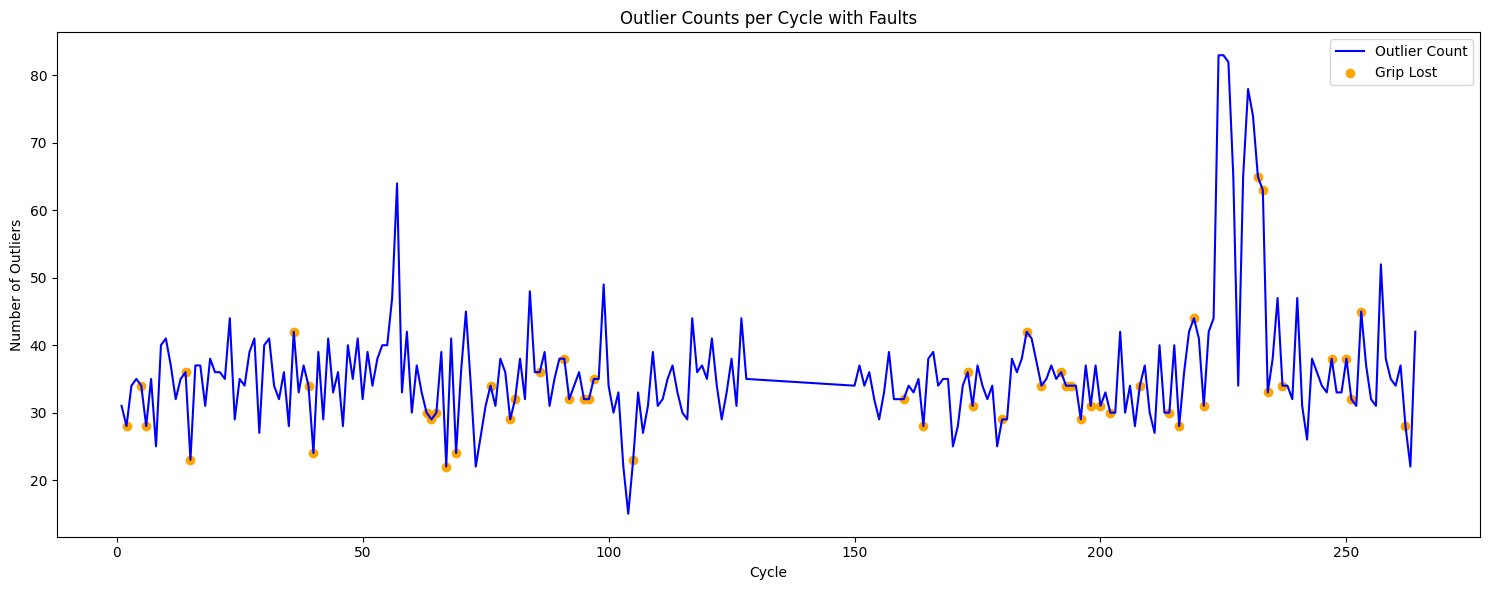

In [ ]:
plot_cycle_outliers(df_joint0_grip_clean)


In [ ]:
def outliers_during_faults(df, outlier_col='outlier_count'):
    
    fault_cycles = df[df['Robot_ProtectiveStop'] == 1]

    numeric_cols = fault_cycles.select_dtypes(include='number')

    outlier_summary = numeric_cols.drop(columns=['cycle', 'Robot_ProtectiveStop'], errors='ignore') \
                                  .sum() \
                                  .sort_values(ascending=False)

    return outlier_summary

summary = outliers_during_faults(df_joint0_stop_clean)
print(summary.head(12))


Num               1.212192e+06
Temperature_T0    9.968688e+03
outlier_count     3.790000e+02
abs_Current_J0    6.579455e+01
Tool_current      2.467720e+01
Current_J0        7.097818e+00
abs_Speed_J0      2.658016e+00
power_J0          1.294708e+00
sudden0          -9.048013e-01
Speed_J0         -1.371385e+00
dtype: float64


## Outlier–Fault Investigation



### Key Findings:
1. **Outlier Count per Cycle:**
   - Cycles with fault events (Protective Stop or Grip Loss ) tend to have **much higher outlier counts**.
   - Notable spikes around certain cycles  strongly align with multiple faults.

2. **Top Outlier-Contributing Features:**
   - The majority of anomalies come from **joint speeds**.
   - Smaller but important contributions from **joint currents**  and **Tool Current**.

3. **Interpretation:**
   - Fault cycles are often preceded by **irregular or extreme joint speeds**.
   - Currents and tool current also show anomalies, but less frequently compared to speeds.
   - This suggests that **speed instabilities are strong indicators of fault conditions**.




# JOINT1

In [ ]:
df_joint1=pd.read_csv('Dataset/joint_1_features (1).csv')
df_joint1.head()

Num                 Timestamp  Current_J1  Temperature_J1  Speed_J1  \
0    1  2022-10-26T08:17:21.847Z   -2.024669         29.3750 -0.000490   
1    2  2022-10-26T08:17:22.852Z   -2.278456         29.3125 -0.000304   
2    3  2022-10-26T08:17:23.857Z   -2.800408         29.3125  0.007795   
3    4  2022-10-26T08:17:24.863Z   -3.687768         29.3125 -0.004911   
4    5  2022-10-26T08:17:25.877Z   -2.938830         29.3750  0.005567   

   Tool_current  cycle   Robot_ProtectiveStop  grip_lost  
0      0.082732       1                   0.0      False  
1      0.505895       1                   0.0      False  
2      0.079420       1                   0.0      False  
3      0.083325       1                   0.0      False  
4      0.086379       1                   0.0      False

In [ ]:
convert_to_timestamp(df_joint1)
df_joint1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7409 entries, 0 to 7408
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   Num                   7409 non-null   int64              
 1   Timestamp             7409 non-null   datetime64[ns, UTC]
 2   Current_J1            7355 non-null   float64            
 3   Temperature_J1        7355 non-null   float64            
 4   Speed_J1              7355 non-null   float64            
 5   Tool_current          7355 non-null   float64            
 6   cycle                 7409 non-null   int64              
 7   Robot_ProtectiveStop  7355 non-null   float64            
 8   grip_lost             7409 non-null   bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 470.4 KB


In [ ]:
remove_strip(df_joint1)

_IncompleteInputError: incomplete input (1654666795.py, line 1)

# NUll values for J1

In [ ]:
df_joint1.isnull().sum()

Num                      0
Timestamp                0
Current_J1              54
Temperature_J1          54
Speed_J1                54
Tool_current            54
cycle                    0
Robot_ProtectiveStop    54
grip_lost                0
dtype: int64

In [ ]:
df_joint1_clean=fill_null_with_fandb(df_joint1)
df_joint1_clean.isnull().sum()

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\youss\AppData\Local\Temp\ipykernel_13336\428220627.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


Num                     0
Timestamp               0
Current_J1              0
Temperature_J1          0
Speed_J1                0
Tool_current            0
cycle                   0
Robot_ProtectiveStop    0
grip_lost               0
dtype: int64

# feature engineering for J1

In [ ]:
df_joint1=add_robot_features(df_joint1_clean)
df_joint1.columns

Index(['Num', 'Timestamp', 'Current_J1', 'Temperature_J1', 'Speed_J1',
       'Tool_current', 'cycle', 'Robot_ProtectiveStop', 'grip_lost',
       'abs_Current_J1', 'abs_Speed_J1', 'sudden1', 'power_J1'],
      dtype='object')

# EDA for J1

In [ ]:
df_joint1.isnull().sum()

Num                     0
Timestamp               0
Current_J1              0
Temperature_J1          0
Speed_J1                0
Tool_current            0
cycle                   0
Robot_ProtectiveStop    0
grip_lost               0
abs_Current_J1          0
abs_Speed_J1            0
sudden1                 1
power_J1                0
dtype: int64

In [ ]:
df_joint1["sudden1"].fillna(df_joint1["sudden1"].mean(), inplace=True)


C:\Users\youss\AppData\Local\Temp\ipykernel_13336\2200978750.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_joint1["sudden1"].fillna(df_joint1["sudden1"].mean(), inplace=True)


In [ ]:
features=['Current_J1',"Temperature_J1",'Speed_J1','Tool_current','abs_Current_J1','abs_Speed_J1','sudden1','power_J1']
univariate_analysis_protective=univariate_analysis(df_joint1,features,"Robot_ProtectiveStop")
univariate_analysis_protective

feature  mean_no_fault  mean_fault  cohens_d    t_stat  \
3    Tool_current       0.110511    0.088449 -0.279074  8.781327   
4  abs_Current_J1       2.289062    2.757940  0.611624 -8.247045   
0      Current_J1      -2.279789   -2.740640 -0.579671  7.701712   
1  Temperature_J1      37.633126   38.623880  0.305967 -6.131565   
2        Speed_J1      -0.000439    0.013557  0.284206 -2.722837   
7        power_J1       0.053733    0.070446  0.134505 -1.332034   
5    abs_Speed_J1       0.020453    0.025616  0.115290 -1.039445   
6         sudden1      -0.000065    0.001650  0.023105 -0.197453   

        p_value       AUC  
3  5.679781e-17  0.419020  
4  5.570898e-15  0.698588  
0  2.099780e-13  0.301251  
1  2.622704e-09  0.588581  
2  6.871930e-03  0.522557  
7  1.839124e-01  0.480566  
5  2.994826e-01  0.474217  
6  8.436151e-01  0.517130

In [ ]:
univariate_analysis(df_joint1,features,"grip_lost")

feature  mean_no_fault  mean_fault  cohens_d     t_stat  \
7        power_J1       0.055579    0.018489 -0.298831  13.423900   
5    abs_Speed_J1       0.021038    0.009139 -0.265983   9.544974   
4  abs_Current_J1       2.316533    2.017274 -0.388675   8.817925   
0      Current_J1      -2.306634   -2.017274  0.362523  -8.502680   
1  Temperature_J1      37.723538   36.104424 -0.501158   6.047101   
3    Tool_current       0.110131    0.096362 -0.174017   4.621603   
2        Speed_J1       0.000261   -0.005029 -0.107293   3.882864   
6         sudden1       0.000210   -0.006177 -0.086051   2.356836   

        p_value       AUC  
7  4.354066e-35  0.519826  
5  2.050629e-19  0.525263  
4  1.240856e-16  0.362583  
0  1.060143e-15  0.637393  
1  5.294028e-09  0.404347  
3  5.669026e-06  0.495374  
2  1.224488e-04  0.404765  
6  1.906657e-02  0.475092

In [ ]:
quartile_fault_analysis(df_joint1_clean, "Current_J1", "Robot_ProtectiveStop")

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\712805542.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count                          range
0       Q1    0.086346   1853  (-5.8100000000000005, -2.664]
1       Q2    0.024298   1852               (-2.664, -2.233]
2       Q3    0.024298   1852               (-2.233, -1.778]
3       Q4    0.015659   1852                (-1.778, 1.084]

In [ ]:
quartile_fault_analysis(df_joint1_clean, "Speed_J1", "Robot_ProtectiveStop")

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\712805542.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count               range
0       Q1    0.031301   1853  (-0.332, -0.00066]
1       Q2    0.040328   3050     (-0.00066, 0.0]
2       Q3    0.050459    654     (0.0, 0.000542]
3       Q4    0.035097   1852   (0.000542, 0.616]

In [ ]:
quartile_fault_analysis(df_joint1_clean, "Temperature_J1", "Robot_ProtectiveStop")

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\712805542.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count             range
0       Q1    0.019829   1866  (29.311, 35.375]
1       Q2    0.038521   1947  (35.375, 39.688]
2       Q3    0.039872   1881  (39.688, 40.125]
3       Q4    0.053644   1715    (40.125, 40.5]

In [ ]:
quartile_fault_analysis(df_joint1_clean, "Tool_current", "Robot_ProtectiveStop")

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\712805542.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby("quartile")[target].agg(


quartile  fault_rate  count             range
0       Q1    0.040021   1874  (0.0192, 0.0825]
1       Q2    0.052603   1863  (0.0825, 0.0852]
2       Q3    0.039825   1833  (0.0852, 0.0895]
3       Q4    0.017945   1839   (0.0895, 0.602]

In [ ]:
stats_protective(df_joint1_clean,'Temperature_J1')

Temperature_J1                                         \
                              count       mean       std      min      25%   
Robot_ProtectiveStop                                                         
0.0                          7130.0  37.633126  3.259811  29.3125  35.3125   
1.0                           279.0  38.623880  2.620797  29.4375  37.1250   

                                                
                          50%     75%      max  
Robot_ProtectiveStop                            
0.0                   39.6875  40.125  40.5000  
1.0                   39.9375  40.250  40.4375

In [ ]:
stats_grip(df_joint1_clean,'Temperature_J1')

Temperature_J1                                                  \
                   count       mean       std      min      25%      50%   
grip_lost                                                                  
False             7166.0  37.723538  3.195868  29.3125  35.4375  39.6875   
True               243.0  36.104424  4.132119  29.5000  31.0625  36.5000   

                            
              75%      max  
grip_lost                   
False      40.125  40.4375  
True       40.000  40.5000

In [ ]:
stats_protective(df_joint1_clean,'Current_J1')

Current_J1                                          \
                          count      mean       std       min       25%   
Robot_ProtectiveStop                                                      
0.0                      7130.0 -2.279789  0.786571 -5.808734 -2.645310   
1.0                       279.0 -2.740640  0.987297 -4.640350 -3.479173   

                                                    
                           50%       75%       max  
Robot_ProtectiveStop                                
0.0                  -2.217855 -1.769715  1.074144  
1.0                  -2.822606 -2.183275  1.083596

In [ ]:
stats_grip(df_joint1_clean,'Current_J1')

Current_J1                                                    \
               count      mean       std       min       25%       50%   
grip_lost                                                                
False         7166.0 -2.306634  0.806137 -5.808734 -2.669117 -2.244652   
True           243.0 -2.017274  0.509308 -4.336777 -2.455471 -1.767407   

                               
                75%       max  
grip_lost                      
False     -1.789185  1.083596  
True      -1.641585 -0.357726

In [ ]:
stats_protective(df_joint1_clean,'Speed_J1')

Speed_J1                                               \
                        count      mean       std       min       25%  50%   
Robot_ProtectiveStop                                                         
0.0                    7130.0 -0.000439  0.047283 -0.330833 -0.000731  0.0   
1.0                     279.0  0.013557  0.085347 -0.184411 -0.000185  0.0   

                                          
                           75%       max  
Robot_ProtectiveStop                      
0.0                   0.000563  0.342549  
1.0                   0.000306  0.615526

In [ ]:
stats_grip(df_joint1_clean,'Speed_J1')

Speed_J1                                                    \
             count      mean       std       min       25%       50%   
grip_lost                                                              
False       7166.0  0.000261  0.050011 -0.330833 -0.000536  0.000000   
True         243.0 -0.005029  0.019139 -0.095336 -0.006777 -0.000046   

                               
                75%       max  
grip_lost                      
False      0.000608  0.615526  
True       0.000000  0.138693

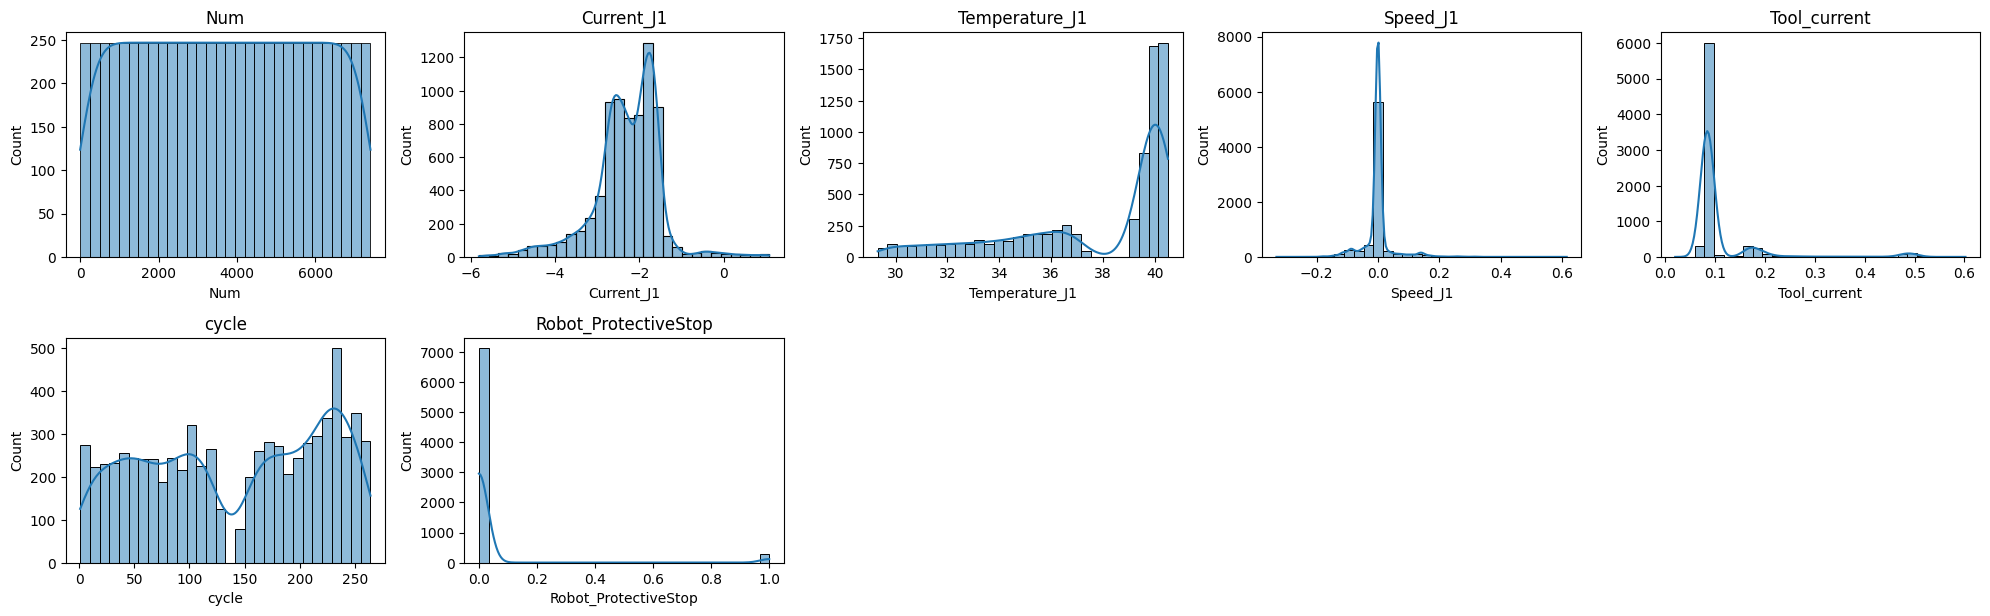

In [ ]:
plot_histograms(df_joint1_clean)

# j2

In [ ]:
df_j2=pd.read_csv("Dataset/joint_2_features (1).csv")


In [ ]:
df_j2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7409 entries, 0 to 7408
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Num                   7409 non-null   int64  
 1   Timestamp             7409 non-null   object 
 2   Current_J2            7355 non-null   float64
 3   Temperature_J2        7355 non-null   float64
 4   Speed_J2              7355 non-null   float64
 5   Tool_current          7355 non-null   float64
 6   cycle                 7409 non-null   int64  
 7   Robot_ProtectiveStop  7355 non-null   float64
 8   grip_lost             7409 non-null   bool   
dtypes: bool(1), float64(5), int64(2), object(1)
memory usage: 470.4+ KB


In [ ]:
remove_strip(df_j2)

Num                   Timestamp  Current_J2  Temperature_J2  \
0        1    2022-10-26T08:17:21.847Z   -1.531442         29.3750   
1        2    2022-10-26T08:17:22.852Z   -0.866556         29.4375   
2        3    2022-10-26T08:17:23.857Z   -2.304336         29.4375   
3        4    2022-10-26T08:17:24.863Z   -1.217652         29.4375   
4        5    2022-10-26T08:17:25.877Z   -1.794076         29.4375   
5        6    2022-10-26T08:17:26.885Z   -1.211779         29.4375   
6        7    2022-10-26T08:17:27.901Z   -0.960634         29.4375   
7        8    2022-10-26T08:17:28.903Z   -0.961322         29.4375   
8        9    2022-10-26T08:17:29.905Z   -1.418934         29.4375   
9       10    2022-10-26T08:17:30.909Z   -1.979400         29.4375   
10      11    2022-10-26T08:17:31.909Z   -0.549353         29.4375   
11      12    2022-10-26T08:17:32.924Z   -1.050977         29.5000   
12      13    2022-10-26T08:17:33.929Z   -1.741693         29.5000   
13      14    2022-10-26T08:17:34.936Z   -1.574188         29.4375   
14      15    2022-10-26T08:17:35.950Z   -0.730018         29.5000   
15      16    2022-10-26T08:17:36.954Z   -0.791188         29.5000   
16      17    2022-10-26T08:17:37.954Z   -0.767418         29.4375   
17      18    2022-10-26T08:17:38.964Z   -3.577167         29.5000   
18      19    2022-10-26T08:17:39.964Z   -0.898231         29.5000   
19      20    2022-10-26T08:17:40.967Z   -1.937540         29.5000   
20      21    2022-10-26T08:17:41.975Z   -1.399892         29.5000   
21      22    2022-10-26T08:17:42.989Z   -1.353301         29.5000   
22      23    2022-10-26T08:17:43.990Z   -1.334905         29.5000   
23      24    2022-10-26T08:17:45.005Z   -1.336278         29.5000   
24      25    2022-10-26T08:17:46.006Z   -1.333780         29.5000   
25      26    2022-10-26T08:17:47.011Z   -1.346168         29.5000   
26      27    2022-10-26T08:17:48.015Z   -1.329862         29.5000   
27      28    2022-10-26T08:17:49.021Z   -1.334815         29.5000   
28      29    2022-10-26T08:17:50.024Z   -1.333999         29.5000   
29      30    2022-10-26T08:17:51.027Z   -1.332489         29.5000   
30      31    2022-10-26T08:17:52.031Z   -1.403645         29.5625   
31      32    2022-10-26T08:17:53.036Z   -1.466469         29.5625   
32      33    2022-10-26T08:17:54.050Z   -1.455391         29.5625   
33      34    2022-10-26T08:17:55.055Z   -1.437145         29.5625   
34      35    2022-10-26T08:17:56.057Z   -0.927237         29.5625   
35      36    2022-10-26T08:17:57.060Z   -0.814090         29.6250   
36      37    2022-10-26T08:17:58.065Z   -0.868753         29.6250   
37      38    2022-10-26T08:17:59.067Z   -0.874810         29.6250   
38      39    2022-10-26T08:18:00.071Z   -0.977145         29.6250   
39      40    2022-10-26T08:18:01.086Z   -1.082921         29.6250   
40      41    2022-10-26T08:18:02.090Z   -1.413514         29.6250   
41      42    2022-10-26T08:18:03.097Z   -1.078717         29.6250   
42      43    2022-10-26T08:18:04.098Z   -1.622327         29.6250   
43      44    2022-10-26T08:18:05.105Z   -0.734569         29.6250   
44      45    2022-10-26T08:18:06.110Z   -0.669087         29.6250   
45      46    2022-10-26T08:18:07.112Z   -0.823336         29.6250   
46      47    2022-10-26T08:18:08.119Z   -0.788181         29.6250   
47      48    2022-10-26T08:18:09.124Z   -0.786772         29.6250   
48      49    2022-10-26T08:18:10.139Z   -0.831334         29.6250   
49      50    2022-10-26T08:18:11.144Z   -1.242574         29.6875   
50      51    2022-10-26T08:18:12.149Z   -1.850517         29.6875   
51      52    2022-10-26T08:18:13.158Z   -1.724452         29.6250   
52      53    2022-10-26T08:18:14.161Z   -0.392705         29.6250   
53      54    2022-10-26T08:18:15.162Z   -1.312337         29.6875   
54      55    2022-10-26T08:18:16.177Z   -1.630685         29.6250   
55      56    2022-10-26T08:18:17.178Z   -0.247335         29.6250   
56      57    202

In [ ]:
df_j2_clean=fill_null_with_fandb(df_j2)
df_j2_clean.isnull().sum()

C:\Users\youss\AppData\Local\Temp\ipykernel_13336\428220627.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
C:\Users\youss\AppData\Local\Temp\ipykernel_13336\428220627.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_data = df.groupby('cycle').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


Num                     0
Timestamp               0
Current_J2              0
Temperature_J2          0
Speed_J2                0
Tool_current            0
cycle                   0
Robot_ProtectiveStop    0
grip_lost               0
dtype: int64

In [ ]:
df_j2_clean=add_robot_features(df_j2_clean)
df_j2_clean.columns

Index(['Num', 'Timestamp', 'Current_J2', 'Temperature_J2', 'Speed_J2',
       'Tool_current', 'cycle', 'Robot_ProtectiveStop', 'grip_lost',
       'abs_Current_J2', 'abs_Speed_J2', 'sudden2', 'power_J2'],
      dtype='object')

In [ ]:
df_j2_clean["sudden2"].fillna(df_j2_clean["sudden2"].mean(), inplace=True)


C:\Users\youss\AppData\Local\Temp\ipykernel_13336\1031907263.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_j2_clean["sudden2"].fillna(df_j2_clean["sudden2"].mean(), inplace=True)


In [ ]:
features=["Current_J2","Temperature_J2","Speed_J2","Tool_current","sudden2","power_J2","abs_Current_J2","abs_Speed_J2"]
univariate_analysis_protective=univariate_analysis(df_j2_clean,features,"grip_lost")
univariate_analysis_protective

feature  mean_no_fault  mean_fault  cohens_d     t_stat  \
6  abs_Current_J2       1.241158    0.966972 -0.508528  11.248638   
0      Current_J2      -1.207555   -0.966972  0.395345  -9.776004   
1  Temperature_J2      38.130181   36.443673 -0.511956   6.143732   
3    Tool_current       0.110131    0.096362 -0.174017   4.621603   
5        power_J2       0.294750    0.154622 -0.147811   3.825989   
2        Speed_J2      -0.000079    0.146782  0.200940  -3.720530   
7    abs_Speed_J2       0.235541    0.178752 -0.081954   1.462688   
4         sudden2       0.002414   -0.071201 -0.071218   0.978522   

        p_value       AUC  
6  1.837906e-24  0.319742  
0  1.068605e-19  0.673261  
1  3.129258e-09  0.402644  
3  5.669026e-06  0.495374  
5  1.589214e-04  0.504806  
2  2.423324e-04  0.532578  
7  1.447366e-01  0.516476  
4  3.287431e-01  0.484348

In [77]:
# === Cell 1: Setup & load split PS / GL ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 150)

# <<< UPDATE these paths if needed >>>
PATH_PS = r"Joint_0_protective_stop.csv"
PATH_GL = r"Joint_0_grip_loss.csv"

ps = pd.read_csv(PATH_PS)
gl = pd.read_csv(PATH_GL)

def detect_cycle_and_time(df):
    cycle_candidates = ["cycle ", "cycle", "Cycle", "CYCLE", "cycle_id"]
    time_candidates  = ["Timestamp", "timestamp", "Time", "time"]
    cyc = next((c for c in cycle_candidates if c in df.columns), None)
    tme = next((c for c in time_candidates  if c in df.columns), None)
    return cyc, tme

CYCLE_COL_PS, TIME_COL_PS = detect_cycle_and_time(ps)
CYCLE_COL_GL, TIME_COL_GL = detect_cycle_and_time(gl)

# Use one set (should match); fallback if only found in one
CYCLE_COL = CYCLE_COL_PS or CYCLE_COL_GL
TIME_COL  = TIME_COL_PS  or TIME_COL_GL

print("Detected -> CYCLE_COL:", CYCLE_COL, "| TIME_COL:", TIME_COL)
assert CYCLE_COL is not None, "Couldn't find the cycle column in your CSVs."


Detected -> CYCLE_COL: cycle  | TIME_COL: Timestamp


In [78]:
# === Cell 2: Label safety & sorting ===
# Ensure booleans (in case CSV saved them as 0/1)
if "Robot_ProtectiveStop" in ps.columns and ps["Robot_ProtectiveStop"].dtype != bool:
    ps["Robot_ProtectiveStop"] = ps["Robot_ProtectiveStop"].map({0: False, 1: True}).astype(bool)
if "grip_lost" in gl.columns and gl["grip_lost"].dtype != bool:
    gl["grip_lost"] = gl["grip_lost"].map({0: False, 1: True}).astype(bool)

# Sort by cycle then time (or Num if time missing)
def sort_in_cycle(df, cycle_col, time_col):
    if time_col and time_col in df.columns:
        return df.sort_values([cycle_col, time_col])
    elif "Num" in df.columns:
        return df.sort_values([cycle_col, "Num"])
    return df.sort_values([cycle_col])

ps = sort_in_cycle(ps, CYCLE_COL, TIME_COL)
gl = sort_in_cycle(gl, CYCLE_COL, TIME_COL)

ps.head(3), gl.head(3)


(   Num                 Timestamp  Current_J0      Speed_J0  Tool_current  Robot_ProtectiveStop  Temperature_T0  cycle 
 0   20  2022-10-26T08:17:40.967Z   -0.177748 -2.195038e-02      0.083239                  True         27.9375       1
 1   21  2022-10-26T08:17:41.975Z   -0.161907  0.000000e+00      0.083919                  True         27.8750       1
 2   22  2022-10-26T08:17:42.989Z   -0.132235 -1.400000e-45      0.096649                  True         27.8750       1,
    Num                 Timestamp  Current_J0  Speed_J0  Tool_current  grip_lost  Temperature_T0  cycle 
 0   44  2022-10-26T08:18:05.105Z    0.317540 -0.012641      0.083239       True         28.0000       2
 1   45  2022-10-26T08:18:06.110Z    0.399679  0.070728      0.083746       True         27.9375       2
 2   58  2022-10-26T08:18:19.192Z   -0.094453  0.000000      0.168534       True         28.0000       2)

In [80]:
# === Cell 3: Helper functions (works on PS/GL directly) ===

def add_effort(df_):
    d = df_.copy()
    if "Current_J0" in d.columns and "Speed_J0" in d.columns:
        d["Effort_J0"] = np.abs(d["Current_J0"]) * np.abs(d["Speed_J0"])
    return d

def aggregate_cycle(d, cycle_col, time_col=None):
    d = add_effort(d)
    agg = {}
    for c in ["Current_J0","Speed_J0","Effort_J0"]:
        if c in d.columns:
            agg[c] = ["mean","max","std"]
    if "Tool_current" in d.columns:
        agg["Tool_current"] = ["mean","max","std"]
    if "Temperature_T0" in d.columns:
        agg["Temperature_T0"] = ["mean","max"]
    agg[cycle_col] = "max"

    cyc = d.groupby(cycle_col).agg(agg)
    cyc.columns = ["_".join([c for c in t if c]) for t in cyc.columns.to_flat_index()]

    # Abruptness = std of first-difference of Speed_J0 within each cycle
    if "Speed_J0" in d.columns:
        if time_col and time_col in d.columns:
            d = d.sort_values([cycle_col, time_col])
        ab = d.groupby(cycle_col)["Speed_J0"].apply(lambda s: s.diff().std(skipna=True)).rename("Abruptness_J0")
        cyc = cyc.join(ab, how="left")

    return cyc.reset_index(drop=False)

def describe_ranges(df_):
    out = []
    num = df_.select_dtypes(include=[np.number]).columns.tolist()
    for c in num:
        s = df_[c].astype(float)
        q = s.quantile([.05,.25,.5,.75,.95])
        out.append([c, len(s), s.mean(), s.std(), s.min(), q[.05], q[.25], q[.5], q[.75], q[.95], s.max()])
    return pd.DataFrame(out, columns=["Feature","N","Mean","Std","Min","P05","P25","Median","P75","P95","Max"]).sort_values("Feature")

def last_window_stats(df_, frac, cycle_col, time_col):
    d = df_.copy()
    if time_col and time_col in d.columns:
        d = d.sort_values([cycle_col, time_col])
    feats = []
    for cid, g in d.groupby(cycle_col):
        n = len(g); k = max(1, int(np.ceil(n*frac)))
        tail = g.tail(k)
        row = {cycle_col: cid}
        for c in ["Current_J0","Speed_J0","Tool_current","Temperature_T0"]:
            if c in g.columns:
                row[f"{c}_lw_mean"] = tail[c].mean()
                row[f"{c}_lw_max"]  = tail[c].max()
                row[f"{c}_lw_std"]  = tail[c].std()
        feats.append(row)
    return pd.DataFrame(feats)

def outlier_counts_per_cycle(df_, cols, cycle_col):
    d = df_.copy()
    rows = []
    for cid, g in d.groupby(cycle_col):
        row = {cycle_col: cid}
        for c in cols:
            if c in g.columns:
                x = g[c].dropna().values
                if len(x)==0:
                    row[f"{c}_outliers"] = 0
                    continue
                q1, q3 = np.percentile(x, [25, 75])
                iqr = q3 - q1
                lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
                row[f"{c}_outliers"] = int(((x<lo)|(x>hi)).sum())
        rows.append(row)
    return pd.DataFrame(rows)

def ks_and_effects(a, b):
    a, b = np.asarray(a, float), np.asarray(b, float)
    a, b = a[~np.isnan(a)], b[~np.isnan(b)]
    ks = stats.ks_2samp(a, b) if len(a)>1 and len(b)>1 else None
    def cohen_d(x, y):
        if len(x)<2 or len(y)<2: return np.nan
        nx, ny = len(x), len(y)
        vx, vy = x.var(ddof=1), y.var(ddof=1)
        pooled = ((nx-1)*vx + (ny-1)*vy)/(nx+ny-2)
        return (y.mean()-x.mean())/np.sqrt(pooled) if pooled>0 else np.nan
    def cliffs_delta(x, y):
        if len(x)==0 or len(y)==0: return np.nan
        gt = sum((xi < yj) for xi in x for yj in y)
        lt = sum((xi > yj) for xi in x for yj in y)
        return (gt - lt)/(len(x)*len(y))
    return {
        "KS_D": (ks.statistic if ks else np.nan),
        "KS_p": (ks.pvalue if ks else np.nan),
        "Cohen_d": cohen_d(a, b),
        "Cliffs_delta": cliffs_delta(a, b)
    }

# --- plotting (matplotlib only) ---
def plot_hist(series, title):
    s = pd.Series(series).dropna().values
    if len(s)==0: return
    plt.figure(); plt.hist(s, bins=30); plt.title(title)
    plt.xlabel(title); plt.ylabel("Count"); plt.tight_layout(); plt.show()

def plot_ecdf(series, title):
    s = pd.Series(series).dropna().sort_values().values
    if len(s)==0: return
    y = np.arange(1, len(s)+1)/len(s)
    plt.figure(); plt.plot(s, y); plt.title(f"ECDF – {title}")
    plt.xlabel(title); plt.ylabel("F(x)"); plt.tight_layout(); plt.show()

def plot_box_two(a, b, labels, title):
    a = pd.Series(a).dropna().values; b = pd.Series(b).dropna().values
    if len(a)==0 or len(b)==0: return
    plt.figure(); plt.boxplot([a, b], labels=labels); plt.title(title)
    plt.tight_layout(); plt.show()

def plot_scatter(x, y, title, xlabel, ylabel):
    x = pd.Series(x).dropna().values; y = pd.Series(y).dropna().values
    if len(x)==0 or len(y)==0: return
    m = min(len(x), len(y))
    plt.figure(); plt.scatter(x[:m], y[:m], s=14, alpha=0.6)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.tight_layout(); plt.show()

def plot_corr_heatmap(df_, title):
    num = df_.select_dtypes(include=[np.number])
    if num.shape[1] < 2: 
        print("Not enough numeric columns for heatmap.")
        return
    c = num.corr()
    plt.figure(figsize=(7,6))
    im = plt.imshow(c, aspect='auto', interpolation='nearest')
    plt.title(title); plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(c.columns)), c.columns, rotation=90)
    plt.yticks(range(len(c.columns)), c.columns)
    plt.tight_layout(); plt.show()


In [81]:
# === Cell 4: Per-cycle feature tables (PS & GL) ===
cyc_ps = aggregate_cycle(ps, cycle_col=CYCLE_COL, time_col=TIME_COL)
cyc_gl = aggregate_cycle(gl, cycle_col=CYCLE_COL, time_col=TIME_COL)

print("PS per-cycle:", cyc_ps.shape)
print("GL per-cycle:", cyc_gl.shape)
display(cyc_ps.head(6))
display(cyc_gl.head(6))


PS per-cycle: (77, 17)
GL per-cycle: (51, 17)


cycle   Current_J0_mean  Current_J0_max  Current_J0_std  Speed_J0_mean  Speed_J0_max  Speed_J0_std  Effort_J0_mean  Effort_J0_max  Effort_J0_std  \
0       1        -0.122594       -0.064350        0.038909      -0.002744  2.202841e-41      0.007761    4.877047e-04       0.003902   1.379437e-03   
1      22         0.157733        0.351454        0.273963      -0.000043  0.000000e+00      0.000061    1.561874e-06       0.000003   2.208823e-06   
2      35         0.120159        0.156736        0.041146       0.000017  5.020093e-05      0.000029    2.622772e-06       0.000008   4.542775e-06   
3      42        -0.156719       -0.101227        0.056839       0.001386  1.253085e-02      0.004988    4.743458e-04       0.002658   9.873410e-04   
4      53         0.011554        0.065267        0.128334      -0.012401  8.876022e-05      0.039246    4.375859e-03       0.043755   1.383651e-02   
5      63        -0.062345       -0.050252        0.012034       0.000007  3.391799e-05      0.000015    3.863588e-07       0.000002   8.639246e-07   

   Tool_current_mean  Tool_current_max  Tool_current_std  Temperature_T0_mean  Temperature_T0_max  cycle _max  Abruptness_J0  
0           0.087791          0.096649          0.004955            27.914062             27.9375           1       0.008296  
1           0.086125          0.086972          0.001198            29.875000             29.8750          22            NaN  
2           0.085163          0.086465          0.002181            30.854167             30.8750          35       0.000035  
3           0.085591          0.088839          0.003504            31.410714             31.4375          42       0.005292  
4           0.083028          0.089691          0.002832            32.075000             32.1250          53       0.041399  
5           0.086312          0.092151          0.003429            32.712500             32.7500          63       0.000017

cycle   Current_J0_mean  Current_J0_max  Current_J0_std  Speed_J0_mean  Speed_J0_max  Speed_J0_std  Effort_J0_mean  Effort_J0_max  Effort_J0_std  \
0       2        -0.023077        0.399679        0.148358      -0.008117      0.115547      0.082288        0.006056       0.092665       0.020781   
1       5        -0.124641       -0.082985        0.058910      -0.192675     -0.000719      0.271467        0.016019       0.031919       0.022485   
2       6        -0.058654        0.233394        0.154931      -0.041073      0.134706      0.113336        0.013636       0.097792       0.027320   
3      14         0.002957        0.509713        0.237114      -0.032955      0.060497      0.121526        0.015933       0.137797       0.039622   
4      15        -0.018215        1.343157        0.418237       0.026114      0.285812      0.116503        0.016624       0.075333       0.023872   
5      36         0.131245        0.750242        0.360714      -0.006998      0.225330      0.177657        0.019848       0.076433       0.029414   

   Tool_current_mean  Tool_current_max  Tool_current_std  Temperature_T0_mean  Temperature_T0_max  cycle _max  Abruptness_J0  
0           0.088194          0.168534          0.019151            28.032738             28.0625           2       0.117206  
1           0.134458          0.181944          0.067155            28.312500             28.3125           5            NaN  
2           0.126178          0.473561          0.110005            28.427885             28.4375           6       0.151350  
3           0.090354          0.172947          0.026352            29.218750             29.2500          14       0.184499  
4           0.091986          0.191449          0.025950            29.316176             29.3750          15       0.177738  
5           0.101967          0.168448          0.032917            30.968750             31.0000          36       0.253044

In [ ]:
# === Cell 5: Absolute ranges for each subset ===
rng_ps = describe_ranges(cyc_ps)
rng_gl = describe_ranges(cyc_gl)

print("Joint 0 — Protective Stop ranges:")
display(rng_ps)
print("\nJoint 0 — Grip Loss ranges:")
display(rng_gl)


C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1943755887.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([a, b], labels=labels); plt.title(title)


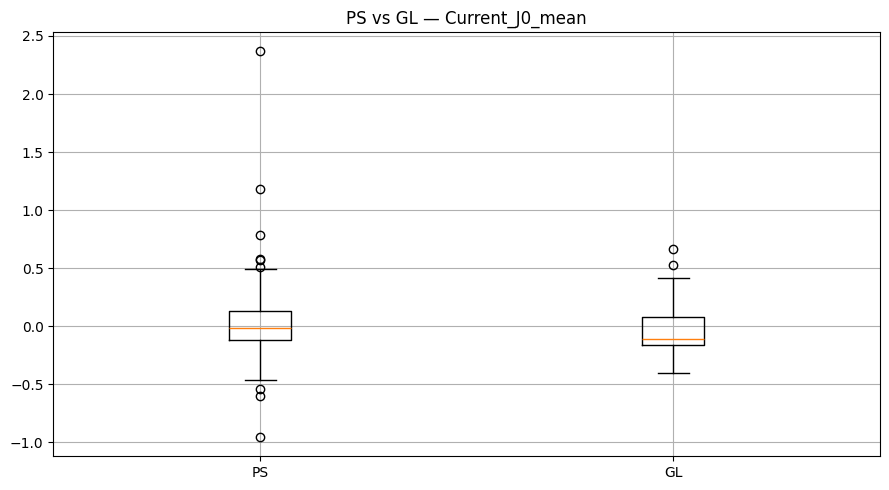

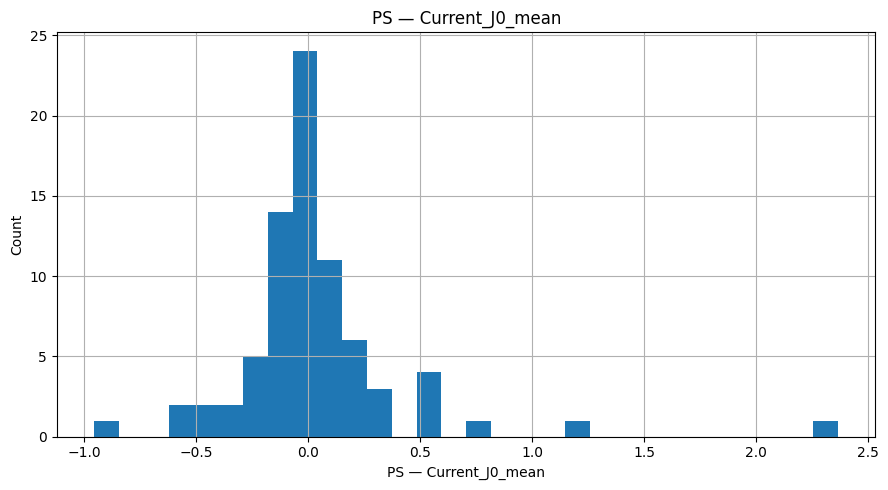

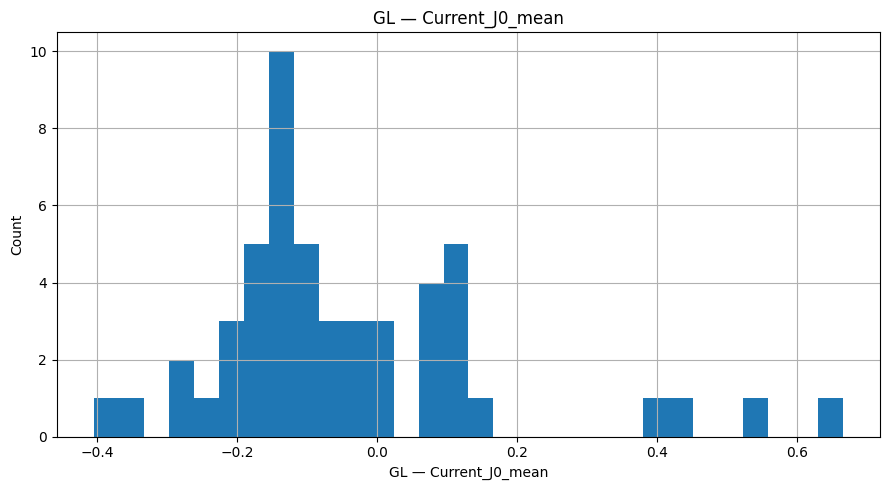

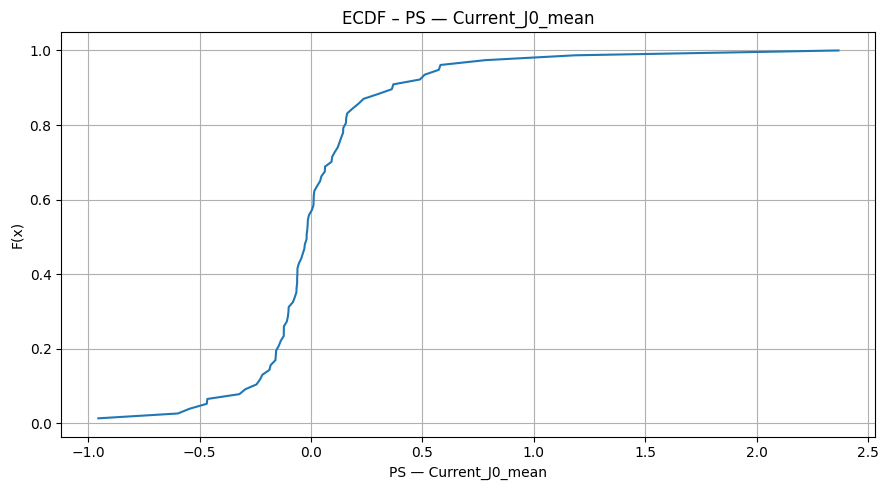

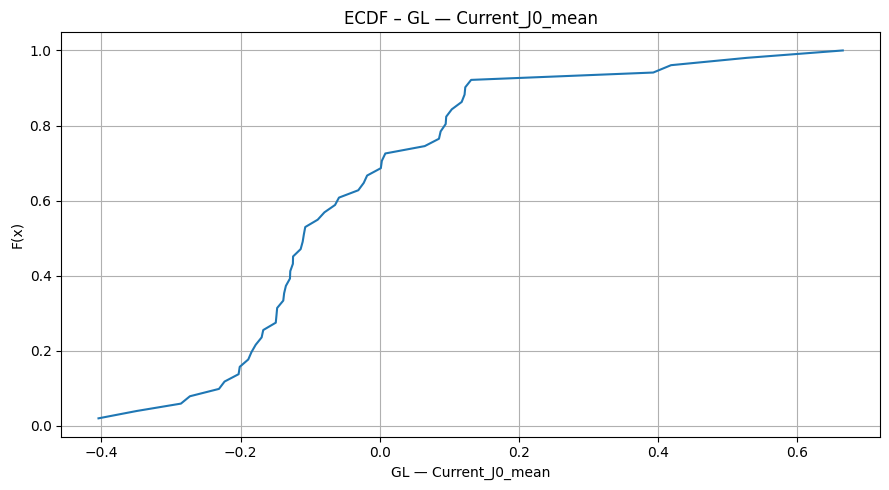

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1943755887.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([a, b], labels=labels); plt.title(title)


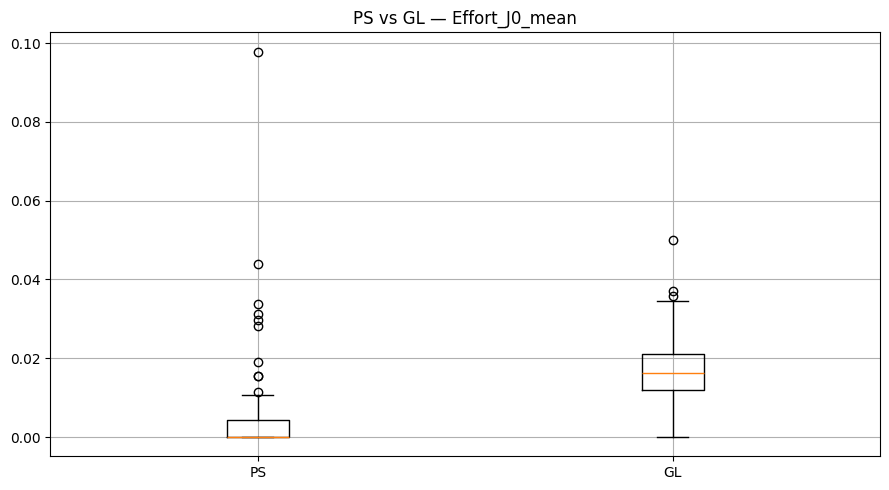

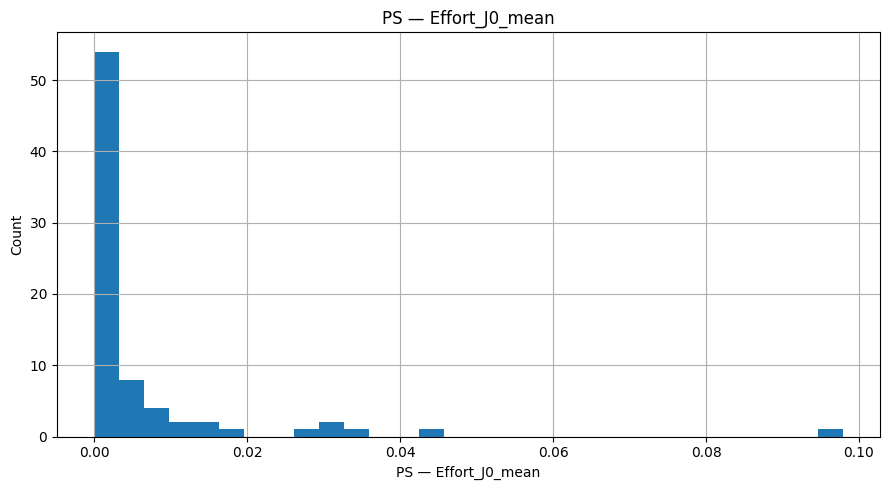

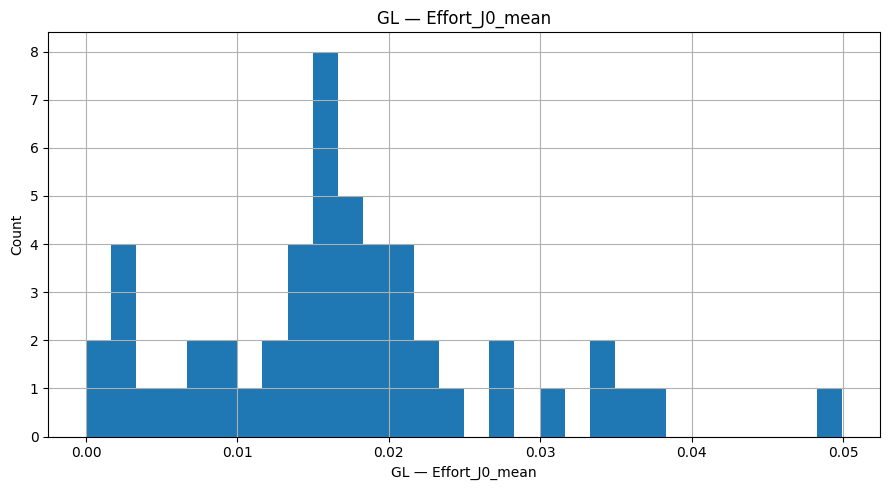

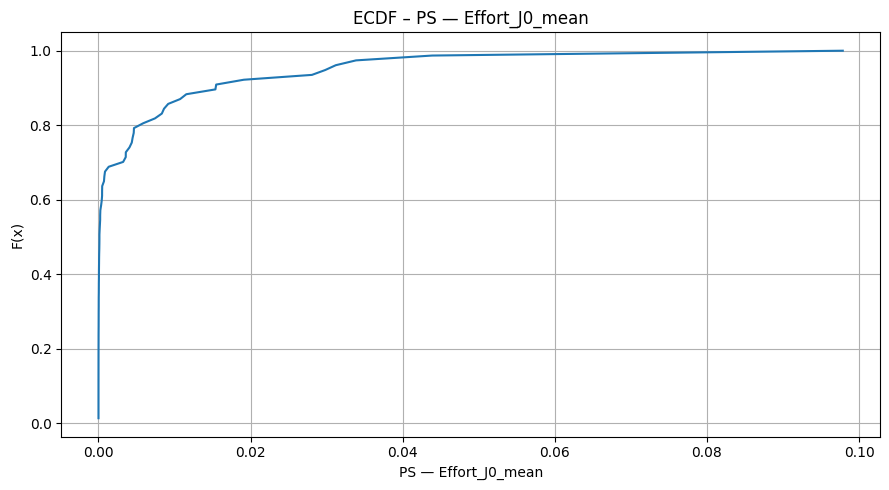

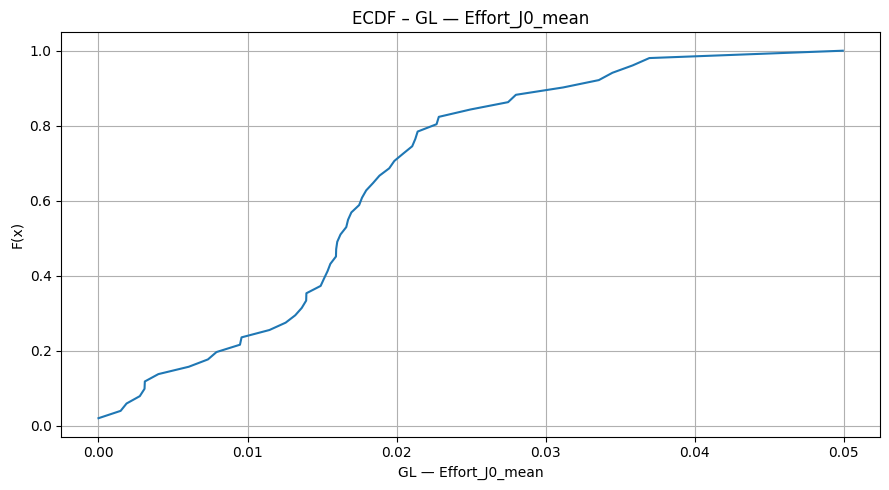

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1943755887.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([a, b], labels=labels); plt.title(title)


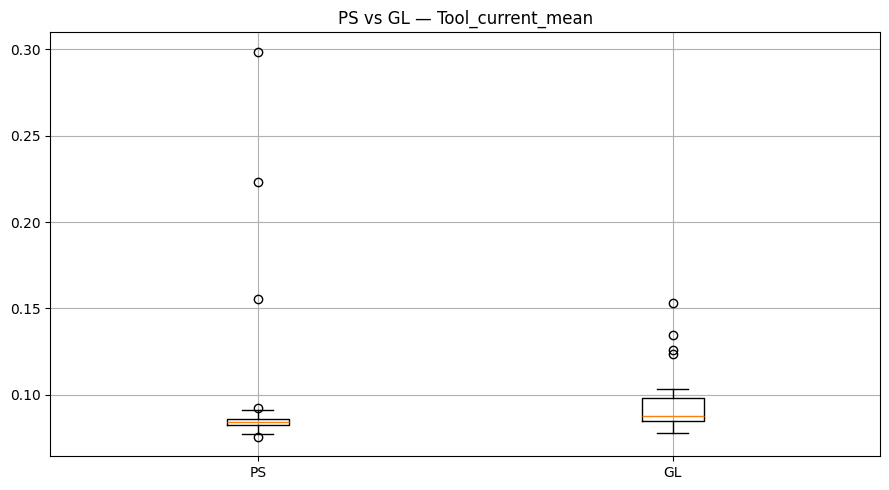

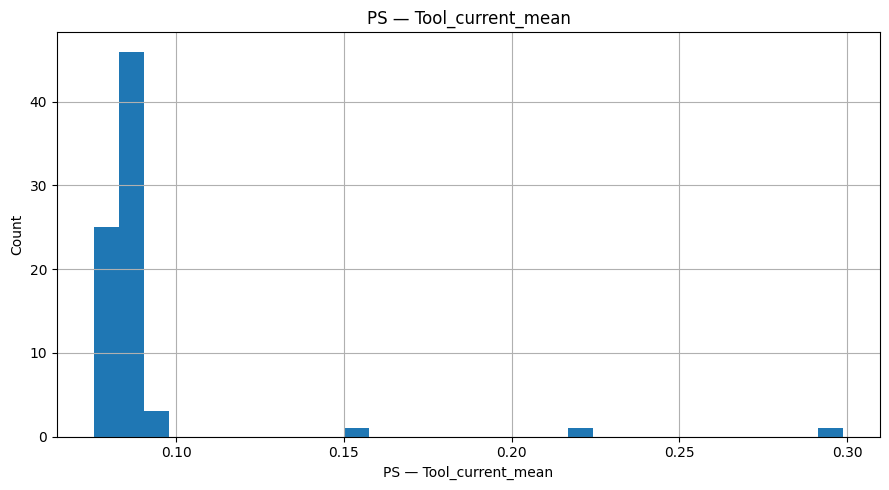

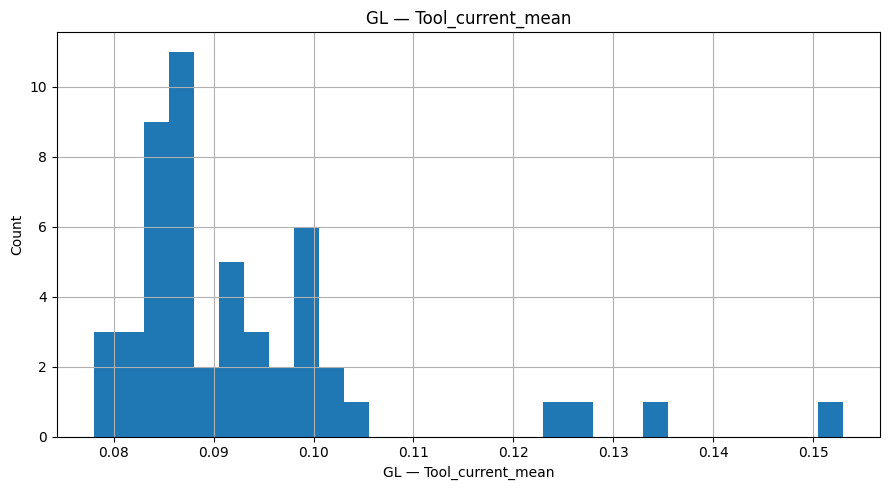

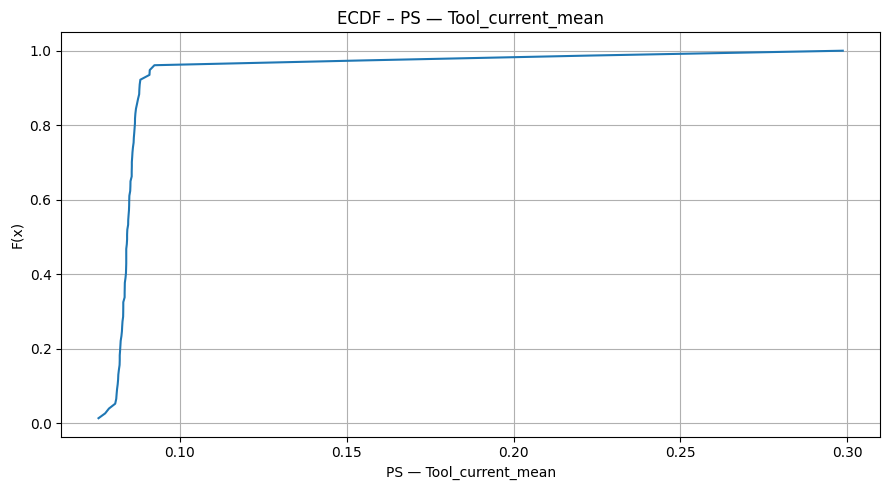

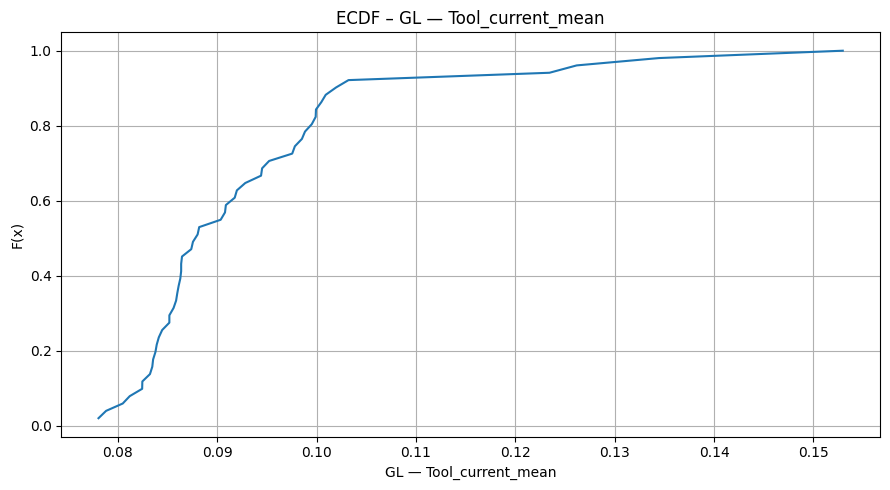

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1943755887.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([a, b], labels=labels); plt.title(title)


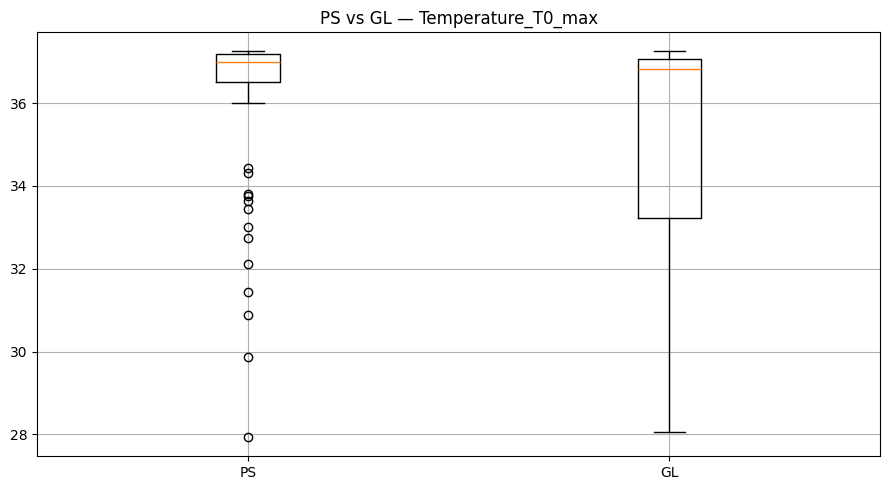

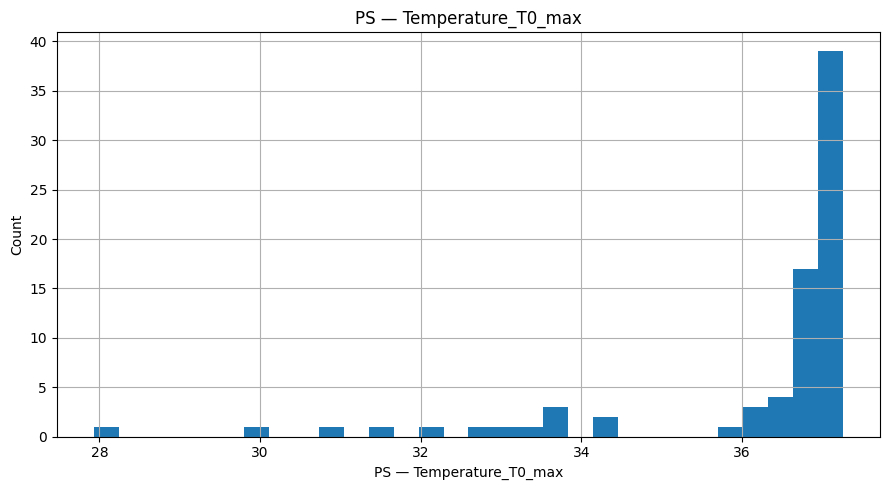

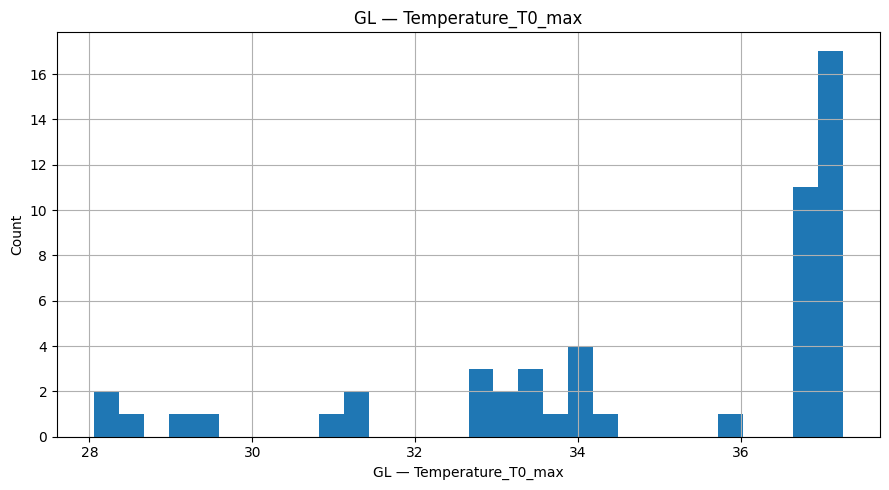

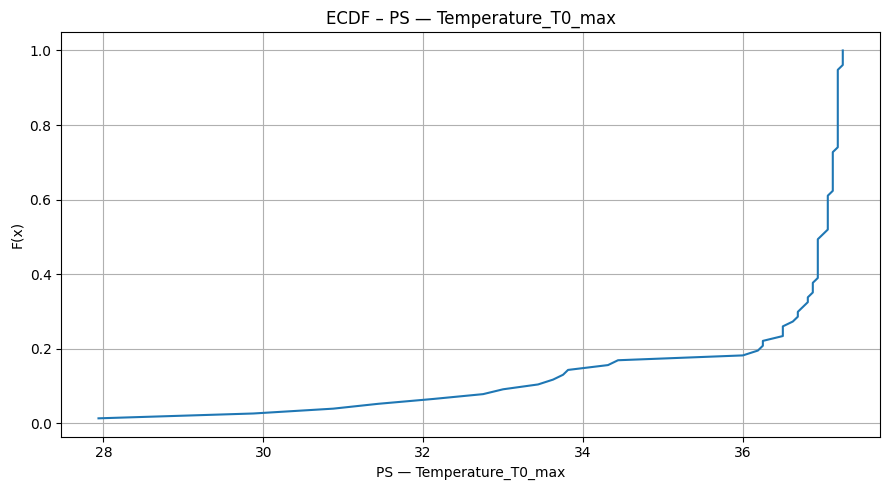

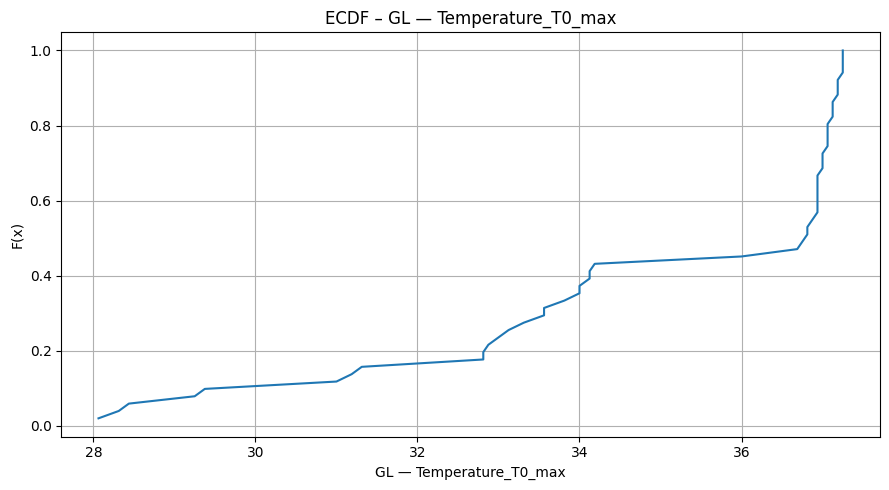

C:\Users\Omar\AppData\Local\Temp\ipykernel_44944\1943755887.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot([a, b], labels=labels); plt.title(title)


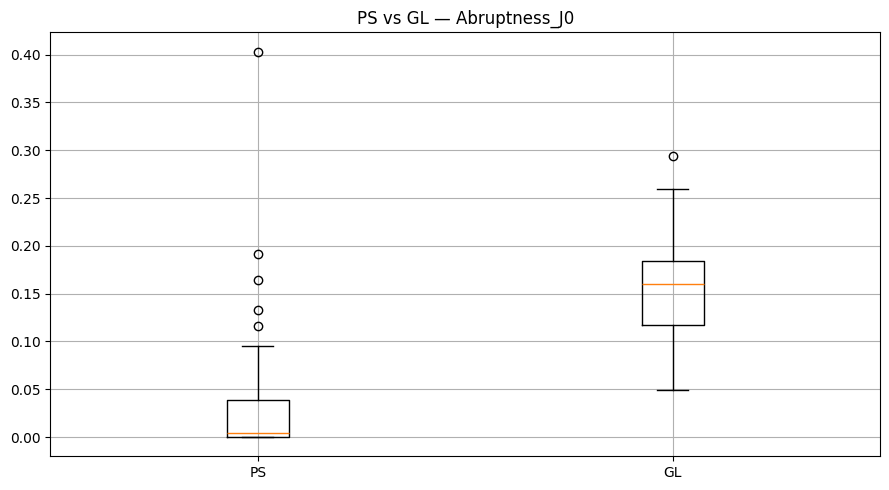

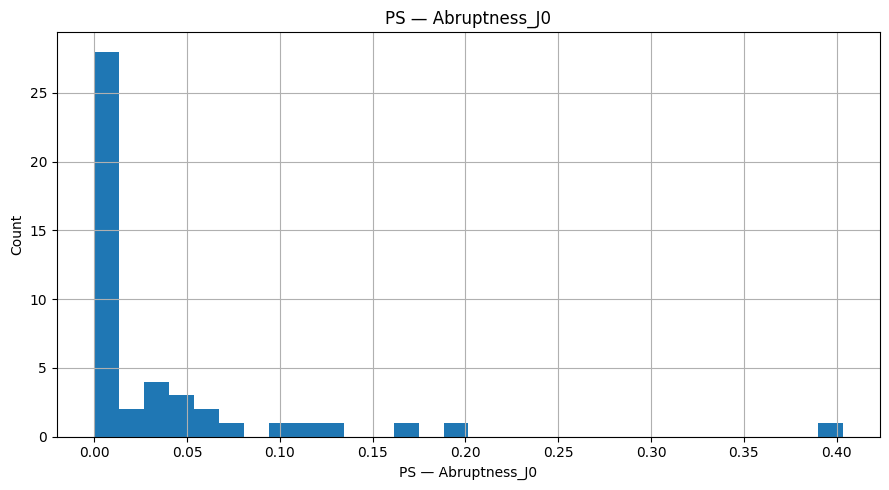

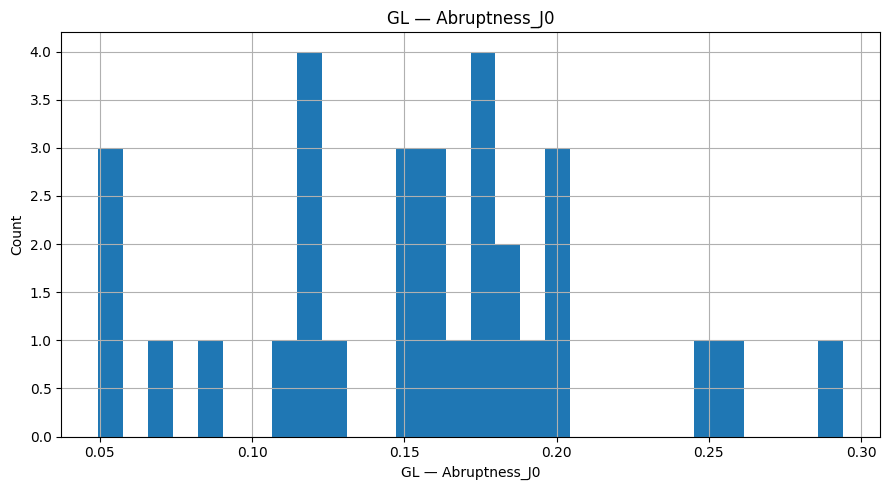

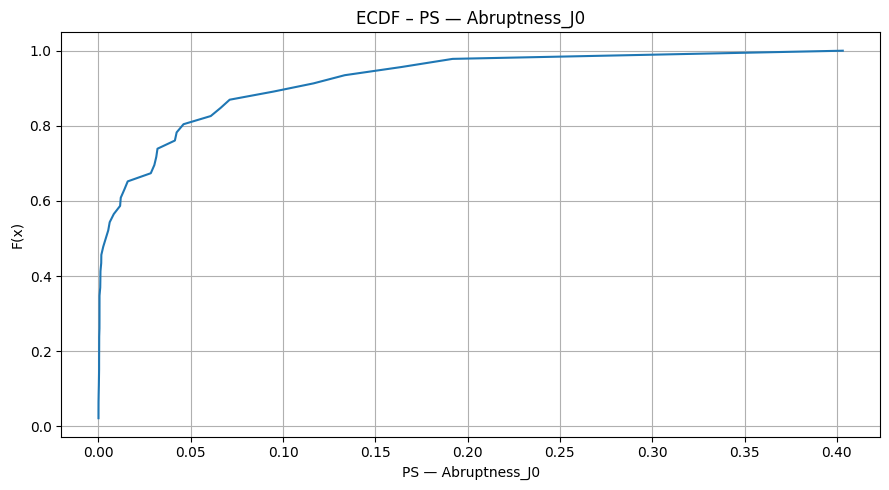

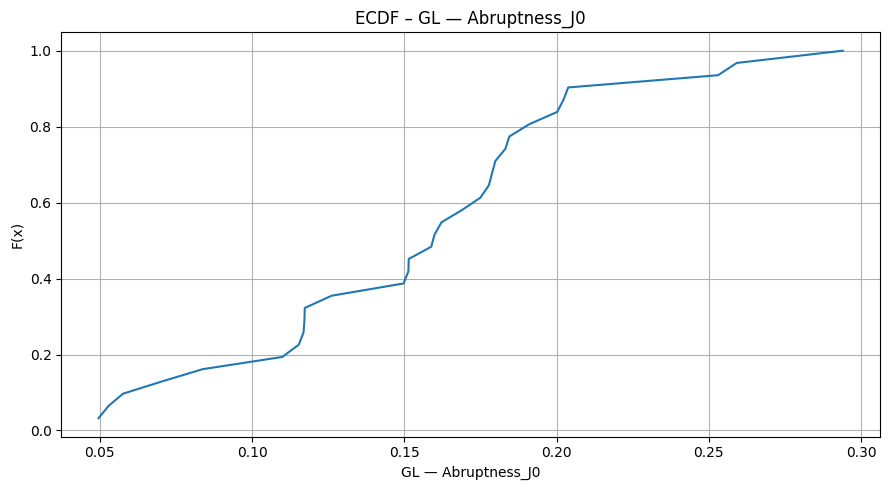

In [82]:
# === Cell 6: Distribution plots (PS vs GL) ===
key_feats = ["Current_J0_mean","Effort_J0_mean","Tool_current_mean","Temperature_T0_max","Abruptness_J0"]
for f in key_feats:
    if f in cyc_ps.columns and f in cyc_gl.columns:
        # Overlaid box comparison (side-by-side)
        plot_box_two(cyc_ps[f], cyc_gl[f], labels=["PS", "GL"], title=f"PS vs GL — {f}")
        # Histograms separately (lets you see shapes)
        plot_hist(cyc_ps[f], f"PS — {f}")
        plot_hist(cyc_gl[f], f"GL — {f}")
        # ECDFs
        plot_ecdf(cyc_ps[f], f"PS — {f}")
        plot_ecdf(cyc_gl[f], f"GL — {f}")


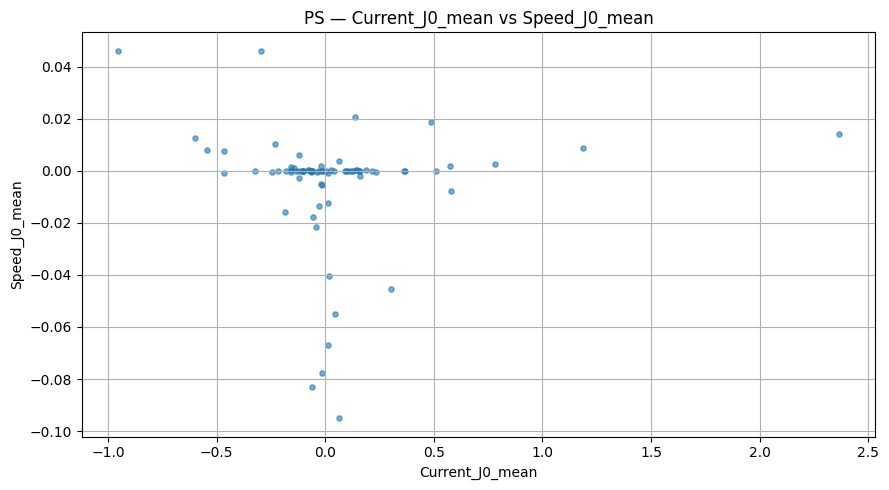

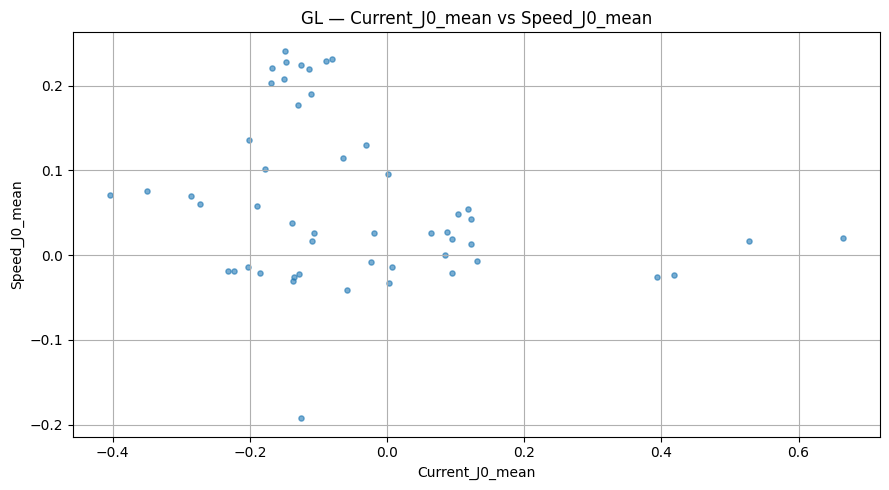

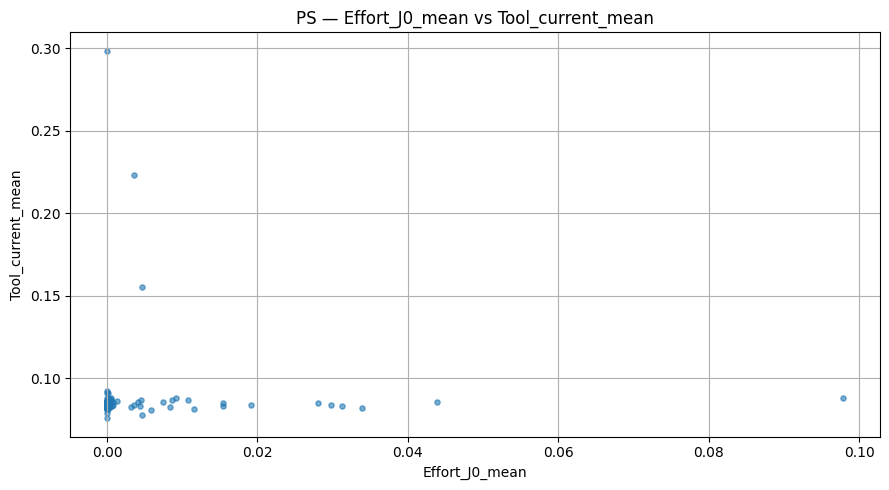

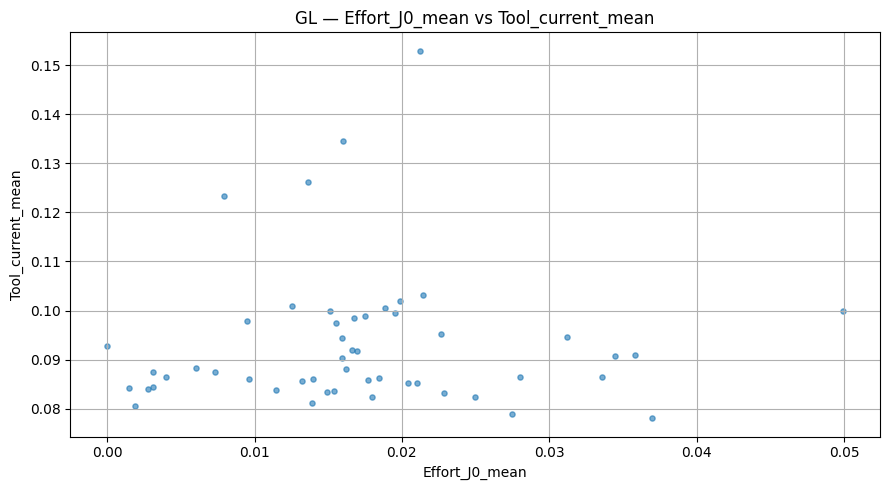

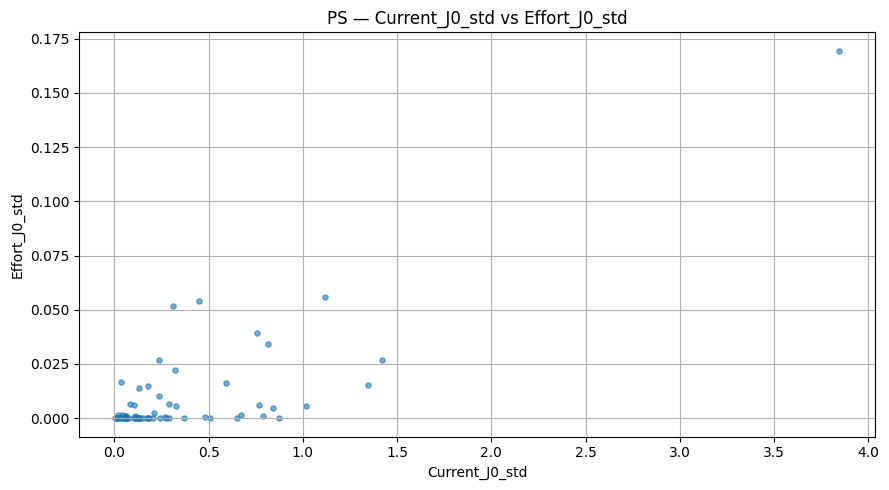

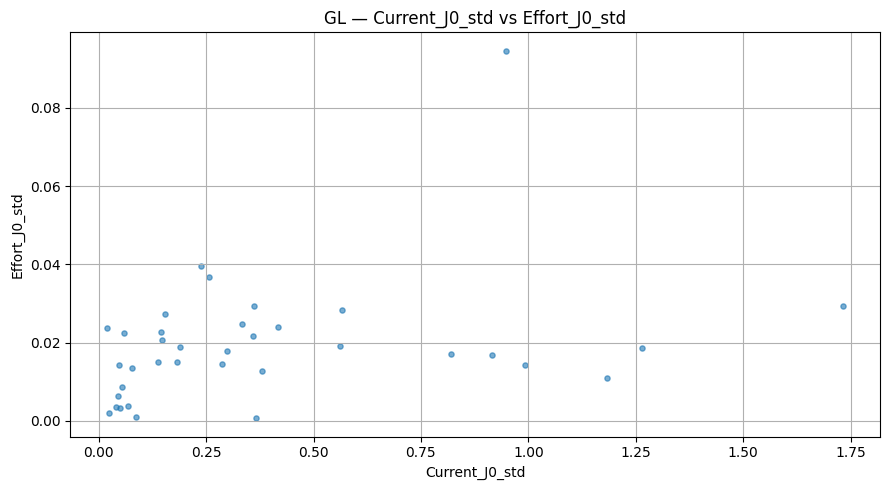

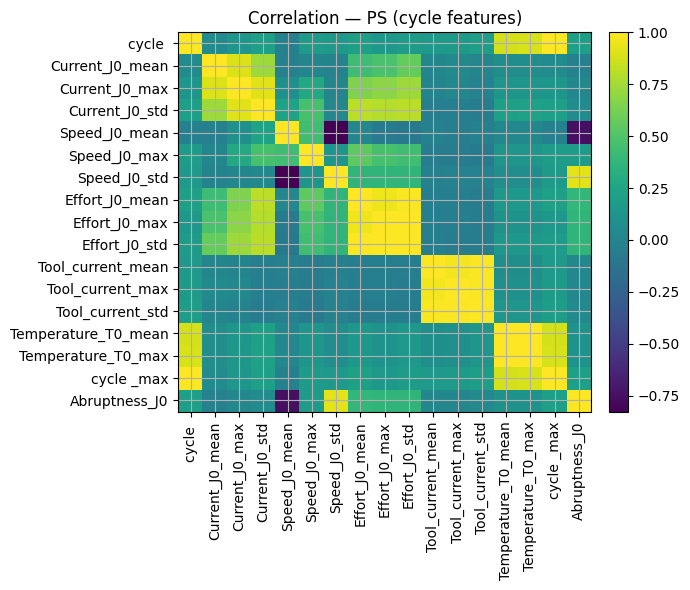

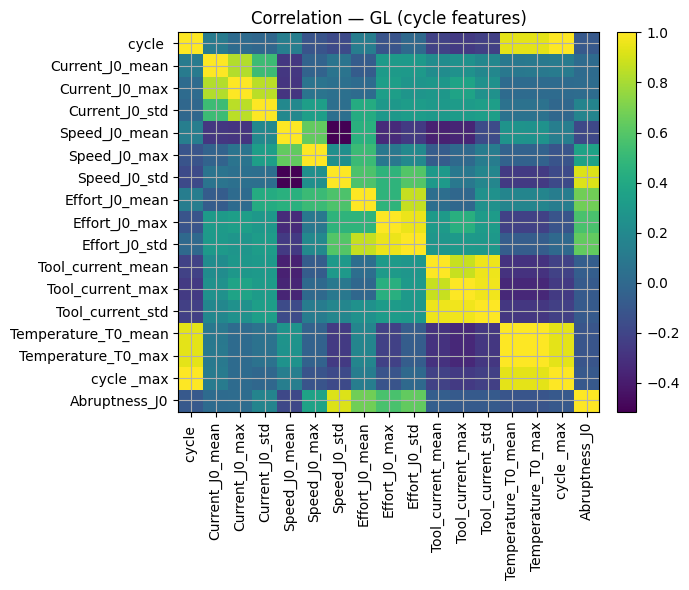

In [ ]:

pairs = [
    ("Current_J0_mean","Speed_J0_mean"),
    ("Effort_J0_mean","Tool_current_mean"),
    ("Current_J0_std","Effort_J0_std"),
]
for x,y in pairs:
    if x in cyc_ps.columns and y in cyc_ps.columns:
        plot_scatter(cyc_ps[x], cyc_ps[y], f"PS — {x} vs {y}", x, y)
    if x in cyc_gl.columns and y in cyc_gl.columns:
        plot_scatter(cyc_gl[x], cyc_gl[y], f"GL — {x} vs {y}", x, y)

plot_corr_heatmap(cyc_ps, "Correlation — PS (cycle features)")
plot_corr_heatmap(cyc_gl, "Correlation — GL (cycle features)")


In [85]:
# === Cell 8: Last-window precursor stats (tail ~5% of each cycle) ===
ps_lw = last_window_stats(ps, frac=0.05, cycle_col=CYCLE_COL, time_col=TIME_COL)
gl_lw = last_window_stats(gl, frac=0.05, cycle_col=CYCLE_COL, time_col=TIME_COL)

common_cols = [c for c in ps_lw.columns if c in gl_lw.columns and c != CYCLE_COL]
rows = []
for c in common_cols:
    A = ps_lw[c].dropna().values
    B = gl_lw[c].dropna().values
    eff = ks_and_effects(A, B)
    rows.append([c, np.nanmedian(A), np.nanmedian(B), eff["KS_D"], eff["KS_p"], eff["Cohen_d"], eff["Cliffs_delta"]])

lw_compare = pd.DataFrame(rows, columns=["Feature","PS_median","GL_median","KS_D","KS_p","Cohen_d","Cliffs_delta"]).sort_values("KS_p")
display(lw_compare)


c:\Users\Omar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Feature  PS_median  GL_median      KS_D          KS_p   Cohen_d  Cliffs_delta
4          Speed_J0_lw_max   0.000000   0.130014  0.653934  6.702939e-13  0.900558      0.475681
3         Speed_J0_lw_mean   0.000000   0.130014  0.653934  6.702939e-13  0.888338      0.475681
1        Current_J0_lw_max  -0.020745  -0.147501  0.518462  3.961762e-08 -0.407365     -0.518717
0       Current_J0_lw_mean  -0.020745  -0.147501  0.518462  3.961762e-08 -0.418018     -0.524319
10   Temperature_T0_lw_max  37.000000  36.812500  0.288515  9.630870e-03 -0.573140     -0.281131
9   Temperature_T0_lw_mean  37.000000  36.812500  0.288515  9.630870e-03 -0.573140     -0.281131
7      Tool_current_lw_max   0.085106   0.085192  0.132671  5.956931e-01  0.058697      0.042017
6     Tool_current_lw_mean   0.085106   0.085106  0.118920  7.247193e-01  0.039767      0.022154
2        Current_J0_lw_std        NaN   0.115198       NaN           NaN       NaN           NaN
5          Speed_J0_lw_std        NaN   0.081807       NaN           NaN       NaN           NaN
8      Tool_current_lw_std        NaN   0.005821       NaN           NaN       NaN           NaN
11   Temperature_T0_lw_std        NaN   0.000000       NaN           NaN       NaN           NaN

In [86]:
# === Cell 9: Outlier counts per cycle (IQR rule) ===
cols_to_check = [c for c in ["Current_J0","Speed_J0","Tool_current"] if c in ps.columns]
ps_out = outlier_counts_per_cycle(ps, cols=cols_to_check, cycle_col=CYCLE_COL)
gl_out = outlier_counts_per_cycle(gl, cols=cols_to_check, cycle_col=CYCLE_COL)

print("Top PS cycles by outlier counts:")
display(ps_out.sort_values(ps_out.columns.tolist()[1:], ascending=False).head(10))

print("\nTop GL cycles by outlier counts:")
display(gl_out.sort_values(gl_out.columns.tolist()[1:], ascending=False).head(10))


Top PS cycles by outlier counts:


cycle   Current_J0_outliers  Speed_J0_outliers  Tool_current_outliers
11      99                    3                  3                      2
55     229                    3                  3                      0
46     219                    2                  1                      1
13     108                    1                  6                      0
4       53                    1                  2                      1
12     103                    1                  2                      1
20     159                    1                  2                      1
50     224                    1                  1                      1
56     230                    1                  1                      1
58     232                    1                  1                      1


Top GL cycles by outlier counts:


cycle   Current_J0_outliers  Speed_J0_outliers  Tool_current_outliers
0        2                    5                  5                      1
41     221                    4                  2                      2
4       15                    2                  4                      1
14      80                    1                  2                      1
23     160                    1                  2                      1
50     262                    1                  1                      1
6       39                    1                  0                      1
9       64                    1                  0                      1
10      65                    1                  0                      1
15      81                    1                  0                      1

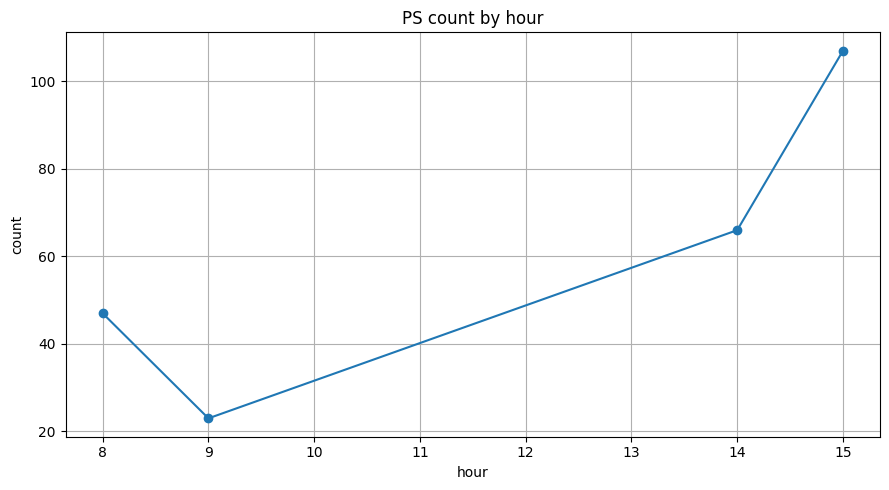

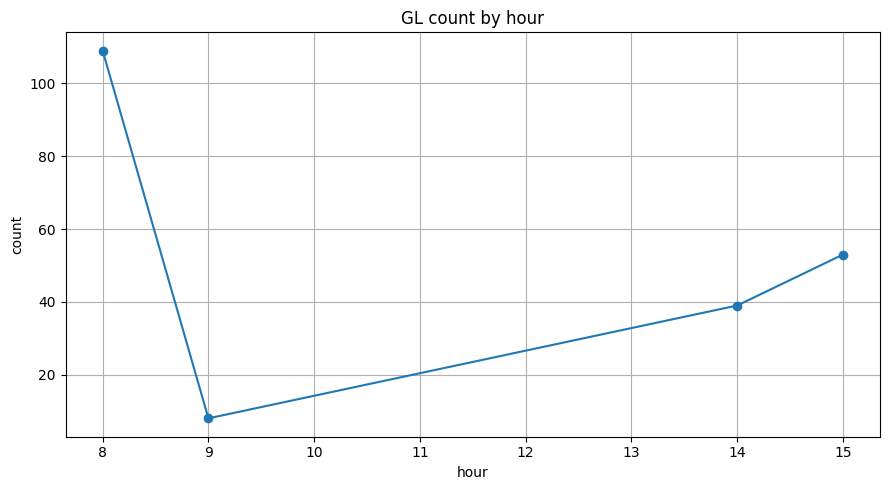

In [88]:
# Robust hour-of-day plots without np.issubdtype headaches
from pandas.api.types import is_datetime64_any_dtype as is_datetime

if TIME_COL and (TIME_COL in ps.columns):
    ps[TIME_COL] = pd.to_datetime(ps[TIME_COL], errors="coerce")
if TIME_COL and (TIME_COL in gl.columns):
    gl[TIME_COL] = pd.to_datetime(gl[TIME_COL], errors="coerce")

# PS hour-of-day
if TIME_COL and (TIME_COL in ps.columns) and is_datetime(ps[TIME_COL]) and ps[TIME_COL].notna().any():
    ps_hours = ps.loc[ps[TIME_COL].notna(), TIME_COL].dt.hour.value_counts().sort_index()
    plt.figure(); plt.plot(ps_hours.index, ps_hours.values, marker='o')
    plt.title("PS count by hour"); plt.xlabel("hour"); plt.ylabel("count"); plt.tight_layout(); plt.show()

# GL hour-of-day
if TIME_COL and (TIME_COL in gl.columns) and is_datetime(gl[TIME_COL]) and gl[TIME_COL].notna().any():
    gl_hours = gl.loc[gl[TIME_COL].notna(), TIME_COL].dt.hour.value_counts().sort_index()
    plt.figure(); plt.plot(gl_hours.index, gl_hours.values, marker='o')
    plt.title("GL count by hour"); plt.xlabel("hour"); plt.ylabel("count"); plt.tight_layout(); plt.show()
